In [1]:
import numpy as np
from scipy.linalg import expm, eig
from scipy.special import comb 
from numba import jit
import matplotlib.pyplot as plt
from scipy.linalg import expm, eig
import warnings
warnings.filterwarnings("ignore")
from torch.distributions import Categorical
import os
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output

import paddle
from paddle_quantum.ansatz import Circuit
from paddle_quantum.fisher import QuantumFisher
#from paddle_quantum.circuit import UAnsatz ##Deprecrated
#from paddle_quantum.utils import QuantumFisher ###Deprecrated

INFO 2024-06-12 22:48:24,852 utils.py:148] Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/openfermion/hamiltonians/hartree_fock.py:11: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  from scipy.optimize.optimize import OptimizeResult
/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/paddle/tensor/creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:
/Users/temitopeadeniyi/opt/anaconda3/envs/tensorflow_m1/lib/python3.9/site-packages/padd

In [2]:
class ReplayBuffer:
    def __init__(self, obs_dim: int, size: int, batch_size: int = 32):
        self.obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.next_obs_buf = np.zeros([size, obs_dim], dtype=np.float32)
        self.acts_buf = np.zeros([size], dtype=np.float32)
        self.rews_buf = np.zeros([size], dtype=np.float32)
        self.done_buf = np.zeros(size, dtype=np.float32)
        self.log_probs_buf = np.zeros([size], dtype=np.float32)  # Added log_probs buffer
        self.max_size, self.batch_size = size, batch_size
        self.ptr, self.size, = 0, 0

    def store(
        self,
        obs: np.ndarray,
        act: np.ndarray,
        rew: float,
        next_obs: np.ndarray,
        done: bool,
        log_prob: float, # stored log_probs 
    ):
        self.obs_buf[self.ptr] = obs
        self.next_obs_buf[self.ptr] = next_obs
        self.acts_buf[self.ptr] = act
        self.rews_buf[self.ptr] = rew
        self.done_buf[self.ptr] = done
        self.log_probs_buf[self.ptr] = log_prob
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample_batch(self) -> Dict[str, np.ndarray]:
        idxs = np.random.choice(self.size, size=self.batch_size, replace=False)
        return dict(
            obs=self.obs_buf[idxs],
            next_obs=self.next_obs_buf[idxs],
            acts=self.acts_buf[idxs],
            rews=self.rews_buf[idxs],
            done=self.done_buf[idxs],
            log_probs=self.log_probs_buf[idxs],  # Include log_probs in the returned dictionary
        )

    def __len__(self) -> int:
        return self.size


In [21]:
### Network for ActorCritic follows a different pattern
## A separate network is created for the Actor and Critic Network

In [22]:
class ActorCritic(nn.Module):
    def __init__(self, in_dim: int, out_dim: int):
        """Initialization."""
        super(ActorCritic, self).__init__()

        self.actor = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, out_dim),
            nn.Softmax(dim=-1)
        )

        self.critic = nn.Sequential(
            nn.Linear(in_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward method implementation."""
        return self.actor(x), self.critic(x)


In [4]:
Jz2

array([[1.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 1.+0.j]])

In [7]:
Jz

array([[-1.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  0.+0.j],
       [ 0.+0.j,  0.+0.j,  1.+0.j]])

In [9]:
Jp

array([[0.        +0.j, 0.        +0.j, 0.        +0.j],
       [1.41421356+0.j, 0.        +0.j, 0.        +0.j],
       [0.        +0.j, 1.41421356+0.j, 0.        +0.j]])

In [10]:
Jm

array([[0.        +0.j, 1.41421356+0.j, 0.        +0.j],
       [0.        +0.j, 0.        +0.j, 1.41421356+0.j],
       [0.        +0.j, 0.        +0.j, 0.        +0.j]])

In [3]:
import numpy as np
from scipy.linalg import expm, eig
from scipy.special import comb 
N = 2
S = float(N)/2
Omega = np.pi*0.5
g = np.pi*0.5
mJ = np.arange(-S, S+1, dtype=float)
Jz2 = np.diag(np.square(mJ)).astype(complex)
Jz = np.diag(mJ).astype(complex)
Jp = np.diag(np.sqrt(S*(S+1) - mJ[:-1]*mJ[1:]), -1).astype(complex)
Jm = np.diag(np.sqrt(S*(S+1) - mJ[1:]*mJ[:-1]), 1).astype(complex)
Rx = expm(-1j*Omega*(Jp + Jm)/2)
Ry = expm(-Omega*(Jp - Jm)/2)
Sq = expm(-1j*g*Jz2)
psi0 = np.zeros(N+1, dtype=complex)
psi0[0] = 1.

n_theta = 5
n_phi = 4

CSS = [[np.zeros(N+1, dtype=complex)]*n_phi for i in range(n_theta)]
for i in range(n_theta):
    for j in range(n_phi):
        theta = i * np.pi / (n_theta - 1)
        phi = j * 2*np.pi / n_phi - np.pi
        css = np.zeros(N+1, dtype=complex)
        for k in range(N+1):
            css[k] = np.sqrt(comb(N, k)) * np.cos(theta/2)**(N-k) * np.sin(theta/2)**k
            css[k] *= np.exp(-1j*k*phi);
        CSS[i][j] = css
        #print(i, j, CSS[i][j])

#print(CSS)
class Env(object):
    
    def __init__(self, var=0.00):
        super(Env, self).__init__()
        self.n_actions = 3
        self.actions = [Rx, Ry, Sq]
        self.n_states = n_theta * n_phi #N+1
        self.psi = psi0
        self.state = self.husimiQ()#np.square(np.absolute(self.psi))
        self.n_steps = 10
        self.t = 0
        self.threshold = 0.95
        print(Sq)#np.conjugate(Rx.T).dot(Rx))
        print(Rx)#np.conjugate(Ry.T).dot(Ry))
        print(Ry)#np.conjugate(Sq.T).dot(Sq))
        print(self.state)
        
    def reset(self):
        self.psi = psi0
        self.state = self.husimiQ()#np.square(np.absolute(self.psi))
        self.t = 0
        #self.noise = 0

        return self.state

    def step(self, action):
        U = self.actions[action]
        self.psi = U.dot(self.psi)
        QFI = np.einsum('i,ij,j->', np.conjugate(self.psi), Jz2, self.psi) - np.abs(np.einsum('i,ij,j->', np.conjugate(self.psi), Jz, self.psi))**2
        QFI = np.real(QFI)
        QFI *= 4
        QFI /= N**2
        #reward
        done =( QFI > self.threshold or self.t >= self.n_steps-1)
        rwd = done * QFI
        if QFI > self.threshold:
            print(self.psi)
        self.t += 1
        self.state = self.husimiQ()#np.square(np.absolute(self.psi))
        #self.state = np.square(np.absolute(np.concatenate((self.Ut[:,1], self.Ut[:,5])))) 
        return self.state, rwd, done, QFI
        
    def husimiQ(self):
        Q = np.zeros([n_theta, n_phi])
        for i in range(n_theta):
            for j in range(n_phi):
                Q[i][j] = abs(np.conjugate(CSS[i][j]).dot(self.psi)) ** 2
        return Q.reshape(n_theta * n_phi)

In [24]:
class ActorCriticAgent:
    def __init__(
        self,
        env: Env,
        memory_size: int,
        batch_size: int,
        target_update: int,
        epsilon_decay: float,
        max_epsilon: float = 1.0,
        min_epsilon: float = 0.02,
        gamma: float = 0.99,
        alpha: float = 0.0002,
    ):

        obs_dim = env.n_states
        action_dim = env.n_actions

        self.env = env
        self.memory = ReplayBuffer(obs_dim, memory_size, batch_size)
        self.batch_size = batch_size
        self.epsilon = max_epsilon
        self.epsilon_decay = epsilon_decay
        self.max_epsilon = max_epsilon
        self.min_epsilon = min_epsilon
        self.target_update = target_update
        self.gamma = gamma
        self.alpha = alpha

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.model = ActorCritic(obs_dim, action_dim).to(self.device)
        self.model_target = ActorCritic(obs_dim, action_dim).to(self.device)
        self.model_target.load_state_dict(self.model.state_dict())
        self.model_target.eval()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.alpha)

        self.transition = list()
        self.is_test = False

#action selection is done probabilistically using the action probabilities outputted by the actor network.
    def select_action(self, state: np.ndarray) -> np.ndarray:
        state = torch.FloatTensor(state).to(self.device)
        action_probs, _ = self.model(state.unsqueeze(0))
        action_probs = action_probs.squeeze().cpu().detach().numpy()
        action = np.random.choice(len(action_probs), p=action_probs)
        if not self.is_test:
            self.transition = [state.cpu().detach().numpy(), action]
        #print(action) #####
        return action

    #def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        
        #next_state, reward, done, _ = self.env.step(action)
    def step(self, action: np.ndarray) -> Tuple[np.ndarray, np.float64, bool]:
        next_state, reward, done, log_prob = self.env.step(action)
        if not self.is_test:
            self.transition += [reward, next_state, done, log_prob]  # Include log_prob in the transition
            self.memory.store(*self.transition)


        return next_state, reward, done

#update the actor and critic networks using the advantage function and the value 
#performs a gradient descent step to update the actor and critic networks. 
# We also backpropagates the gradients, and updates the network parameters.
    def update_model(self) -> torch.Tensor:
        """Update the model by gradient descent."""
        samples = self.memory.sample_batch()#samples a batch of transitions from the memory buffer, 

        actor_loss, critic_loss = self._compute_actor_critic_loss(samples) # and computes the actor and critic losses using the _compute_actor_critic_loss method, 

        self.optimizer.zero_grad()
        #loss.backward()
        actor_loss.backward()
        critic_loss.backward()
        self.optimizer.step()

        return actor_loss.item(), critic_loss.item()

    def train(self, num_frames: int, plotting_interval: int = 200):
        self.is_test = False
        state = self.env.reset()
        update_cnt = 0
        epsilons = []
        actor_losses = []
        critic_losses = []
        scores = []
        score = 0
        cir = Circuit(2)

        for frame_idx in range(1, num_frames + 1):
            action = self.select_action(state)
            print(action)
            
            theta = 2 * np.pi * np.random.random(4)
            theta = paddle.to_tensor(theta, stop_gradient=False, dtype='float64')
            #which_qubit = 0
            #which_qubit1 = 1
            if action == 0:
                #cir = Circuit(2)
                cir.rx(0, param=theta[0])
                cir.rz(0, param=theta[1])

            if action == 1:
                #cir = Circuit(2)
                cir.ry(1, param =theta[2])
                cir.rz(1, param=theta[3])

            if action == 2:
                #cir = Circuit(2)
                cir.s(0)
                cir.s(1)

            next_state, reward, done = self.step(action)
            state = next_state
            score += reward

            if done:
                state = self.env.reset()
                scores.append(score)
                score = 0
                print(cir)
                cir = Circuit(2)

            if len(self.memory) >= self.batch_size * 6:
                actor_loss, critic_loss = self.update_model()
                actor_losses.append(actor_loss)
                critic_losses.append(critic_loss)
                update_cnt += 1
                self.epsilon = max(self.min_epsilon, self.epsilon * (1. - self.epsilon_decay))
                epsilons.append(self.epsilon)
                if update_cnt % self.target_update == 0:
                    self._target_soft_update(0.999)

            if frame_idx % plotting_interval == 0:
                self._plot(frame_idx, scores, actor_losses, critic_losses, epsilons)

    def test(self) -> List[np.ndarray]:
        self.is_test = True
        state = self.env.reset()
        done = False
        score = 0
        frames = []
        c = 0
        while not done:
            action = self.select_action(state)
            c += 1
            next_state, reward, done, log_prob = self.env.step(action)
            frames.append((action, log_prob))
            state = next_state
            score += reward
        print("score: ", score)
        return frames
    
#compute actor and critic losses and perform gradient descent to update the network parameters.
    def _compute_actor_critic_loss(self, samples: Dict[str, np.ndarray]) -> Tuple[torch.Tensor, torch.Tensor]:
        device = self.device
        state = torch.FloatTensor(samples["obs"]).to(device)
        action = torch.LongTensor(samples["acts"].reshape(-1, 1)).to(device)
        log_prob = torch.FloatTensor(samples["log_probs"]).to(device).requires_grad_(True)
        reward = torch.FloatTensor(samples["rews"].reshape(-1, 1)).to(device)
        done = torch.FloatTensor(samples["done"].reshape(-1, 1)).to(device)
        next_state = torch.FloatTensor(samples["next_obs"]).to(device)

        next_value = self.model_target.critic(next_state)
        target_value = reward + self.gamma * (1 - done) * next_value

        values = self.model.critic(state)
        advantages = target_value - values

        actor_loss = -(log_prob * advantages.detach()).mean()
        critic_loss = F.smooth_l1_loss(values, target_value.detach())

        return actor_loss, critic_loss

    def _target_soft_update(self, tau):
        for target_param, param in zip(self.model_target.parameters(), self.model.critic.parameters()):
            target_param.data.copy_(target_param.data * tau + param.data * (1.0 - tau))

    def _plot(
        self,
        frame_idx: int,
        scores: List[float],
        actor_losses: List[float],
        critic_losses: List[float],
        epsilons: List[float],
    ):
        plt.figure(figsize=(20, 5))
        plt.subplot(141)
        plt.title('Reward per Episode')
        plt.plot(scores)
        plt.subplot(142)
        plt.title('Actor Loss per Update')
        plt.plot(actor_losses)
        plt.subplot(143)
        plt.title('Critic Loss per Update')
        plt.plot(critic_losses)
        plt.subplot(144)
        plt.title('Epsilon per Step')
        plt.plot(epsilons)
        plt.show()

In [25]:
# environment
env = Env()

[[6.123234e-17-1.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 1.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 6.123234e-17-1.j]]
[[ 5.00000000e-01+0.j          0.00000000e+00-0.70710678j
  -5.00000000e-01+0.j        ]
 [ 0.00000000e+00-0.70710678j  1.11022302e-16+0.j
   0.00000000e+00-0.70710678j]
 [-5.00000000e-01+0.j          0.00000000e+00-0.70710678j
   5.00000000e-01+0.j        ]]
[[ 5.00000000e-01+0.j  7.07106781e-01+0.j  5.00000000e-01+0.j]
 [-7.07106781e-01+0.j  1.11022302e-16+0.j  7.07106781e-01+0.j]
 [ 5.00000000e-01+0.j -7.07106781e-01+0.j  5.00000000e-01+0.j]]
[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 7.28553391e-01 7.28553391e-01 7.28553391e-01 7.28553391e-01
 2.50000000e-01 2.50000000e-01 2.50000000e-01 2.50000000e-01
 2.14466094e-02 2.14466094e-02 2.14466094e-02 2.14466094e-02
 1.40579963e-65 1.40579963e-65 1.40579963e-65 1.40579963e-65]


In [26]:
seed = 777

def seed_torch(seed):
    torch.manual_seed(seed)
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

np.random.seed(seed)
seed_torch(seed)

In [27]:
# parameters
num_frames = 12*2000
memory_size = 12*2000
batch_size = 32
target_update = 200
epsilon_decay = 1./12/500

#train
agent = ActorCriticAgent(env, memory_size, batch_size, target_update, epsilon_decay)

0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(1.900)----Rz(0.390)----S----Rx(0.501)----Rz(3.705)--
                                                         
------S--------------------------------------------------
                                                         
1
0
2
0
0
0
0
0
0
1
[-5.00000000e-01+5.00000000e-01j -1.66533454e-16+7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.171)----Rz(2.455)----S----Rx(3.248)----Rz(3.258)----Rx(3.293)----Rz(5.629)----Rx(3.845)----Rz(4.562)----Rx(3.505)----Rz(3.461)----Rx(4.281)----Rz(2.277)----Rx(2.609)----Rz(5.795)--
                                                                                                                                                                                           
--Ry(1.689)----Rz(2.345)----S----Ry(0.103)----Rz(0.610)-----------------------------------------------------------------------------------------------------------------

2
1
2
1
[-5.00000000e-01-5.00000000e-01j  3.25176795e-17-5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(3.633)----Rz(5.441)----Rx(4.360)----Rz(0.801)----S--------S--------------------------------------------------
                                                                                                                       
--S----Ry(2.626)----Rz(0.825)----Ry(2.172)----Rz(3.395)----S----Ry(1.272)----Rz(3.836)----S----Ry(0.014)----Rz(5.046)--
                                                                                                                       
2
0
1
1
1
0
0
2
0
[5.00000000e-01-5.00000000e-01j 1.11022302e-16+5.88784672e-17j
 5.00000000e-01+5.00000000e-01j]
--S----Rx(1.295)----Rz(4.203)----Rx(4.075)----Rz(1.081)----Rx(2.976)----Rz(0.625)----S----Rx(1.823)----Rz(2.718)--
                                                                                                                  
--S----Ry(2.686)----Rz(1.495)----Ry(2.858)----Rz(2.166)----Ry(2.427)-

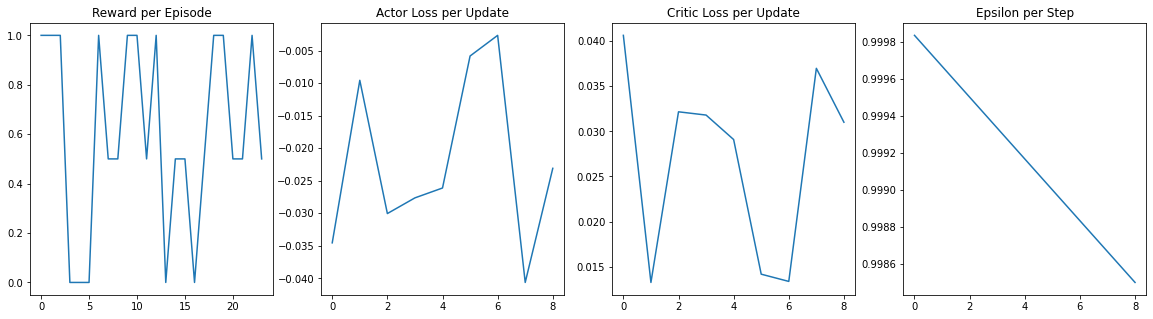

1
2
0
2
2
0
0
0
0
--S--------S--------Rx(5.483)----Rz(5.363)----S----S----Rx(5.015)----Rz(1.295)----Rx(1.610)----Rz(4.169)----Rx(5.219)----Rz(3.888)----Rx(2.351)----Rz(3.329)--
                                                                                                                                                              
--S----Ry(5.276)----Rz(4.667)--------S--------S----S----------------------------------------------------------------------------------------------------------
                                                                                                                                                              
0
1
1
2
2
1
2
2
0
1
--Rx(5.166)----Rz(4.833)--------S------------S--------S----S----Rx(0.510)----Rz(0.558)--------------------------------------
                                                                                                                            
--Ry(0.121)----Rz(0.805)----Ry(0.791)----Rz(1.067)----S----S----Ry(2.697)---

1
1
0
0
1
--Rx(1.615)----Rz(1.335)----Rx(0.302)----Rz(3.941)----Rx(5.039)----Rz(1.741)----Rx(5.482)----Rz(5.535)------------------------------------------------------
                                                                                                                                                            
--Ry(4.955)----Rz(0.025)----Ry(5.124)----Rz(3.038)----Ry(5.682)----Rz(3.195)----Ry(5.963)----Rz(0.280)----Ry(2.852)----Rz(1.885)----Ry(3.388)----Rz(5.274)--
                                                                                                                                                            
2
0
0
0
0
0
1
1
0
0
--S----Rx(5.127)----Rz(2.504)----Rx(2.610)----Rz(3.025)----Rx(4.912)----Rz(2.697)----Rx(2.055)----Rz(3.124)----Rx(2.240)----Rz(3.346)----Rx(2.273)----Rz(4.767)----Rx(3.764)----Rz(4.388)--
                                                                                                                                                          

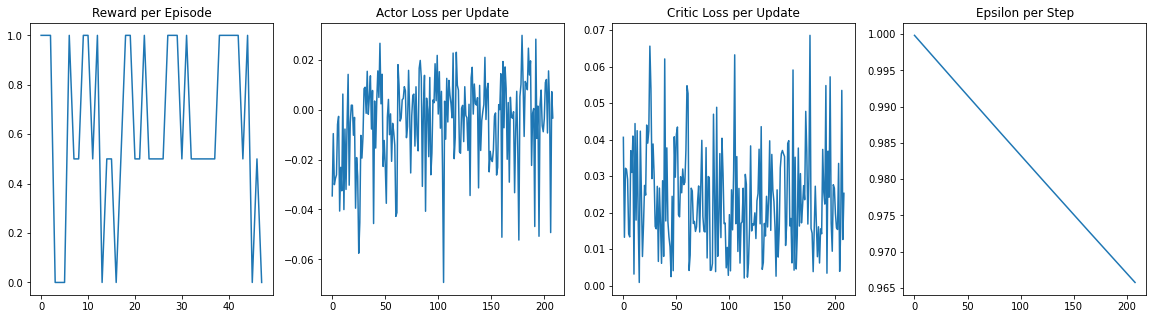

2
1
[ 5.00000000e-01-5.00000000e-01j  7.85046229e-17+5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--S----S--------S------------S--------S--------------------------------------
                                                                             
--S----S----Ry(1.756)----Rz(1.891)----S----S----S----Ry(4.834)----Rz(6.106)--
                                                                             
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(2.271)----Rz(3.405)----S----Ry(5.854)----Rz(4.166)--
                                                         
1
0
0
1
0
0
1
1
0
0
--Rx(1.930)----Rz(1.731)----Rx(1.030)----Rz(5.678)----Rx(3.462)----Rz(3.234)----Rx(3.814)----Rz(0.772)----Rx(5.278)----Rz(2.818)----Rx(5.526)----Rz(5.682)--
                                                                       

1
1
2
0
0
1
[ 5.00000000e-01+5.0000000e-01j -4.99600361e-16+1.3738309e-16j
  5.00000000e-01-5.0000000e-01j]
--Rx(3.588)----Rz(4.170)----Rx(5.526)----Rz(5.412)----Rx(2.146)----Rz(0.835)----S----Rx(1.960)----Rz(3.356)----Rx(3.870)----Rz(0.718)--
                                                                                                                                       
--Ry(3.594)----Rz(4.544)----Ry(0.371)----Rz(0.854)----Ry(5.162)----Rz(3.814)----S----Ry(3.112)----Rz(0.049)----------------------------
                                                                                                                                       
2
2
2
2
1
1
0
1
2
2
--S----S----S----S----Rx(4.378)----Rz(3.545)--------S------------S------------------------------------------
                                                                                                            
--S----S----S----S----Ry(1.636)----Rz(1.649)----Ry(3.142)----Rz(5.906)----Ry(3.545)----Rz(3.671)----S----S--
 

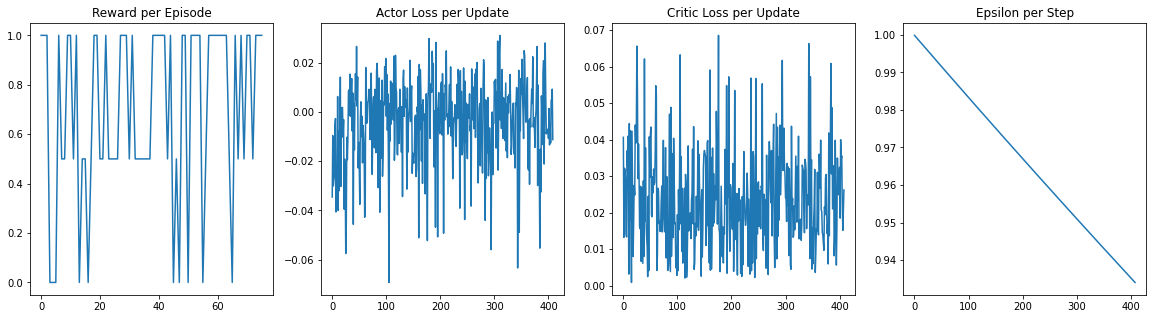

1
0
0
2
1
1
1
--S----S----Rx(0.056)----Rz(1.726)----Rx(2.352)----Rz(2.462)----Rx(2.591)----Rz(5.572)--------S--------------------------------
                                                                                                                               
--S----S----Ry(3.183)----Rz(5.088)--------S--------Ry(0.130)----Rz(2.681)----Ry(3.980)----Rz(1.342)----Ry(2.269)----Rz(1.184)--
                                                                                                                               
0
1
0
1
1
1
2
0
0
0
--Rx(3.429)----Rz(5.539)----Rx(4.111)----Rz(2.568)--------S--------Rx(0.978)----Rz(5.283)----Rx(5.742)----Rz(4.840)----Rx(0.098)----Rz(5.666)--
                                                                                                                                               
--Ry(2.810)----Rz(1.514)----Ry(4.747)----Rz(0.728)----Ry(3.269)----Rz(5.366)----Ry(5.973)----Rz(2.432)--------S--------------------------------
                      

1
1
1
1
--Rx(1.280)----Rz(5.959)--------S--------S----Rx(1.146)----Rz(5.069)--------S------------------------------------------------------------------------------------
                                                                                                                                                                 
------S--------Ry(1.753)----Rz(6.035)----S--------S--------Ry(0.308)----Rz(1.651)----Ry(5.009)----Rz(1.037)----Ry(1.050)----Rz(0.034)----Ry(2.138)----Rz(4.315)--
                                                                                                                                                                 
1
2
2
0
2
0
2
1
0
2
------S------------S--------Rx(5.559)----Rz(0.112)----S----Rx(0.317)----Rz(0.725)--------S--------Rx(4.523)----Rz(3.591)----S--
                                                                                                                               
--Ry(2.019)----Rz(3.482)--------S------------S--------S--------S----

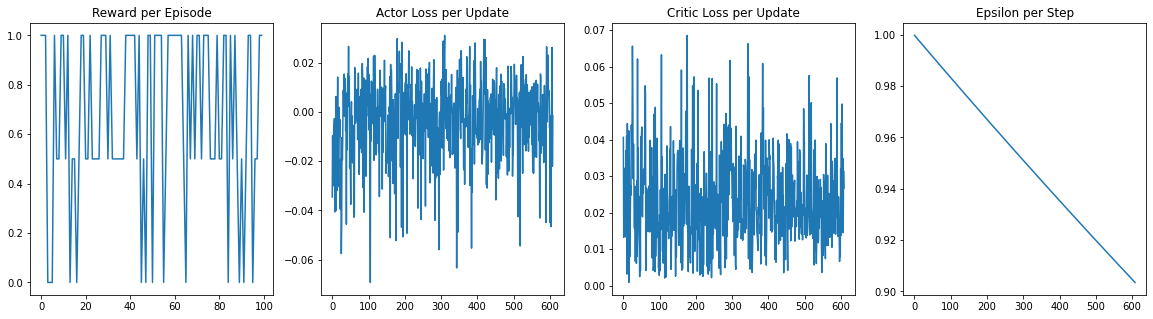

1
2
0
0
0
1
[-5.00000000e-01-5.00000000e-01j  1.11022302e-16-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--S--------S--------Rx(5.355)----Rz(5.795)----Rx(0.335)----Rz(5.882)----Rx(0.148)----Rz(5.315)--
                                                                                                
--S----Ry(3.174)----Rz(6.054)--------S--------Ry(0.430)----Rz(6.222)----------------------------
                                                                                                
1
0
0
1
2
0
1
1
2
1
--Rx(5.066)----Rz(0.040)----Rx(5.161)----Rz(0.640)----S----Rx(0.245)----Rz(3.937)--------S--------------------------------------------------
                                                                                                                                            
--Ry(4.388)----Rz(0.072)----Ry(4.458)----Rz(4.030)----S----Ry(4.332)----Rz(5.791)----Ry(0.251)----Rz(5.869)----S----Ry(2.140)----Rz(2.565)--
                                                          

0
0
0
--Rx(0.668)----Rz(6.156)----Rx(4.050)----Rz(1.567)----Rx(2.426)----Rz(5.670)----S----Rx(5.721)----Rz(2.224)----Rx(4.639)----Rz(2.144)----Rx(4.776)----Rz(0.528)----Rx(3.792)----Rz(5.439)----Rx(2.167)----Rz(1.541)--
                                                                                                                                                                                                                     
--Ry(5.397)----Rz(2.479)--------S------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                     
1
1
0
1
2
1
0
[ 5.00000000e-01-5.00000000e-01j -7.85046229e-17-2.22044605e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.648)----Rz(6.232)-

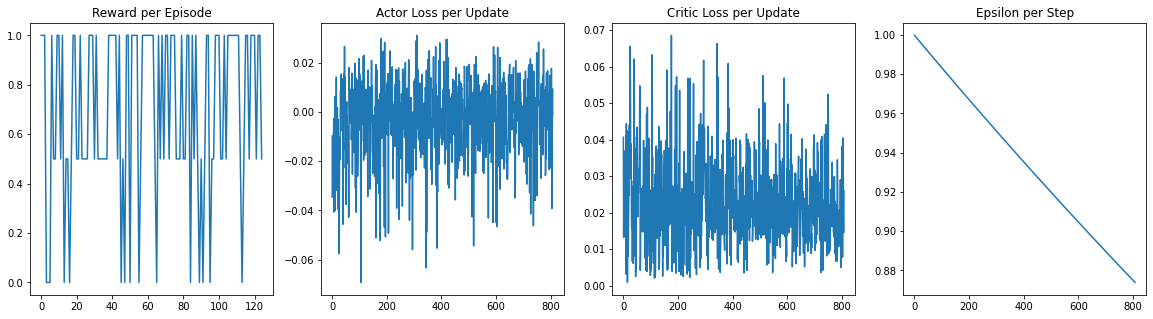

2
0
2
0
--Rx(5.040)----Rz(3.017)----S----Rx(5.892)----Rz(2.431)----S----S----S----Rx(6.145)----Rz(5.324)----S----Rx(2.596)----Rz(1.111)--
                                                                                                                                 
--Ry(1.166)----Rz(2.367)----S--------S------------S--------S----S----------------------------------------------------------------
                                                                                                                                 
2
1
0
0
1
0
2
2
2
0
[ 5.00000000e-01-5.00000000e-01j -3.25176795e-17+5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--S----Rx(5.497)----Rz(4.428)----Rx(0.444)----Rz(5.716)----Rx(1.350)----Rz(5.808)----S----S----S----Rx(5.557)----Rz(0.334)--
                                                                                                                            
--S----Ry(2.013)----Rz(5.605)----Ry(3.348)----Rz(2.702)--------S------------S--------S-----------------

0
2
1
--Rx(3.921)----Rz(6.164)----Rx(2.136)----Rz(4.867)----Rx(2.777)----Rz(6.209)----Rx(4.774)----Rz(2.366)----S----------------------------
                                                                                                                                       
--Ry(5.787)----Rz(2.365)----Ry(1.146)----Rz(0.547)----Ry(1.700)----Rz(2.035)----Ry(5.619)----Rz(0.015)----S----Ry(0.095)----Rz(2.939)--
                                                                                                                                       
1
0
0
2
2
1
1
1
2
0
--Rx(3.173)----Rz(4.998)----Rx(3.216)----Rz(3.575)--------S------------S------------S--------Rx(1.993)----Rz(5.623)--------------------
                                                                                                                                       
--Ry(0.428)----Rz(1.798)--------S------------S--------Ry(3.145)----Rz(5.207)----Ry(3.959)----Rz(6.263)----Ry(2.288)----Rz(5.403)----S--
                      

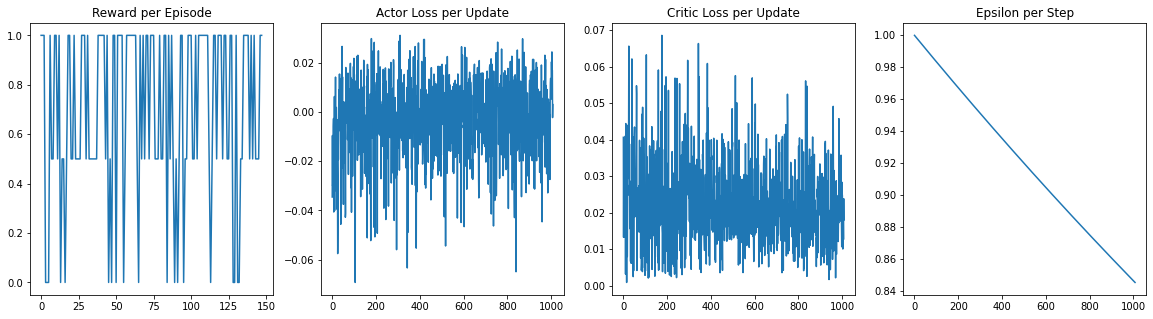

2
0
[-5.00000000e-01+5.00000000e-01j -3.00549228e-16+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.583)----Rz(2.213)----Rx(2.254)----Rz(5.548)----Rx(3.997)----Rz(4.186)----Rx(5.703)----Rz(4.705)----S----Rx(4.077)----Rz(5.422)----S----Rx(4.236)----Rz(4.348)--
                                                                                                                                                                      
------S------------S--------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                      
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(4.090)----Rz(5.240)----S----Rx(2.493)----Rz(2.602)--
                                                         
------S-

2
1
0
0
--Rx(1.114)----Rz(4.410)--------S------------S--------Rx(6.039)----Rz(5.345)----S----Rx(4.872)----Rz(5.843)----Rx(4.629)----Rz(5.274)--
                                                                                                                                       
------S------------S--------Ry(1.070)----Rz(3.015)----Ry(1.734)----Rz(3.122)----S----Ry(3.646)----Rz(3.639)----------------------------
                                                                                                                                       
2
1
0
1
0
1
0
0
2
0
[-5.00000000e-01+5.00000000e-01j  5.88784672e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--S----Rx(1.286)----Rz(6.214)----Rx(3.859)----Rz(6.254)----Rx(2.501)----Rz(0.421)----Rx(0.215)----Rz(5.167)----S----Rx(5.702)----Rz(2.484)--
                                                                                                                                            
--S----Ry(0.315)----Rz(4.464)----Ry(4.502)----R

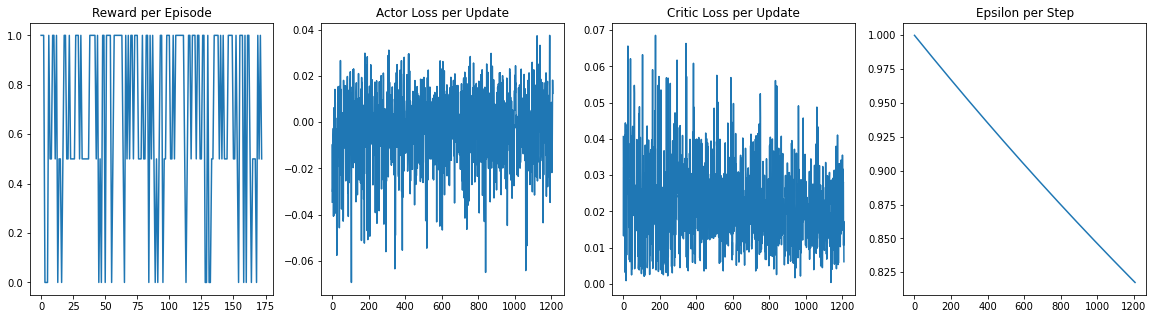

1
2
0
0
0
1
[-5.00000000e-01+5.00000000e-01j  3.33066907e-16-3.25176795e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.276)----Rz(4.649)----Rx(2.944)----Rz(4.698)----S----Rx(0.537)----Rz(1.434)----Rx(4.268)----Rz(5.136)----Rx(2.276)----Rz(6.272)--
                                                                                                                                       
--Ry(4.035)----Rz(2.683)----Ry(0.840)----Rz(1.703)----S----Ry(4.986)----Rz(0.543)------------------------------------------------------
                                                                                                                                       
2
0
1
2
1
0
[-5.00000000e-01+5.00000000e-01j  1.66533454e-16-5.88784672e-17j
 -5.00000000e-01-5.00000000e-01j]
--S----Rx(5.639)----Rz(1.746)----S----Rx(5.870)----Rz(3.329)--
                                                              
--S----Ry(5.320)----Rz(0.691)----S----Ry(3.827)----Rz(4.905)--
                                             

2
0
0
0
--S----Rx(1.815)----Rz(5.278)--------S------------S--------Rx(4.902)----Rz(2.093)----Rx(4.558)----Rz(4.110)----Rx(2.698)----Rz(0.625)--
                                                                                                                                       
--S--------S--------Ry(3.269)----Rz(5.898)----Ry(3.603)----Rz(2.598)----Ry(4.413)----Rz(1.045)--------S--------------------------------
                                                                                                                                       
2
1
1
2
0
1
0
1
0
2
--S--------S--------Rx(4.900)----Rz(1.816)----Rx(6.133)----Rz(0.164)----Rx(5.183)----Rz(1.116)--------S------------------------
                                                                                                                               
--S----Ry(5.091)----Rz(4.637)----Ry(6.102)----Rz(4.451)--------S--------Ry(0.131)----Rz(3.847)----Ry(4.032)----Rz(2.792)----S--
                                            

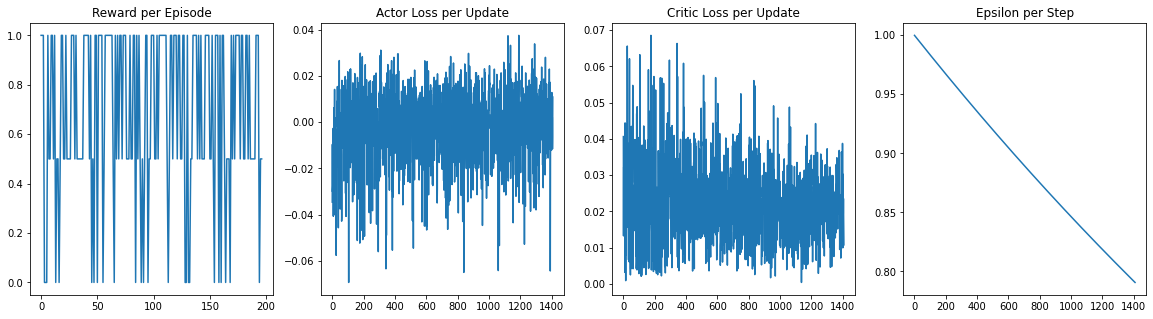

0
2
0
[5.00000000e-01-5.00000000e-01j 1.66533454e-16+7.85046229e-17j
 5.00000000e-01+5.00000000e-01j]
--Rx(0.194)----Rz(2.228)----Rx(1.963)----Rz(1.102)----Rx(2.996)----Rz(5.202)----S----Rx(0.282)----Rz(5.717)--
                                                                                                             
------S------------------------------------------------------------------------------------------------------
                                                                                                             
0
1
0
2
1
2
0
2
2
2
--Rx(1.120)----Rz(3.043)----Rx(5.965)----Rz(1.392)--------S--------S----Rx(1.708)----Rz(5.380)----S----S----S--
                                                                                                               
--Ry(1.058)----Rz(2.627)--------S--------Ry(3.927)----Rz(0.818)----S--------S------------S--------S------------
                                                                                                      

2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(6.055)----Rz(0.966)----S----Rx(0.354)----Rz(5.624)--
                                                         
--Ry(3.080)----Rz(1.287)----S----------------------------
                                                         
2
0
2
1
0
[-5.00000000e-01-5.00000000e-01j  7.85046229e-17+1.66533454e-16j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(0.287)----Rz(2.003)--------S--------Rx(1.231)----Rz(3.044)--
                                                                      
--S--------S--------Ry(5.380)----Rz(4.511)----------------------------
                                                                      
0
1
1
2
2
0
1
0
2
1
[5.00000000e-01-5.00000000e-01j 1.66533454e-16-7.85046229e-17j
 5.00000000e-01+5.00000000e-01j]
--Rx(0.849)----Rz(3.532)--------S------------S--------Rx(0.460)----Rz(2.851)----Rx(4.676)----Rz(6.201)----S----------------------------
                    

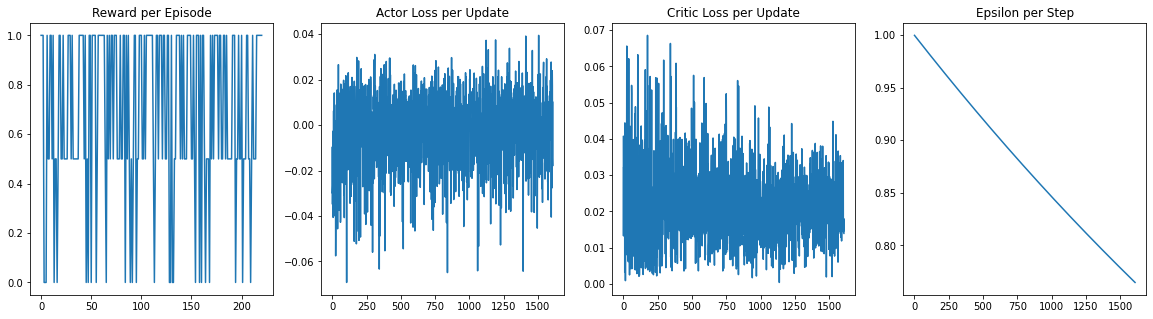

2
0
0
--Rx(2.712)----Rz(2.580)----Rx(4.394)----Rz(3.726)----Rx(2.656)----Rz(0.158)----Rx(1.507)----Rz(0.450)----S----Rx(1.580)----Rz(0.243)----Rx(5.671)----Rz(5.055)----S----Rx(0.635)----Rz(5.051)----Rx(0.638)----Rz(1.499)--
                                                                                                                                                                                                                          
------S------------S------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                          
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(0.109)--

0
2
--Rx(4.800)----Rz(3.487)----Rx(1.916)----Rz(0.142)--------S--------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                           
--Ry(2.350)----Rz(5.473)----Ry(1.813)----Rz(0.412)----Ry(4.907)----Rz(6.281)----Ry(1.227)----Rz(5.928)----Ry(1.356)----Rz(0.811)----Ry(3.365)----Rz(0.180)----Ry(2.075)----Rz(4.912)----S--
                                                                                                                                                                                           
0
0
1
0
2
0
2
1
1
2
--Rx(3.472)----Rz(1.714)----Rx(0.698)----Rz(5.965)----Rx(4.064)----Rz(3.805)--------S--------Rx(5.319)----Rz(2.240)----S----S--
                                                                                                

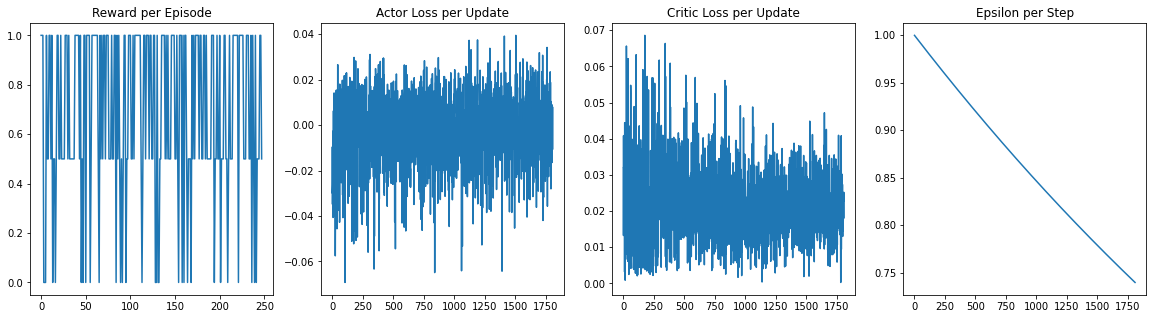

0
0
1
1
1
2
2
1
2
2
--Rx(4.808)----Rz(2.487)----Rx(1.691)----Rz(5.695)--------S------------S--------S----S--------------------------------------
                                                                                                                            
--Ry(0.661)----Rz(1.429)----Ry(5.070)----Rz(4.957)----Ry(2.360)----Rz(1.145)----S----S----Ry(5.151)----Rz(5.736)----S----S--
                                                                                                                            
2
0
1
2
2
2
1
2
2
1
--S----Rx(4.480)----Rz(0.157)----S----S----S--------S------------S------------------------------------------
                                                                                                            
--S----Ry(2.674)----Rz(4.489)----S----S----S----Ry(3.207)----Rz(1.496)----S----S----Ry(3.884)----Rz(4.052)--
                                                                                                            
1
0
0
1
2
0
0
0
0
0
--Rx

1
0
0
0
0
0
1
--Rx(4.425)----Rz(4.330)----Rx(3.857)----Rz(2.977)----Rx(6.040)----Rz(4.931)----Rx(4.552)----Rz(1.377)----Rx(0.303)----Rz(4.358)----Rx(1.826)----Rz(6.182)--
                                                                                                                                                            
--Ry(2.304)----Rz(0.630)----Ry(4.507)----Rz(4.080)----Ry(0.936)----Rz(0.688)----Ry(4.633)----Rz(3.041)------------------------------------------------------
                                                                                                                                                            
0
0
1
1
2
0
2
0
[ 5.00000000e-01-5.00000000e-01j -3.25176795e-17-2.77555756e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(3.579)----Rz(3.161)----Rx(0.343)----Rz(4.438)----S----Rx(0.439)----Rz(3.205)----S----Rx(0.222)----Rz(6.123)--
                                                                                                                  
--Ry(4.653)--

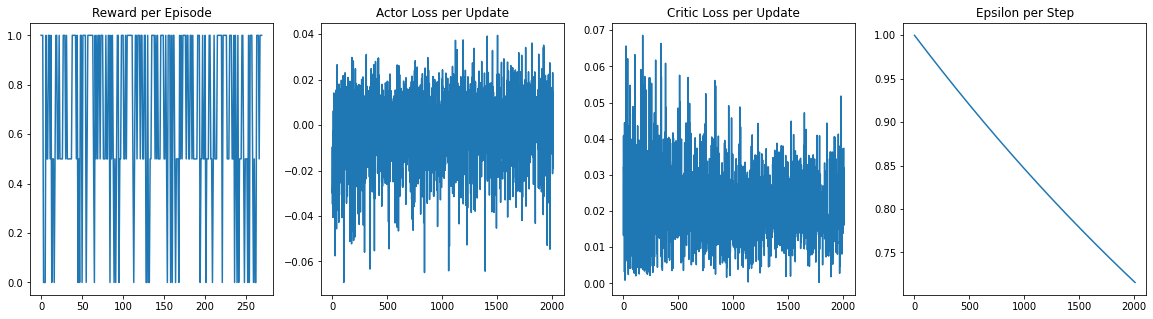

1
2
0
[5.00000000e-01-5.00000000e-01j 2.77555756e-16+1.57009246e-16j
 5.00000000e-01+5.00000000e-01j]
--Rx(2.655)----Rz(3.697)----Rx(4.935)----Rz(2.248)----Rx(3.577)----Rz(2.482)--------S--------Rx(4.088)----Rz(1.089)--
                                                                                                                     
--Ry(5.556)----Rz(1.834)----Ry(2.534)----Rz(2.070)----Ry(0.732)----Rz(0.010)----Ry(3.398)----Rz(6.177)--------S------
                                                                                                                     
0
1
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.434)----Rz(2.351)----S----Rx(3.190)----Rz(3.985)--
                                                         
--Ry(0.498)----Rz(5.939)----S----------------------------
                                                         
1
0
1
1
0
0
2
2
0
0
--Rx(1.385)----Rz(1.930)----Rx(4.100)----Rz(5.343)----Rx(3.053)----

0
0
1
1
2
--Rx(0.639)----Rz(5.746)----Rx(1.728)----Rz(4.429)--------S------------S--------Rx(3.407)----Rz(5.144)----Rx(4.037)----Rz(1.817)----S--
                                                                                                                                       
------S------------S--------Ry(3.578)----Rz(0.051)----Ry(5.833)----Rz(1.516)----Ry(3.308)----Rz(3.775)--------S------------------------
                                                                                                                                       
2
1
2
0
1
[0.5+5.00000000e-01j 0. +7.85046229e-17j 0.5-5.00000000e-01j]
--S--------S--------Rx(2.626)----Rz(1.484)----------------------------
                                                                      
--S----Ry(1.593)----Rz(0.073)--------S--------Ry(5.747)----Rz(1.348)--
                                                                      
0
0
0
0
1
1
1
0
1
0
--Rx(2.279)----Rz(5.718)----Rx(3.359)----Rz(2.639)----Rx(1.209)----Rz(

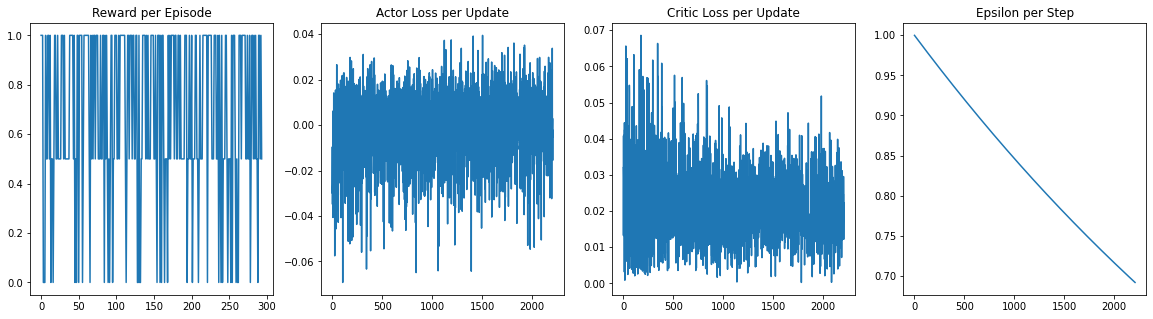

0
--S----Rx(4.293)----Rz(0.452)----Rx(2.264)----Rz(1.101)----Rx(3.055)----Rz(0.874)----Rx(3.620)----Rz(5.464)----Rx(5.367)----Rz(6.001)----Rx(4.380)----Rz(0.754)--
                                                                                                                                                                 
--S----Ry(0.335)----Rz(2.945)----Ry(6.215)----Rz(0.193)----Ry(3.016)----Rz(0.905)--------------------------------------------------------------------------------
                                                                                                                                                                 
0
2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.123)----Rz(0.264)--------S--------Rx(2.830)----Rz(2.973)--
                                                                 
------S--------Ry(0.076)----Rz(5.986)----------------------------
                                             

1
1
2
2
1
0
--S----S----S----S--------S------------S--------Rx(5.565)----Rz(0.453)--------------------------------------
                                                                                                            
--S----S----S----S----Ry(4.063)----Rz(5.995)----Ry(3.050)----Rz(3.308)----S----S----Ry(3.808)----Rz(5.756)--
                                                                                                            
1
0
0
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.082)----Rz(4.258)----Rx(6.088)----Rz(0.471)--------S------
                                                                 
--Ry(5.328)----Rz(3.761)--------S--------Ry(1.440)----Rz(0.098)--
                                                                 
1
1
0
2
0
[-5.00000000e-01+5.00000000e-01j -1.11022302e-16-1.89526925e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(3.137)----Rz(6.252)--------S--------Rx(2.579)----Rz(1.756)--
    

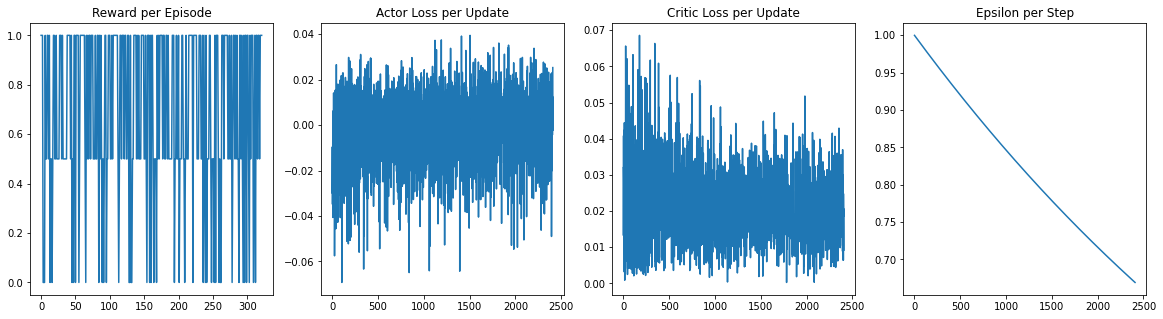

1
1
0
1
1
0
1
0
2
2
--Rx(4.668)----Rz(3.103)----Rx(3.802)----Rz(4.437)----Rx(5.549)----Rz(1.403)--------S------------S------------------------------------------
                                                                                                                                            
--Ry(4.426)----Rz(0.544)----Ry(1.955)----Rz(1.440)----Ry(5.006)----Rz(1.798)----Ry(1.991)----Rz(1.320)----Ry(3.570)----Rz(2.890)----S----S--
                                                                                                                                            
0
0
0
0
2
2
1
0
0
0
--Rx(2.204)----Rz(0.376)----Rx(0.083)----Rz(5.528)----Rx(0.746)----Rz(1.443)----Rx(2.360)----Rz(5.532)----S----S----Rx(6.119)----Rz(3.738)----Rx(3.159)----Rz(4.514)----Rx(5.012)----Rz(1.661)--
                                                                                                                                                                                                
------S---

[-0.5-5.00000000e-01j  0. -7.85046229e-17j -0.5+5.00000000e-01j]
--Rx(5.192)----Rz(0.142)--------S--------Rx(5.854)----Rz(5.759)----S----S----S----Rx(4.601)----Rz(2.463)--
                                                                                                          
--Ry(4.666)----Rz(3.556)----Ry(5.624)----Rz(3.352)--------S--------S----S----S----------------------------
                                                                                                          
2
0
0
2
0
0
0
1
0
0
--S----Rx(0.597)----Rz(2.276)----Rx(5.379)----Rz(0.648)----S----Rx(3.927)----Rz(1.048)----Rx(0.701)----Rz(5.704)----Rx(4.882)----Rz(3.065)----Rx(4.213)----Rz(0.997)----Rx(2.708)----Rz(6.229)--
                                                                                                                                                                                                
--S--------S--------Ry(1.056)----Rz(2.249)-----------------------------------------------------------

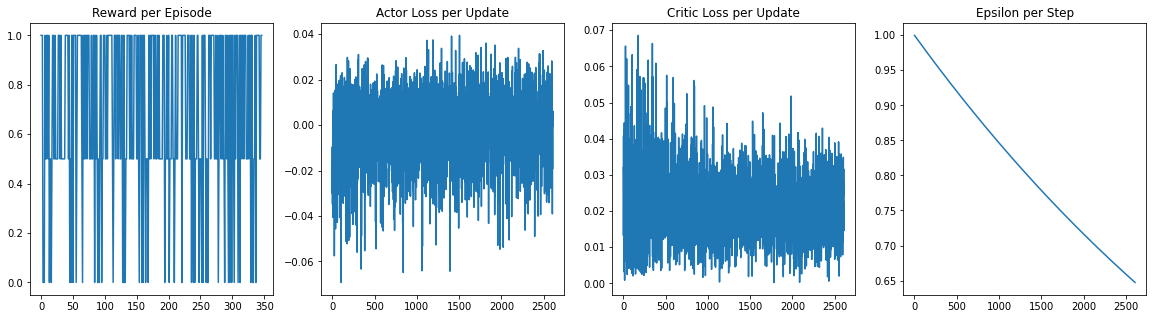

0
0
1
0
1
0
1
------S------------S--------Rx(0.239)----Rz(3.916)----Rx(4.420)----Rz(3.085)----Rx(1.926)----Rz(2.654)----Rx(5.721)----Rz(1.121)--
                                                                                                                                  
--Ry(4.789)----Rz(6.077)--------S------------S--------Ry(0.374)----Rz(4.492)----Ry(1.742)----Rz(3.065)----Ry(4.927)----Rz(2.279)--
                                                                                                                                  
2
2
0
1
1
2
0
[-5.00000000e-01-5.0000000e-01j -5.55111512e-17-1.3738309e-16j
 -5.00000000e-01+5.0000000e-01j]
--S----S----Rx(3.614)----Rz(2.109)--------S--------Rx(0.052)----Rz(3.085)--
                                                                           
--S----S----Ry(6.112)----Rz(6.063)----Ry(3.942)----Rz(4.879)--------S------
                                                                           
1
0
1
1
1
1
1
0
1
1
--Rx(2.478)----Rz(0.275)----

0
0
0
1
0
2
0
[-0.5+5.00000000e-01j  0. -1.34015774e-16j -0.5-5.00000000e-01j]
--Rx(4.493)----Rz(3.895)----Rx(6.008)----Rz(0.641)----Rx(4.558)----Rz(3.951)----Rx(0.834)----Rz(0.543)----Rx(1.530)----Rz(0.451)----S----Rx(5.090)----Rz(5.045)--
                                                                                                                                                                 
--Ry(2.349)----Rz(3.909)----Ry(4.941)----Rz(3.402)--------S------------------------------------------------------------------------------------------------------
                                                                                                                                                                 
2
0
1
2
0
[5.00000000e-01+5.00000000e-01j 5.55111512e-17+9.81307787e-17j
 5.00000000e-01-5.00000000e-01j]
--S----Rx(5.407)----Rz(2.443)----S----Rx(6.148)----Rz(3.558)--
                                                              
--S----Ry(1.697)----Rz(4.597)----S-------

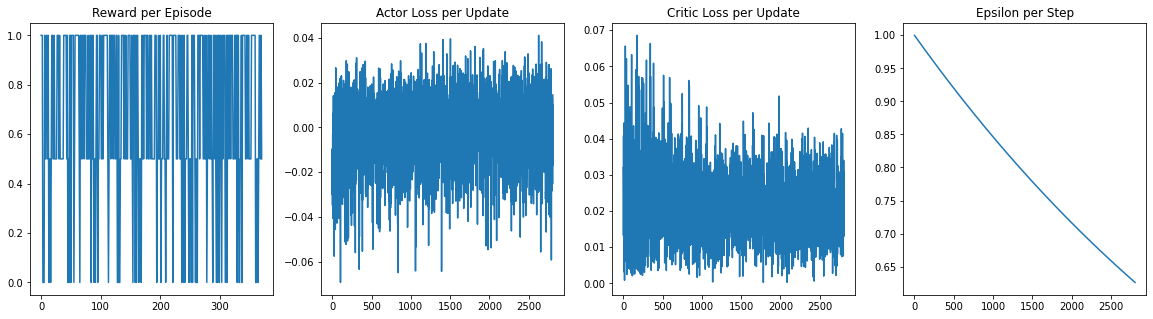

0
1
2
1
[-5.00000000e-01+5.00000000e-01j  3.25176795e-17+1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.281)----Rz(2.778)----Rx(0.504)----Rz(5.190)--------S------
                                                                 
--Ry(4.506)----Rz(2.823)--------S--------Ry(4.827)----Rz(5.538)--
                                                                 
1
0
2
1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(5.058)----Rz(4.551)----S----------------------------
                                                         
--Ry(4.532)----Rz(6.283)----S----Ry(0.801)----Rz(6.063)--
                                                         
2
0
1
0
0
1
0
1
1
1
--S----Rx(3.717)----Rz(1.378)----Rx(3.691)----Rz(1.627)----Rx(0.461)----Rz(3.730)----Rx(3.204)----Rz(5.696)----------------------------
                                                                                                                                      

2
0
1
1
0
0
2
1
------S--------Rx(0.376)----Rz(2.808)----Rx(5.827)----Rz(0.798)----Rx(2.077)----Rz(3.509)--------S--------------------------------------------------
                                                                                                                                                    
--Ry(0.428)----Rz(1.153)----Ry(2.268)----Rz(4.411)--------S--------Ry(5.048)----Rz(1.664)----Ry(5.700)----Rz(1.782)----S----Ry(3.098)----Rz(4.604)--
                                                                                                                                                    
1
0
0
0
1
2
1
2
2
2
--Rx(4.911)----Rz(0.767)----Rx(3.512)----Rz(0.045)----Rx(4.095)----Rz(1.920)--------S--------S----S----S--
                                                                                                          
--Ry(0.058)----Rz(0.111)----Ry(3.314)----Rz(0.845)--------S--------Ry(0.362)----Rz(4.121)----S----S----S--
                                               

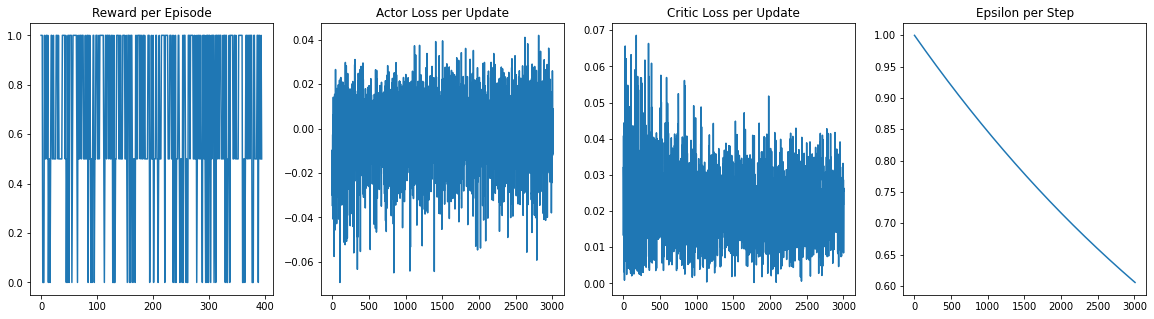

1
1
2
0
2
1
1
------S------------S--------S----Rx(6.261)----Rz(4.721)--------S----------------------------------------------------------------------------------------------
                                                                                                                                                              
--Ry(0.242)----Rz(3.481)----S--------S--------Ry(1.137)----Rz(1.723)----Ry(3.896)----Rz(0.693)----S----S----Ry(1.197)----Rz(3.955)----Ry(3.645)----Rz(4.542)--
                                                                                                                                                              
1
2
2
1
1
1
2
2
1
1
------S------------S--------S----S----------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                         

0
--Rx(6.183)----Rz(3.656)----Rx(6.212)----Rz(2.284)----Rx(3.177)----Rz(2.517)----Rx(5.906)----Rz(4.774)----Rx(2.398)----Rz(5.098)--
                                                                                                                                  
--Ry(4.508)----Rz(4.820)----Ry(0.296)----Rz(3.541)----Ry(2.111)----Rz(3.888)----Ry(3.602)----Rz(1.632)----Ry(3.413)----Rz(4.480)--
                                                                                                                                  
1
0
1
2
2
2
0
1
1
0
--Rx(1.067)----Rz(1.240)--------S------------S--------S----Rx(2.742)----Rz(3.943)----Rx(0.664)----Rz(5.588)----------------------------
                                                                                                                                       
--Ry(2.577)----Rz(4.417)----Ry(0.824)----Rz(2.217)----S--------S------------S--------Ry(3.442)----Rz(2.618)----Ry(0.187)----Rz(4.957)--
                                              

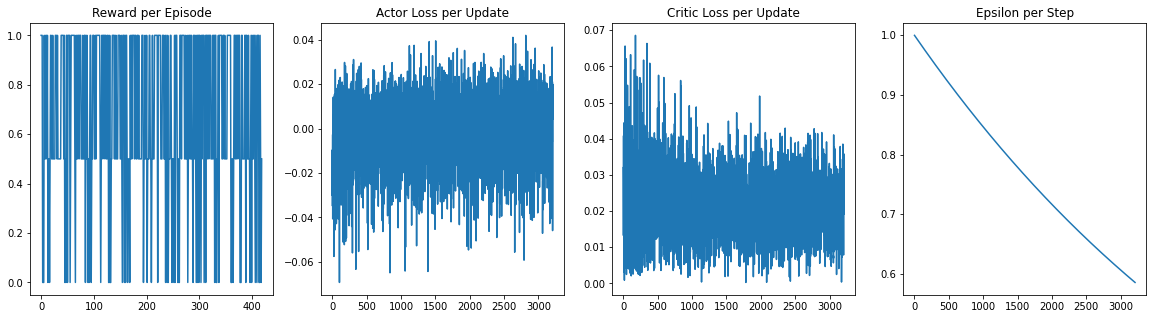

0
0
2
1
1
0
[ 5.00000000e-01+5.00000000e-01j -5.55111512e-17+7.85046229e-17j
  5.00000000e-01-5.00000000e-01j]
--Rx(4.289)----Rz(4.344)----Rx(2.293)----Rz(4.504)----Rx(3.958)----Rz(5.641)----Rx(5.885)----Rz(4.921)----Rx(5.861)----Rz(4.377)----S----Rx(0.444)----Rz(0.813)--
                                                                                                                                                                 
------S--------Ry(2.433)----Rz(1.730)----Ry(5.131)----Rz(0.533)--------------------------------------------------------------------------------------------------
                                                                                                                                                                 
1
2
2
2
0
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-1.66533454e-16j
 -5.00000000e-01+5.00000000e-01j]
------S------------S--------S----Rx(0.945)----Rz(4.173)----------------------------
                                              

--Rx(3.834)----Rz(3.772)----Rx(3.425)----Rz(3.834)----Rx(1.928)----Rz(1.962)--------S--------Rx(2.679)----Rz(1.315)--
                                                                                                                     
--Ry(4.117)----Rz(3.756)--------S--------Ry(3.234)----Rz(3.873)----Ry(1.564)----Rz(4.905)----------------------------
                                                                                                                     
2
0
1
0
2
1
2
2
2
0
--S----Rx(1.562)----Rz(5.896)----Rx(2.765)----Rz(1.247)--------S--------S----S----S----Rx(3.706)----Rz(1.180)--
                                                                                                               
--S----Ry(2.724)----Rz(2.861)--------S--------Ry(1.646)----Rz(2.667)----S----S----S----------------------------
                                                                                                               
1
2
2
1
2
1
2
0
0
1
[-0.5+5.00000000e-01j  0. +7.85046229e-1

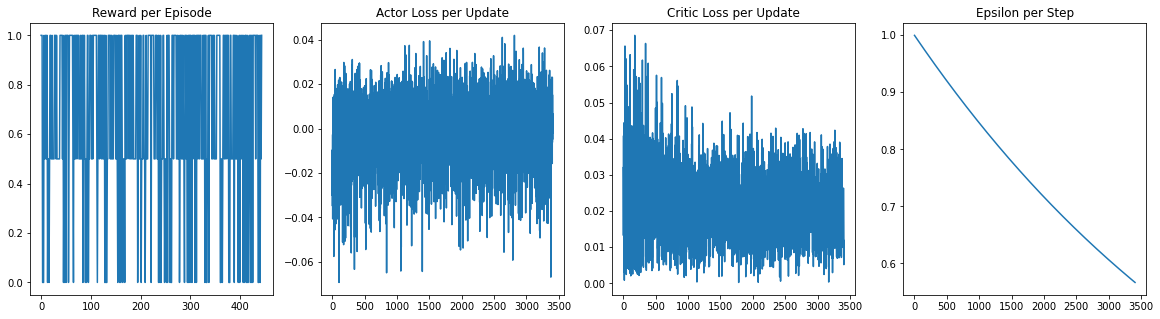

0
--Rx(5.227)----Rz(0.325)----Rx(3.334)----Rz(2.099)----Rx(0.304)----Rz(2.732)----Rx(0.115)----Rz(1.916)------------------------------------------------------
                                                                                                                                                            
--Ry(4.994)----Rz(2.569)----Ry(1.346)----Rz(5.907)----Ry(1.403)----Rz(2.270)----Ry(5.126)----Rz(5.402)----Ry(0.347)----Rz(2.296)----Ry(1.094)----Rz(5.466)--
                                                                                                                                                            
1
1
2
1
2
2
0
1
2
1
------S------------S------------S--------Rx(3.573)----Rz(1.631)--------S--------------------------------------------------------------------------------------
                                                                                                                                                              
--Ry(2.013)----Rz(5.334)----Ry(1

1
2
0
1
2
0
[-5.00000000e-01+0.5j  5.55111512e-17+0.j  -5.00000000e-01-0.5j]
------S--------Rx(0.153)----Rz(2.147)--------S--------Rx(4.302)----Rz(1.870)--------------------
                                                                                                
--Ry(0.910)----Rz(5.019)----Ry(2.164)----Rz(3.283)--------S--------Ry(1.335)----Rz(1.902)----S--
                                                                                                
0
1
1
1
1
2
0
[-0.5-5.00000000e-01j  0. -5.88784672e-17j -0.5+5.00000000e-01j]
--Rx(2.784)----Rz(4.446)--------S--------Rx(5.707)----Rz(3.306)----------------------------------------------
                                                                                                             
--Ry(6.024)----Rz(4.643)----Ry(0.776)----Rz(1.437)----Ry(4.471)----Rz(1.380)----Ry(2.281)----Rz(5.806)----S--
                                                                                                             
0
1
0
0
2
0
[-5.

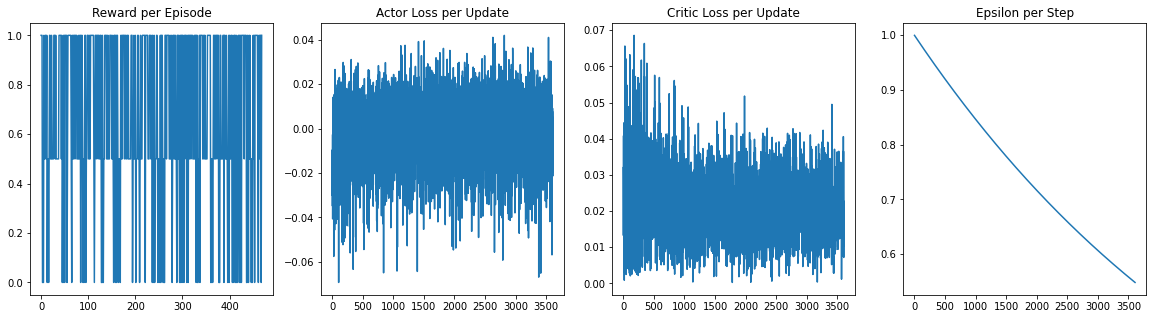

1
0
1
2
0
1
1
1
2
0
[ 5.00000000e-01+5.00000000e-01j -1.57009246e-16-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(4.184)----Rz(1.613)--------S--------Rx(5.406)----Rz(0.072)--------S--------Rx(3.992)----Rz(3.132)----------------------------------------------
                                                                                                                                                    
--Ry(4.652)----Rz(3.092)----Ry(3.311)----Rz(4.574)--------S--------Ry(3.772)----Rz(6.160)----Ry(5.345)----Rz(3.871)----Ry(2.501)----Rz(1.545)----S--
                                                                                                                                                    
0
1
0
1
2
1
[5.00000000e-01+5.00000000e-01j 5.55111512e-17-3.25176795e-17j
 5.00000000e-01-5.00000000e-01j]
--Rx(2.868)----Rz(0.267)----Rx(2.739)----Rz(4.821)----S----------------------------
                                                                                   
--Ry(5.90

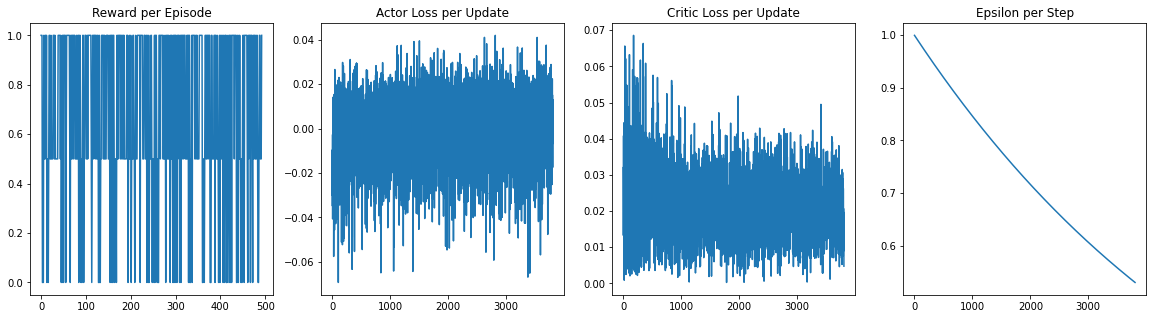

0
0
0
1
0
2
0
2
2
1
--Rx(2.141)----Rz(1.353)----Rx(2.076)----Rz(2.526)----Rx(0.573)----Rz(3.346)----Rx(5.582)----Rz(4.232)----S----Rx(5.330)----Rz(3.370)----S----S--
                                                                                                                                                 
--Ry(1.267)----Rz(2.128)--------S------------S------------S--------Ry(0.409)----Rz(3.084)--------------------------------------------------------
                                                                                                                                                 
0
1
1
1
2
0
[ 5.0000000e-01-5.00000000e-01j  1.3738309e-16-5.55111512e-17j
 -5.0000000e-01-5.00000000e-01j]
--Rx(0.268)----Rz(5.920)--------S--------Rx(5.368)----Rz(6.229)--------------------
                                                                                   
--Ry(6.183)----Rz(3.041)----Ry(1.815)----Rz(3.480)----Ry(2.211)----Rz(0.906)----S--
                                    

0
--Rx(2.237)----Rz(1.909)----Rx(2.860)----Rz(5.545)----Rx(3.998)----Rz(0.388)----Rx(5.745)----Rz(2.620)----Rx(5.883)----Rz(1.533)----S----S----Rx(1.622)----Rz(2.457)----Rx(1.711)----Rz(4.192)--
                                                                                                                                                                                                
--Ry(0.093)----Rz(5.945)--------S------------S--------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                
1
1
1
1
0
0
0
1
1
0
--Rx(2.133)----Rz(4.679)----Rx(1.049)----Rz(3.166)----Rx(1.822)----Rz(5.175)----Rx(2.843)----Rz(3.064)------------------------------------------------------
                                                 

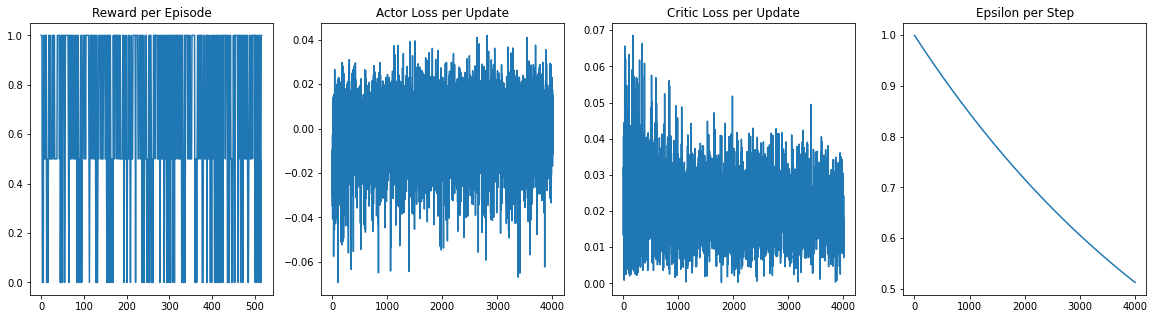

0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(1.703)----Rz(5.057)----S----Rx(3.590)----Rz(5.066)--
                                                         
------S--------------------------------------------------
                                                         
2
1
2
0
2
0
0
1
1
2
--S--------S--------Rx(2.310)----Rz(5.021)----S----Rx(4.836)----Rz(3.768)----Rx(0.196)----Rz(4.100)----S--
                                                                                                          
--S----Ry(0.264)----Rz(2.855)--------S--------S----Ry(1.092)----Rz(0.083)----Ry(3.572)----Rz(6.245)----S--
                                                                                                          
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                        

0
1
0
1
1
1
--Rx(3.376)----Rz(4.076)----S----S----Rx(3.875)----Rz(0.320)----Rx(0.725)----Rz(5.770)------------------------------------------------------
                                                                                                                                            
--Ry(1.691)----Rz(1.340)----S----S----Ry(6.084)----Rz(1.050)----Ry(3.604)----Rz(2.063)----Ry(3.187)----Rz(5.352)----Ry(2.214)----Rz(1.597)--
                                                                                                                                            
2
1
2
0
2
1
0
1
1
1
--S--------S--------Rx(3.676)----Rz(4.478)----S----Rx(1.374)----Rz(3.172)--------------------------------------------------------------------------------
                                                                                                                                                         
--S----Ry(3.404)----Rz(0.938)--------S--------S----Ry(0.912)----Rz(5.548)----Ry(0.233)----Rz(4.6

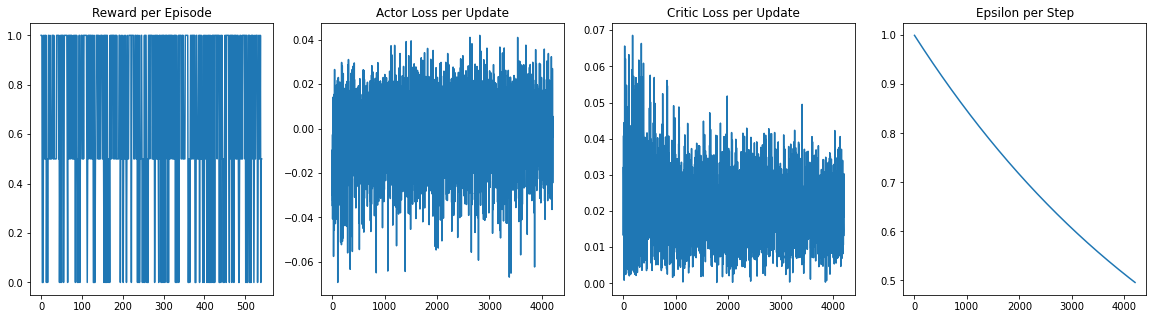

0
1
1
2
--S----S----S----Rx(3.979)----Rz(0.847)----Rx(2.410)----Rz(2.077)----Rx(0.328)----Rz(2.531)----S--
                                                                                                  
--S----S----S----Ry(1.490)----Rz(3.174)----Ry(6.116)----Rz(3.655)----Ry(2.921)----Rz(6.203)----S--
                                                                                                  
1
1
2
0
0
0
0
2
0
0
------S--------Rx(3.034)----Rz(2.536)----Rx(4.434)----Rz(5.598)----Rx(1.048)----Rz(1.526)----Rx(4.408)----Rz(3.180)----S----Rx(1.545)----Rz(5.134)----Rx(1.272)----Rz(2.092)--
                                                                                                                                                                              
--Ry(5.240)----Rz(5.943)----Ry(4.158)----Rz(2.622)--------S------------S------------------------------------------------------------------------------------------------------
                                                   

0
1
2
2
2
1
2
0
0
1
--Rx(3.865)----Rz(2.489)----S----S----S--------S--------Rx(0.550)----Rz(3.933)----Rx(4.720)----Rz(0.384)--
                                                                                                          
--Ry(3.750)----Rz(3.167)----S----S----S----Ry(0.817)----Rz(0.208)--------S--------Ry(1.981)----Rz(5.944)--
                                                                                                          
1
1
2
0
2
2
0
2
0
0
------S--------Rx(6.150)----Rz(5.740)--------S--------S----Rx(4.540)----Rz(2.234)----S----Rx(5.527)----Rz(3.703)----Rx(4.149)----Rz(5.967)--
                                                                                                                                            
--Ry(4.218)----Rz(5.590)----Ry(5.356)----Rz(2.116)----S--------S------------S--------S------------------------------------------------------
                                                                                                             

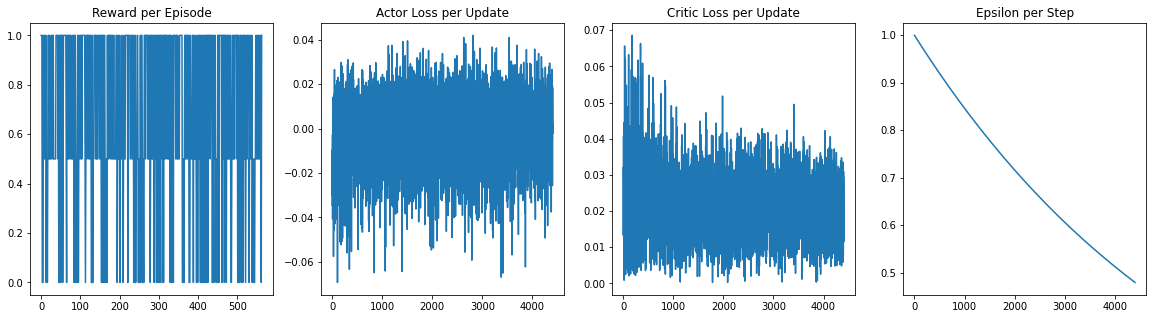

2
0
--Rx(0.060)----Rz(0.366)----Rx(4.881)----Rz(1.820)--------S--------Rx(5.116)----Rz(5.356)----S----Rx(1.869)----Rz(1.152)----S----Rx(5.333)----Rz(3.718)--
                                                                                                                                                         
--Ry(2.469)----Rz(4.972)--------S--------Ry(4.358)----Rz(4.343)--------S------------S--------------------------------------------------------------------
                                                                                                                                                         
2
1
1
1
0
0
0
1
0
1
--S----Rx(0.733)----Rz(0.720)----Rx(3.961)----Rz(5.720)----Rx(4.870)----Rz(1.304)----Rx(1.566)----Rz(5.837)----------------------------
                                                                                                                                       
--S----Ry(4.318)----Rz(4.477)----Ry(1.279)----Rz(0.521)----Ry(1.593)----Rz(3.569)----Ry(

1
0
1
0
0
0
1
0
--S----Rx(4.908)----Rz(3.239)----Rx(2.043)----Rz(2.350)----Rx(3.491)----Rz(0.212)----Rx(0.954)----Rz(3.459)----Rx(1.402)----Rz(3.346)--
                                                                                                                                       
--S----Ry(2.303)----Rz(0.823)----Ry(1.293)----Rz(6.267)----Ry(1.371)----Rz(2.953)----Ry(0.049)----Rz(4.113)----------------------------
                                                                                                                                       
1
1
0
0
1
2
2
2
2
1
--Rx(6.013)----Rz(2.070)----Rx(1.794)----Rz(3.003)--------S------------S--------S----S--------------------------------------
                                                                                                                            
--Ry(5.229)----Rz(1.711)----Ry(6.230)----Rz(1.255)----Ry(2.711)----Rz(4.072)----S----S----S----S----Ry(3.660)----Rz(1.917)--
                                             

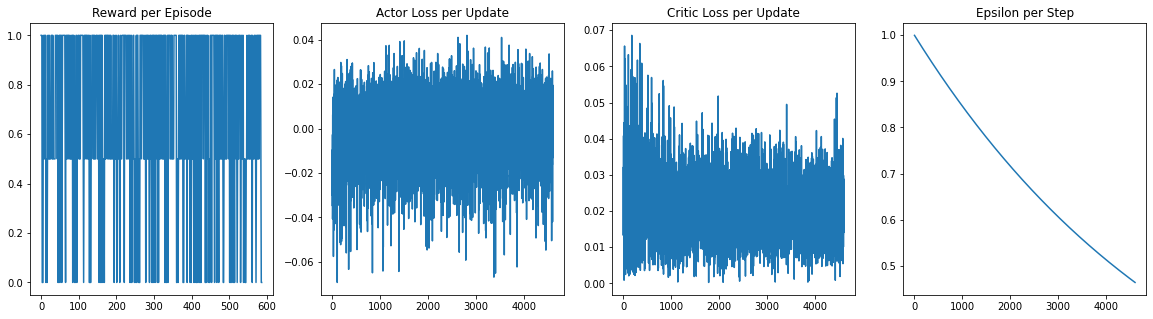

0
2
0
[5.00000000e-01-5.00000000e-01j 1.66533454e-16+7.85046229e-17j
 5.00000000e-01+5.00000000e-01j]
--Rx(4.942)----Rz(1.578)----Rx(3.705)----Rz(5.623)----Rx(3.046)----Rz(4.661)----S----Rx(0.593)----Rz(0.134)--
                                                                                                             
------S------------------------------------------------------------------------------------------------------
                                                                                                             
1
2
0
1
[-5.00000000e-01+0.5j -7.85046229e-17+0.j   5.00000000e-01+0.5j]
------S--------Rx(5.314)----Rz(0.286)----------------------------
                                                                 
--Ry(5.232)----Rz(3.445)--------S--------Ry(3.836)----Rz(5.829)--
                                                                 
1
0
2
1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(3.289)---

0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(4.481)----Rz(5.188)----S----Rx(6.210)----Rz(5.572)--
                                                         
--Ry(3.107)----Rz(1.990)----S----------------------------
                                                         
1
0
0
1
2
0
0
0
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(6.255)----Rz(0.871)----Rx(4.949)----Rz(5.089)----S----Rx(2.309)----Rz(3.148)----Rx(5.671)----Rz(0.803)----Rx(5.563)----Rz(3.054)----S----Rx(1.804)----Rz(0.298)--
                                                                                                                                                                      
--Ry(6.209)----Rz(2.747)----Ry(3.971)----Rz(6.217)----S--------S------------------------------------------------------------------------------------------------------
                                               

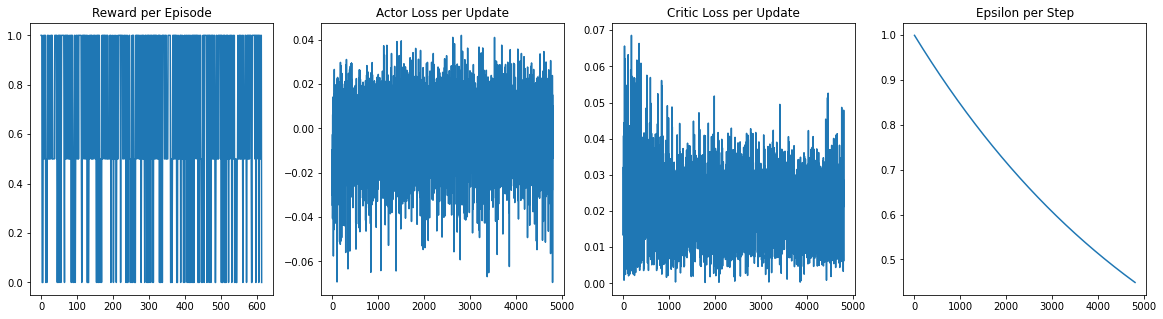

2
2
--S----S----Rx(0.298)----Rz(0.847)----Rx(0.812)----Rz(5.715)----Rx(3.787)----Rz(1.494)----S----S--
                                                                                                  
--S----S----Ry(4.431)----Rz(5.267)----Ry(2.048)----Rz(3.092)----Ry(1.338)----Rz(6.264)----S----S--
                                                                                                  
0
1
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.993)----Rz(4.282)----S----Rx(0.113)----Rz(2.264)--
                                                         
--Ry(0.820)----Rz(5.729)----S----------------------------
                                                         
0
1
0
2
1
0
1
1
0
1
--Rx(2.909)----Rz(3.023)----Rx(2.319)----Rz(3.226)--------S--------Rx(3.060)----Rz(2.669)----Rx(4.121)----Rz(2.895)----------------------------
                                                                                                 

1
0
1
0
1
--Rx(5.430)----Rz(1.507)----Rx(1.338)----Rz(4.612)----Rx(3.019)----Rz(1.496)----Rx(2.053)----Rz(2.297)------------------------------------------------------
                                                                                                                                                            
--Ry(2.908)----Rz(1.003)----Ry(5.380)----Rz(0.899)----Ry(6.258)----Rz(5.064)----Ry(5.934)----Rz(1.728)----Ry(0.503)----Rz(3.704)----Ry(4.018)----Rz(3.635)--
                                                                                                                                                            
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(5.489)----Rz(0.364)----S----Ry(1.241)----Rz(0.943)--
                                                         
1
2
2
2
2
0
1
0
2
1
-----

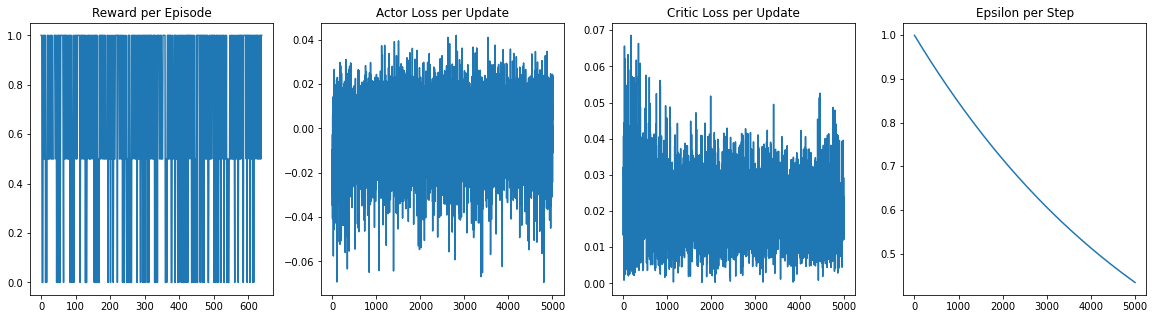

2
2
0
--Rx(2.128)----Rz(2.425)----Rx(4.174)----Rz(3.875)----Rx(1.239)----Rz(3.472)--------S------------S--------Rx(4.796)----Rz(2.736)--
                                                                                                                                  
--Ry(0.332)----Rz(1.916)----Ry(2.715)----Rz(0.790)----Ry(1.045)----Rz(2.389)----Ry(3.402)----Rz(2.482)--------S------------S------
                                                                                                                                  
0
1
2
1
1
2
0
1
2
2
--Rx(1.516)----Rz(0.404)----S--------S--------Rx(4.750)----Rz(1.215)--------S--------S--------------------------------------
                                                                                                                            
--Ry(0.777)----Rz(5.458)----S----Ry(2.493)----Rz(5.570)----Ry(5.831)----Rz(2.771)----S----Ry(4.854)----Rz(1.114)----S----S--
                                                                           

--S----S--------S--------Rx(1.220)----Rz(4.182)----Rx(2.583)----Rz(1.393)--------S------------------------------------------
                                                                                                                            
--S----S----Ry(6.248)----Rz(3.122)----Ry(6.090)----Rz(3.568)----Ry(0.712)----Rz(3.812)----Ry(3.191)----Rz(1.788)----S----S--
                                                                                                                            
0
0
1
0
1
0
2
0
[ 5.00000000e-01-5.00000000e-01j -3.25176795e-17-2.22044605e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(5.261)----Rz(2.214)----Rx(4.554)----Rz(5.654)----Rx(2.880)----Rz(4.734)----Rx(0.759)----Rz(5.515)----S----Rx(5.000)----Rz(3.962)--
                                                                                                                                       
--Ry(1.551)----Rz(5.375)----Ry(2.810)----Rz(1.678)--------S------------------------------------------------------

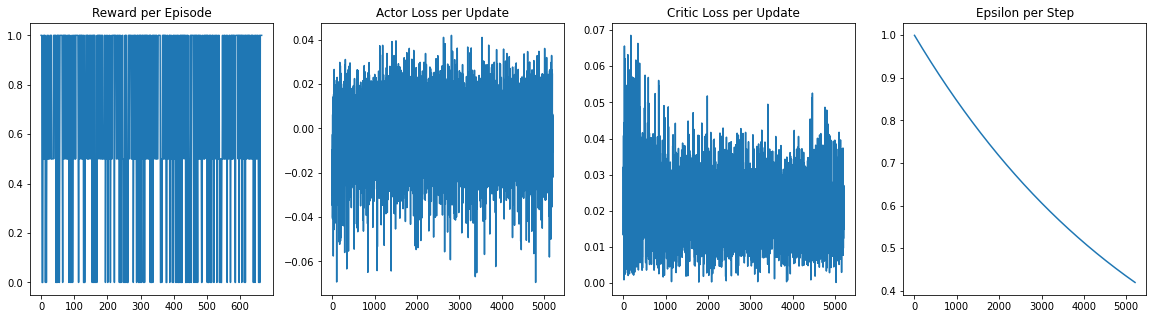

0
1
1
2
2
2
2
1
0
0
--Rx(4.796)----Rz(2.983)--------S------------S--------S----S----Rx(0.240)----Rz(0.187)----Rx(4.836)----Rz(1.775)--
                                                                                                                  
--Ry(4.137)----Rz(4.383)----Ry(2.060)----Rz(3.610)----S----S--------S------------S--------Ry(3.027)----Rz(5.252)--
                                                                                                                  
0
0
1
1
2
1
1
2
0
2
--Rx(1.590)----Rz(6.276)----Rx(3.897)----Rz(0.962)----S--------S--------Rx(4.235)----Rz(4.012)--------S----------------
                                                                                                                       
--Ry(1.609)----Rz(4.184)----Ry(6.240)----Rz(0.136)----S----Ry(3.375)----Rz(2.021)----Ry(3.053)----Rz(2.104)----S----S--
                                                                                                                       
2
0
1
1
2
2
2
1
0
[ 

--Rx(1.467)----Rz(4.913)--------S------------S--------S--------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                           
--Ry(0.997)----Rz(5.008)----Ry(2.891)----Rz(3.595)----S----Ry(1.413)----Rz(2.937)----Ry(1.347)----Rz(6.110)----Ry(0.424)----Rz(2.927)----Ry(2.393)----Rz(4.551)----S----S--
                                                                                                                                                                           
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(6.065)----Rz(0.000)----S----Rx(2.652)----Rz(4.354)--
                                                         
------S--------------------------------------------------
                                 

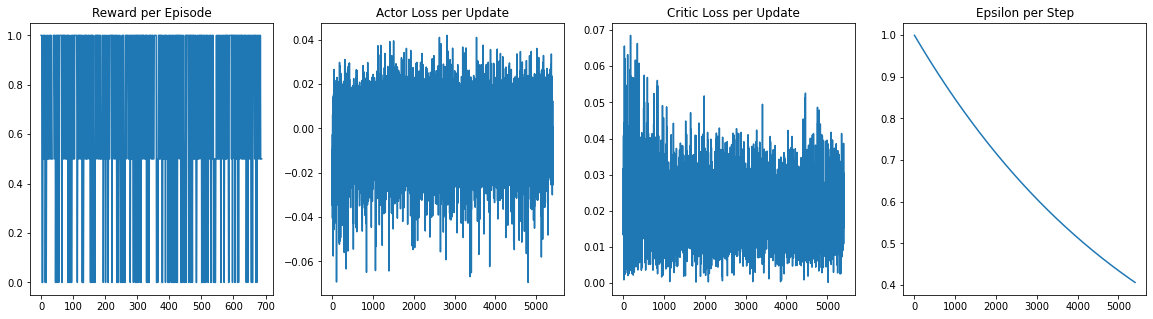

1
2
1
[-5.00000000e-01+5.00000000e-01j  5.55111512e-17+7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--S--------S--------------------------------------------------
                                                              
--S----Ry(0.837)----Rz(4.802)----S----Ry(1.571)----Rz(5.364)--
                                                              
1
0
0
0
1
1
2
1
[-5.00000000e-01-5.00000000e-01j -1.66533454e-16-1.96261557e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.613)----Rz(6.090)----Rx(4.752)----Rz(5.448)----Rx(5.951)----Rz(2.397)----S----------------------------
                                                                                                             
--Ry(5.895)----Rz(4.386)----Ry(4.659)----Rz(1.736)----Ry(1.419)----Rz(5.834)----S----Ry(3.877)----Rz(4.618)--
                                                                                                             
0
0
0
1
1
1
1
1
0
1
--Rx(4.394)----Rz(1.342)----Rx(0.906)----Rz(3.461)----Rx(2.314)----R

1
2
0
0
2
0
2
0
0
2
------S--------Rx(4.393)----Rz(0.213)----Rx(0.591)----Rz(4.484)----S----Rx(3.282)----Rz(5.367)----S----Rx(4.672)----Rz(5.058)----Rx(2.423)----Rz(3.400)----S--
                                                                                                                                                              
--Ry(5.828)----Rz(5.222)--------S------------S------------S--------S------------------------------------------------------------------------------------------
                                                                                                                                                              
0
0
2
1
1
0
0
2
1
1
--Rx(4.028)----Rz(2.703)----Rx(5.397)----Rz(4.427)--------S--------Rx(3.619)----Rz(0.280)----Rx(1.124)----Rz(2.709)--------S------
                                                                                                                                  
------S--------Ry(3.891)----Rz(5.067)----Ry(1.911)----Rz(2.700

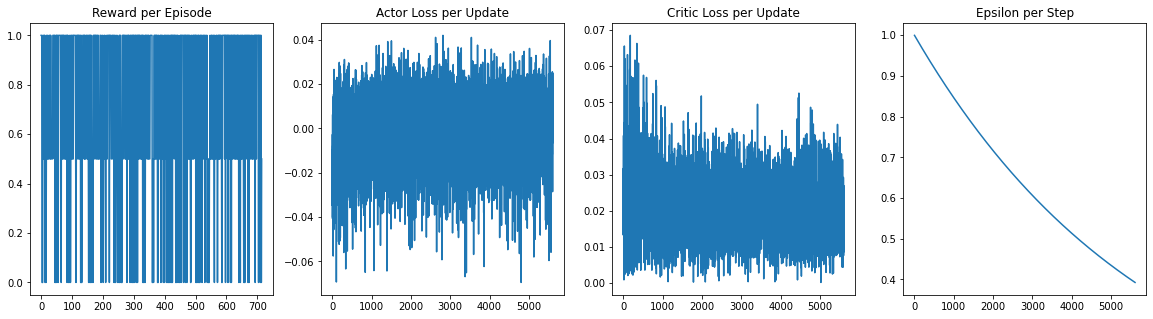

1
0
1
1
1
0
0
0
2
2
--Rx(3.519)----Rz(6.128)----Rx(4.454)----Rz(2.609)----Rx(2.226)----Rz(2.674)----Rx(4.060)----Rz(3.779)----S----S--
                                                                                                                  
--Ry(1.023)----Rz(1.155)----Ry(1.379)----Rz(6.144)----Ry(4.358)----Rz(0.549)----Ry(6.195)----Rz(2.260)----S----S--
                                                                                                                  
2
1
1
0
0
1
2
1
[0.5-5.00000000e-01j 0. -2.45038077e-16j 0.5+5.00000000e-01j]
--S----Rx(1.035)----Rz(1.146)----Rx(3.801)----Rz(3.053)--------S--------------------------------------------------
                                                                                                                  
--S----Ry(3.551)----Rz(1.202)----Ry(3.677)----Rz(1.790)----Ry(2.051)----Rz(2.993)----S----Ry(5.576)----Rz(0.684)--
                                                                                                 

1
1
2
1
0
1
--S----Rx(3.210)----Rz(2.065)----Rx(5.725)----Rz(6.047)--------S--------Rx(5.146)----Rz(1.955)------------------------------------------------------
                                                                                                                                                    
--S----Ry(5.623)----Rz(5.836)----Ry(1.072)----Rz(2.521)----Ry(1.752)----Rz(5.483)--------S--------Ry(6.047)----Rz(1.299)----Ry(0.372)----Rz(1.342)--
                                                                                                                                                    
0
2
2
1
1
2
1
2
1
2
--Rx(5.137)----Rz(4.560)--------S------------S------------S------------S--------S----------------------------------------------------------------
                                                                                                                                                 
------S------------S--------Ry(3.330)----Rz(1.958)----Ry(1.922)----Rz(3.798)----

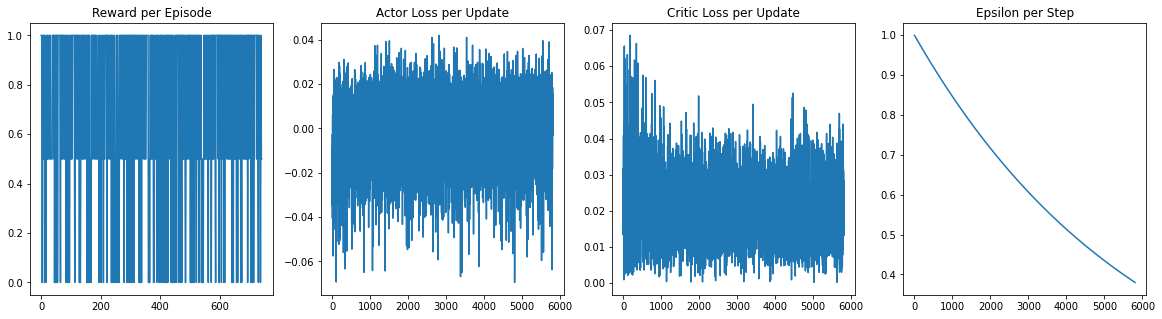

0
0
1
2
2
2
1
[-5.00000000e-01-5.00000000e-01j -1.89526925e-16-1.11022302e-16j
  5.00000000e-01-5.00000000e-01j]
--Rx(0.228)----Rz(1.883)----Rx(4.827)----Rz(1.918)----S--------S------------S------
                                                                                   
--Ry(1.248)----Rz(4.244)--------S------------S--------S----Ry(1.805)----Rz(4.030)--
                                                                                   
2
0
0
0
1
1
2
0
[ 5.00000000e-01+5.00000000e-01j  1.96261557e-17-3.33066907e-16j
 -5.00000000e-01+5.00000000e-01j]
--S----Rx(3.872)----Rz(6.202)----Rx(4.594)----Rz(3.855)----Rx(5.099)----Rz(5.308)----S----Rx(1.100)----Rz(0.874)--
                                                                                                                  
--S----Ry(5.904)----Rz(0.212)----Ry(3.207)----Rz(3.726)--------S--------------------------------------------------
                                                                                           

0
1
2
0
0
0
2
--Rx(1.099)----Rz(3.193)----Rx(3.854)----Rz(3.292)----Rx(0.897)----Rz(5.561)----S----Rx(3.287)----Rz(6.128)----Rx(5.522)----Rz(5.982)----Rx(5.934)----Rz(1.877)----S--
                                                                                                                                                                      
--Ry(2.727)----Rz(5.052)----Ry(4.980)----Rz(4.959)--------S------------S----------------------------------------------------------------------------------------------
                                                                                                                                                                      
1
1
1
1
0
0
2
2
1
2
--Rx(1.342)----Rz(4.022)----Rx(1.328)----Rz(2.385)--------S------------S------------S------------------------------------------------------------
                                                                                                                                                 
--Ry(2

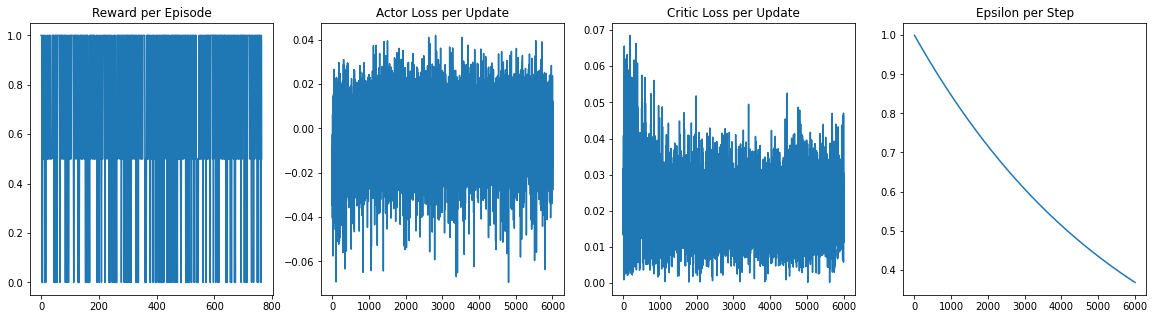

1
1
2
2
0
1
2
--S----S----Rx(4.414)----Rz(0.639)--------S------------S--------Rx(6.063)----Rz(2.296)--------S------------------------
                                                                                                                       
--S----S----Ry(6.152)----Rz(2.181)----Ry(6.265)----Rz(5.123)--------S------------S--------Ry(2.943)----Rz(2.027)----S--
                                                                                                                       
1
1
0
2
1
2
1
0
1
0
--Rx(4.593)----Rz(5.749)--------S------------S--------Rx(3.345)----Rz(1.713)----Rx(2.797)----Rz(1.155)------------------------------------------------------
                                                                                                                                                            
--Ry(4.671)----Rz(1.019)----Ry(1.776)----Rz(3.104)--------S--------Ry(4.535)----Rz(6.247)--------S--------Ry(4.753)----Rz(2.498)----Ry(3.119)----Rz(0.239)--
               

2
0
2
0
[ 5.00000000e-01+0.5j -7.85046229e-17+0.j  -5.00000000e-01+0.5j]
------S--------Rx(6.024)----Rz(5.928)----S--------S--------Rx(3.522)----Rz(5.549)----S----Rx(4.955)----Rz(4.043)--
                                                                                                                  
--Ry(1.739)----Rz(2.928)--------S--------S----Ry(3.676)----Rz(1.623)--------S--------S----------------------------
                                                                                                                  
0
1
0
0
1
0
1
1
1
0
--Rx(3.640)----Rz(3.031)----Rx(4.939)----Rz(1.294)----Rx(1.177)----Rz(3.288)----Rx(1.656)----Rz(6.026)----Rx(4.831)----Rz(5.678)--
                                                                                                                                  
--Ry(0.238)----Rz(0.548)----Ry(5.093)----Rz(4.224)----Ry(5.071)----Rz(3.554)----Ry(1.407)----Rz(2.952)----Ry(1.331)----Rz(2.269)--
                                                      

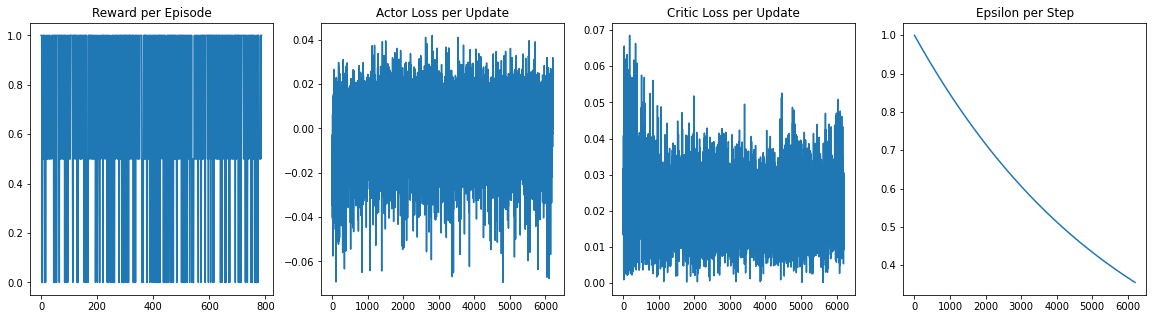

0
0
0
1
[ 5.00000000e-01-5.00000000e-01j  7.85046229e-17+1.11022302e-16j
 -5.00000000e-01-5.00000000e-01j]
------S--------Rx(3.486)----Rz(3.146)----Rx(0.846)----Rz(4.374)----Rx(0.786)----Rz(2.141)--
                                                                                           
--Ry(1.781)----Rz(5.785)--------S--------Ry(3.491)----Rz(1.429)----------------------------
                                                                                           
1
1
1
1
1
2
0
1
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
------S--------Rx(3.239)----Rz(3.492)----------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                 
--Ry(0.459)----Rz(5.794)----Ry(5.318)----Rz(2.164)----Ry(3.598)----Rz(6.043)----Ry(0.6

0
2
1
0
[5.00000000e-01+5.00000000e-01j 1.66533454e-16+7.85046229e-17j
 5.00000000e-01-5.00000000e-01j]
--S--------S--------Rx(0.237)----Rz(2.618)--------S--------Rx(2.505)----Rz(0.471)----------------------------
                                                                                                             
--S----Ry(5.194)----Rz(1.754)----Ry(0.995)----Rz(6.105)--------S------------S--------Ry(3.464)----Rz(5.648)--
                                                                                                             
0
1
2
1
1
1
1
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(0.174)----Rz(4.698)----S----Rx(3.107)----Rz(6.073)--------------------------------------------------------------------------------
                                                                                                                                       
--Ry(4.665)----Rz(1.317)----S----Ry(0.083)----Rz(2.640)----Ry(4.792)-

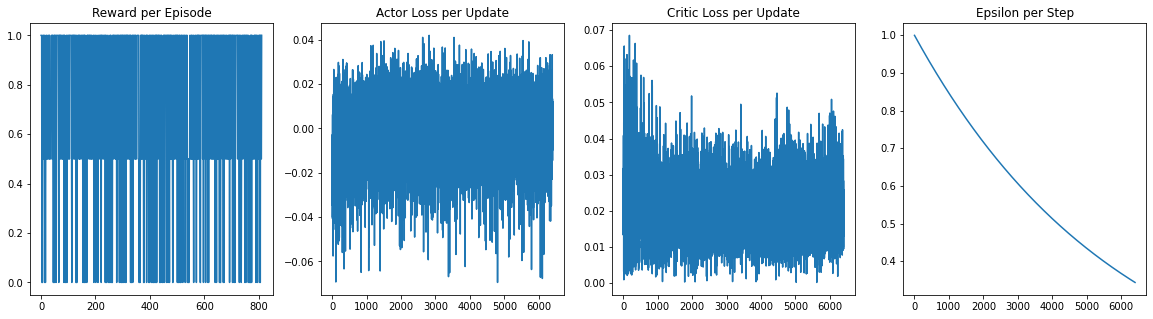

0
0
1
0
2
2
0
0
2
--Rx(0.286)----Rz(2.937)----Rx(1.729)----Rz(3.966)----Rx(5.921)----Rz(3.312)----S----S----Rx(1.978)----Rz(0.781)----Rx(3.406)----Rz(4.336)----S--
                                                                                                                                                 
--Ry(1.395)----Rz(4.293)----Ry(2.346)----Rz(3.940)--------S------------S--------S----------------------------------------------------------------
                                                                                                                                                 
1
1
0
1
0
2
0
1
1
1
--Rx(4.962)----Rz(3.273)----Rx(0.831)----Rz(0.887)--------S--------Rx(5.690)----Rz(0.234)--------------------------------------------------------------------------------
                                                                                                                                                                         
--Ry(0.134)----Rz(4.466)----Ry(0.673)-

0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(1.251)----Rz(4.555)----S----Rx(3.839)----Rz(3.531)--
                                                         
------S--------------------------------------------------
                                                         
0
1
1
0
1
0
2
0
1
[-5.00000000e-01+5.00000000e-01j -1.66533454e-16-7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.524)----Rz(6.136)----Rx(0.417)----Rz(0.805)----Rx(3.942)----Rz(0.120)----S----Rx(0.702)----Rz(5.081)--
                                                                                                             
--Ry(5.494)----Rz(0.216)----Ry(5.129)----Rz(5.474)----Ry(1.375)----Rz(3.334)----S----Ry(3.734)----Rz(1.641)--
                                                                                                             
1
2
0
0
0
0
0
1
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17-5.55111512e-17j
  5.00000000e-01+5.00000000e-

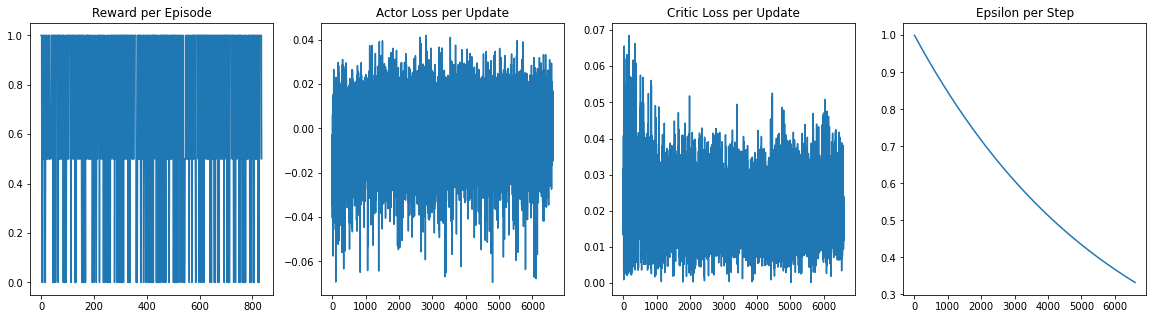

1
0
2
0
1
[-5.00000000e-01-5.00000000e-01j  5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.568)----Rz(1.541)----S----Rx(5.277)----Rz(2.857)--
                                                         
--Ry(5.927)----Rz(1.902)----S----Ry(2.622)----Rz(2.892)--
                                                         
0
1
1
1
1
1
1
2
1
1
--Rx(0.849)----Rz(2.966)--------S------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                     
--Ry(2.162)----Rz(1.289)----Ry(1.716)----Rz(5.080)----Ry(1.756)----Rz(5.283)----Ry(5.544)----Rz(0.026)----Ry(0.612)----Rz(0.771)----Ry(3.174)----Rz(0.848)----S----Ry(3.360)----Rz(3.190)----Ry(5.765)----Rz(4.949)

1
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(4.612)----Rz(2.778)----S----Rx(5.332)----Rz(2.615)--
                                                         
--Ry(5.370)----Rz(1.446)----S----------------------------
                                                         
1
0
0
0
1
1
2
1
[-5.00000000e-01-5.00000000e-01j -1.66533454e-16-1.96261557e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(0.570)----Rz(1.838)----Rx(5.022)----Rz(3.857)----Rx(5.673)----Rz(4.489)----S----------------------------
                                                                                                             
--Ry(4.138)----Rz(4.465)----Ry(5.800)----Rz(1.196)----Ry(1.215)----Rz(5.762)----S----Ry(0.243)----Rz(5.742)--
                                                                                                             
2
2
0
1
2
2
0
0
2
1
--S----S----Rx(6.230)----Rz(2.854)----S----S----Rx(0.791)----Rz(3.171)----Rx(2.543)----R

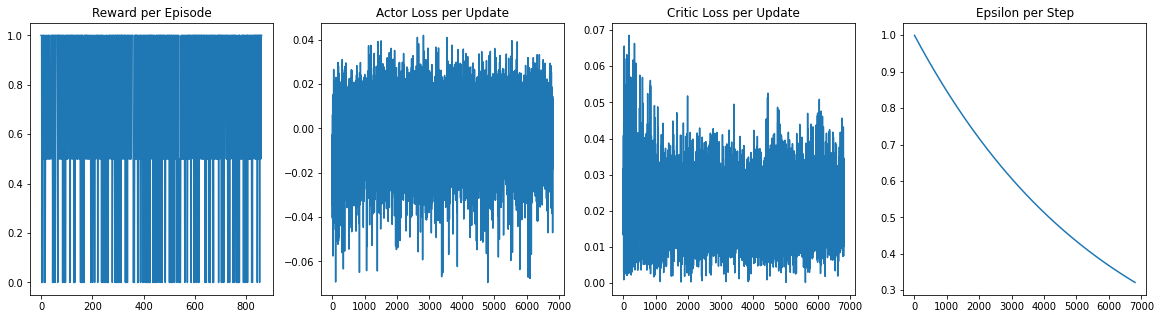

0
2
0
2
--S----Rx(0.884)----Rz(3.483)--------S--------Rx(1.181)----Rz(3.681)--------S--------Rx(4.467)----Rz(3.488)----S--
                                                                                                                  
--S----Ry(4.776)----Rz(3.755)----Ry(1.260)----Rz(1.052)----Ry(0.037)----Rz(3.612)--------S------------S--------S--
                                                                                                                  
1
1
2
1
0
2
2
1
1
1
------S--------Rx(3.511)----Rz(2.467)--------S--------S--------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                           
--Ry(4.657)----Rz(5.824)----Ry(5.179)----Rz(5.720)----S----Ry(0.841)----Rz(1.400)----S----S----Ry(5.650)----Rz(4.794)----Ry(5.829)----Rz(5.242)----Ry(4.469)----Rz(5.298

1
--Rx(4.977)----Rz(1.794)----Rx(4.469)----Rz(1.171)----Rx(2.627)----Rz(2.830)----Rx(1.476)----Rz(2.457)----Rx(5.236)----Rz(3.059)----Rx(5.749)----Rz(0.769)--
                                                                                                                                                            
--Ry(3.553)----Rz(1.239)----Ry(1.390)----Rz(2.360)----Ry(0.824)----Rz(5.288)----Ry(3.036)----Rz(0.743)------------------------------------------------------
                                                                                                                                                            
2
0
2
2
1
1
2
0
[-5.00000000e-01-5.00000000e-01j  7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(6.173)----Rz(2.731)--------S------------S------------S--------Rx(0.203)----Rz(0.726)--
                                                                                                
--S--------S------------S--------Ry(3.242)----Rz(0.008)----Ry

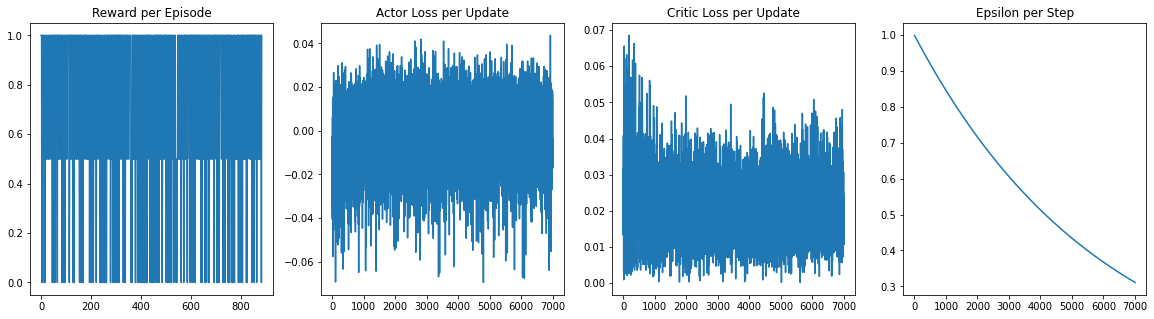

2
0
0
--Rx(3.023)----Rz(4.048)----Rx(1.135)----Rz(2.203)----S----Rx(4.091)----Rz(5.096)----S----Rx(4.979)----Rz(0.985)----Rx(5.299)----Rz(3.582)--
                                                                                                                                            
--Ry(5.304)----Rz(1.014)----Ry(3.116)----Rz(6.167)----S----Ry(3.547)----Rz(0.695)----S------------------------------------------------------
                                                                                                                                            
1
0
0
1
0
2
1
0
[5.00000000e-01+5.00000000e-01j 2.22044605e-16+2.45038077e-16j
 5.00000000e-01-5.00000000e-01j]
--Rx(2.065)----Rz(2.080)----Rx(3.434)----Rz(5.003)----Rx(2.659)----Rz(5.304)--------S--------Rx(5.188)----Rz(3.461)--
                                                                                                                     
--Ry(1.144)----Rz(5.433)----Ry(5.427)----Rz(1.111)--------S--------Ry(5.838)----Rz

0
1
1
0
0
0
1
0
--Rx(0.238)----Rz(2.023)----Rx(2.047)----Rz(2.546)----Rx(5.661)----Rz(3.354)----Rx(2.174)----Rz(3.689)----Rx(0.188)----Rz(1.519)----Rx(0.872)----Rz(3.499)--
                                                                                                                                                            
--Ry(5.269)----Rz(4.816)----Ry(3.325)----Rz(3.971)----Ry(0.319)----Rz(3.051)----Ry(4.663)----Rz(6.253)------------------------------------------------------
                                                                                                                                                            
1
1
0
0
0
0
1
1
2
1
--Rx(5.838)----Rz(5.647)----Rx(3.090)----Rz(4.561)----Rx(5.470)----Rz(0.530)----Rx(3.640)----Rz(4.234)----S----------------------------
                                                                                                                                       
--Ry(3.625)----Rz(6.161)----Ry(5.752)----Rz(4.101)----Ry(6.208)-

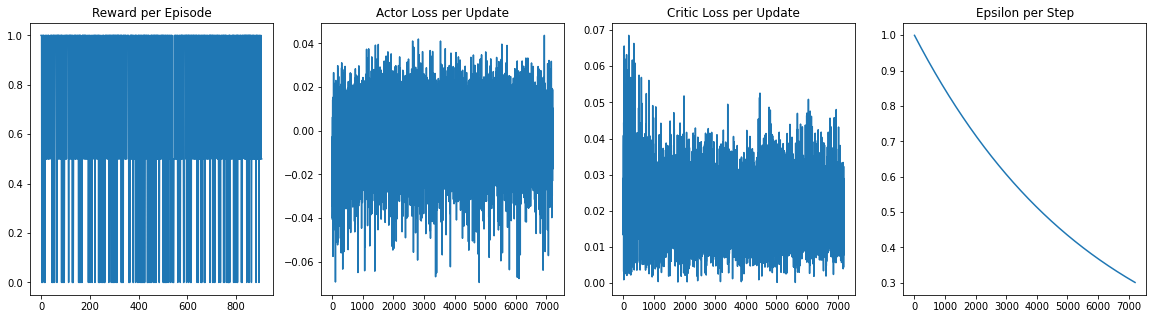

1
2
1
1
2
--Rx(5.808)----Rz(4.884)----Rx(0.377)----Rz(5.252)----Rx(0.864)----Rz(6.247)----S--------S--------------------------------------------------
                                                                                                                                            
--Ry(5.900)----Rz(3.989)----Ry(3.482)----Rz(5.439)----Ry(4.675)----Rz(3.870)----S----Ry(1.678)----Rz(2.109)----Ry(4.850)----Rz(6.080)----S--
                                                                                                                                            
2
1
2
1
[-5.00000000e-01+5.00000000e-01j  5.55111512e-17+7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--S--------S--------------------------------------------------
                                                              
--S----Ry(0.241)----Rz(2.936)----S----Ry(1.194)----Rz(0.065)--
                                                              
1
0
1
1
0
2
2
1
0
2
--Rx(3.984)----Rz(4.439)----Rx(3.716)----Rz(4.1

0
0
2
2
1
--Rx(2.827)----Rz(3.968)----Rx(3.124)----Rz(6.181)----S----Rx(3.902)----Rz(5.276)----Rx(4.388)----Rz(1.097)----S----S--
                                                                                                                       
--Ry(2.936)----Rz(1.920)----Ry(5.420)----Rz(2.585)----S--------S------------S--------Ry(5.833)----Rz(2.749)------------
                                                                                                                       
2
0
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--S----Rx(5.385)----Rz(4.984)----S----Rx(3.548)----Rz(5.632)--
                                                              
--S--------S--------------------------------------------------
                                                              
1
2
2
0
2
0
0
2
0
0
------S------------S--------Rx(1.129)----Rz(4.357)----S----Rx(5.555)----Rz(1.207)----Rx(2.992)----Rz(3.334)----S----Rx(4.686)----Rz

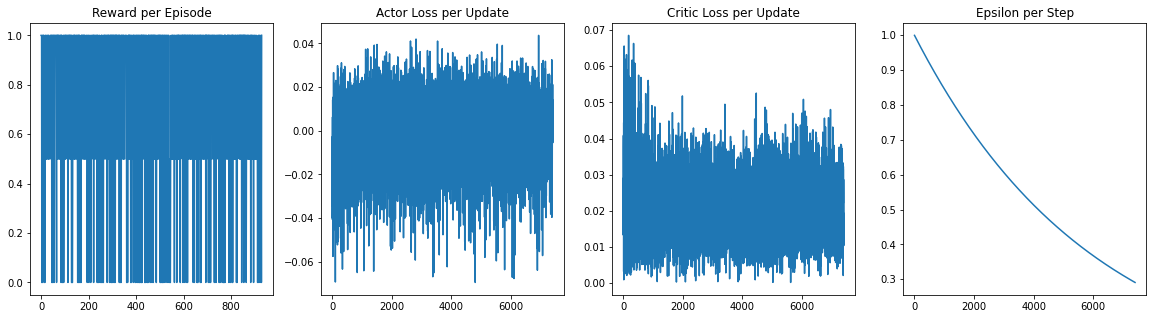

2
0
2
0
0
1
--Rx(2.918)----Rz(2.597)--------S------------S--------Rx(2.948)----Rz(2.014)----S----Rx(2.459)----Rz(2.654)----Rx(2.584)----Rz(4.940)--
                                                                                                                                       
--Ry(2.876)----Rz(3.833)----Ry(1.216)----Rz(2.928)--------S------------S--------S----Ry(1.775)----Rz(2.757)----------------------------
                                                                                                                                       
2
2
0
0
0
2
2
0
1
0
--S----S----Rx(2.408)----Rz(0.545)----Rx(0.657)----Rz(4.682)----Rx(0.272)----Rz(2.496)----S----S----Rx(2.719)----Rz(1.041)----Rx(4.071)----Rz(5.859)--
                                                                                                                                                      
--S----S--------S------------S--------Ry(5.843)----Rz(3.128)--------------------------------------------------------------

0
0
2
1
--Rx(6.148)----Rz(2.758)----S----S----Rx(2.089)----Rz(4.214)----Rx(1.677)----Rz(1.173)----Rx(2.219)----Rz(4.329)----Rx(4.644)----Rz(1.205)----S--
                                                                                                                                                 
--Ry(5.971)----Rz(5.445)----S----S--------S--------Ry(4.225)----Rz(1.115)------------------------------------------------------------------------
                                                                                                                                                 
0
0
2
2
0
1
2
1
0
[ 5.00000000e-01-5.00000000e-01j  5.88784672e-17-1.11022302e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(2.278)----Rz(0.150)----Rx(3.047)----Rz(0.266)----S--------S--------Rx(5.534)----Rz(6.033)----S----Rx(4.028)----Rz(0.295)--
                                                                                                                               
------S------------S--------Ry(3.96

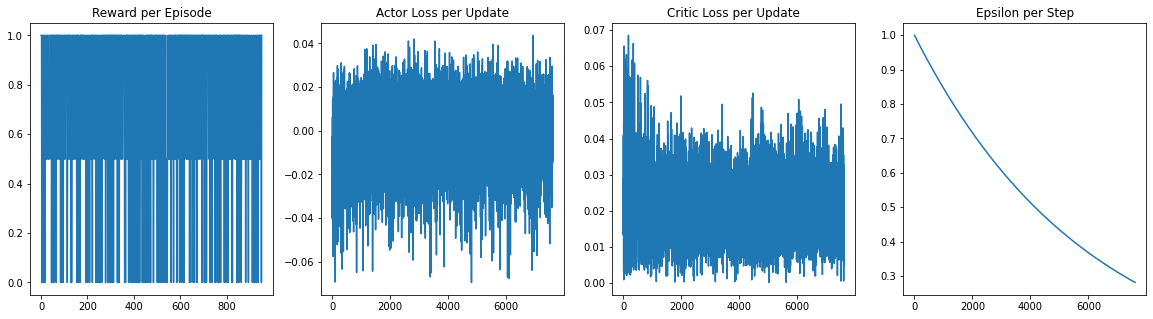

0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(5.610)----Rz(4.930)----S----Rx(2.586)----Rz(2.589)--
                                                         
--Ry(1.809)----Rz(3.143)----S----------------------------
                                                         
2
1
0
1
2
0
2
1
2
2
--S----Rx(1.183)----Rz(4.619)--------S--------Rx(4.667)----Rz(2.829)----S--------S------------S----------------
                                                                                                               
--S----Ry(3.217)----Rz(5.125)----Ry(3.181)----Rz(2.659)--------S--------S----Ry(3.565)----Rz(0.742)----S----S--
                                                                                                               
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                    

2
2
1
2
2
2
1
[0.5-5.00000000e-01j 0. -7.85046229e-17j 0.5+5.00000000e-01j]
--Rx(0.241)----Rz(4.474)----Rx(0.159)----Rz(1.689)--------S--------S----S----S--------S------------S------
                                                                                                          
------S------------S------------S--------Ry(3.154)----Rz(3.868)----S----S----S----Ry(5.124)----Rz(0.792)--
                                                                                                          
1
0
0
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(1.488)----Rz(4.123)----Rx(1.394)----Rz(4.520)--------S------
                                                                 
--Ry(4.747)----Rz(1.527)--------S--------Ry(0.032)----Rz(0.371)--
                                                                 
2
1
2
0
2
0
2
2
2
2
--S--------S--------Rx(2.741)----Rz(5.364)----S----Rx(1.259)----Rz(3.535)----S----S----S----S--
       

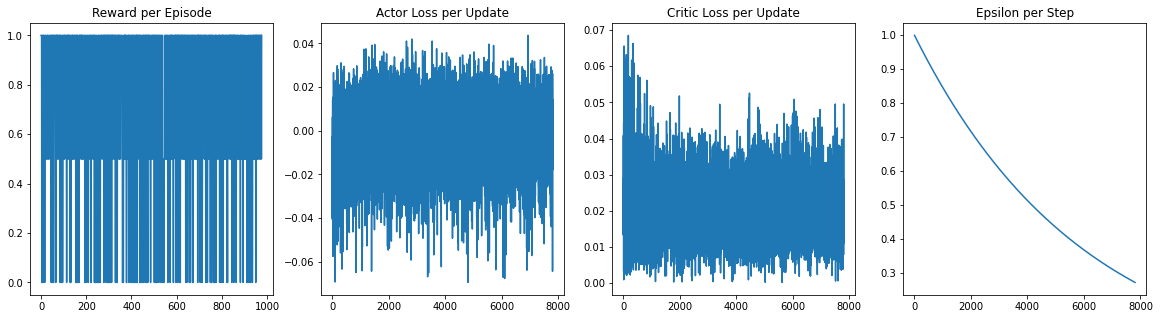

2
1
0
1
0
1
--Rx(1.508)----Rz(4.462)----Rx(3.222)----Rz(2.711)----S----Rx(5.785)----Rz(2.578)----Rx(5.882)----Rz(3.104)----------------------------
                                                                                                                                       
--Ry(5.214)----Rz(1.159)----Ry(5.443)----Rz(1.727)----S----Ry(1.165)----Rz(5.984)----Ry(5.305)----Rz(5.166)----Ry(5.614)----Rz(4.174)--
                                                                                                                                       
0
1
0
1
2
1
[5.00000000e-01+5.00000000e-01j 5.55111512e-17-3.25176795e-17j
 5.00000000e-01-5.00000000e-01j]
--Rx(5.192)----Rz(6.265)----Rx(3.616)----Rz(1.273)----S----------------------------
                                                                                   
--Ry(0.750)----Rz(1.245)----Ry(0.772)----Rz(2.537)----S----Ry(0.878)----Rz(1.013)--
                                                                                   


2
0
0
0
--Rx(2.265)----Rz(1.020)----Rx(5.916)----Rz(2.647)----S----S----Rx(1.827)----Rz(0.474)----S----Rx(3.410)----Rz(0.414)----Rx(3.653)----Rz(1.946)----Rx(0.330)----Rz(0.855)--
                                                                                                                                                                           
------S------------S--------Ry(1.012)----Rz(3.399)----S--------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                           
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(5.746)----Rz(0.607)----S----Ry(0.549)----Rz(4.053)--
                         

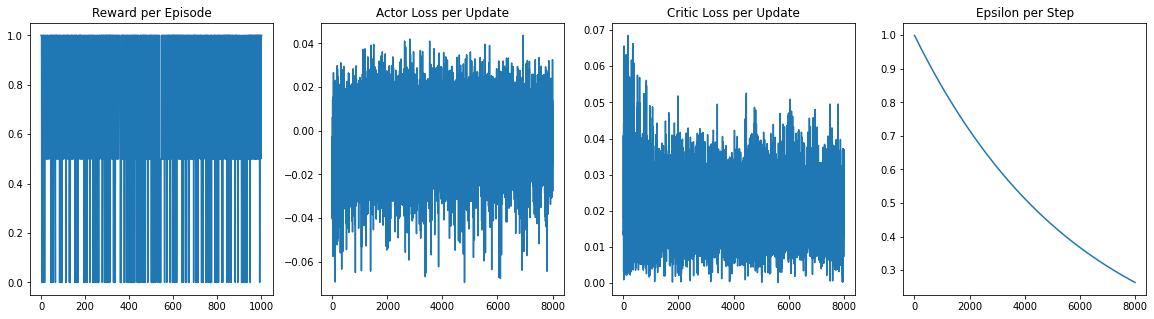

1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(3.970)----Rz(4.541)----S----Ry(2.467)----Rz(6.124)--
                                                         
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(6.153)----Rz(6.064)----S----Ry(5.323)----Rz(2.835)--
                                                         
1
0
0
0
0
0
0
0
0
0
--Rx(1.203)----Rz(5.476)----Rx(2.897)----Rz(2.005)----Rx(2.303)----Rz(3.817)----Rx(5.210)----Rz(0.492)----Rx(6.040)----Rz(3.483)----Rx(1.177)----Rz(2.773)----Rx(4.648)----Rz(4.982)----Rx(2.812)----Rz(0.534)----Rx(2.138)----Rz(3.571)--
                                                                           

1
0
2
2
1
1
1
--Rx(3.383)----Rz(2.160)----Rx(2.155)----Rz(5.945)--------S------------S----------------------------------------------------------------------------------------------
                                                                                                                                                                      
--Ry(1.302)----Rz(6.193)----Ry(3.168)----Rz(6.203)----Ry(0.295)----Rz(1.908)----S----S----Ry(5.160)----Rz(4.511)----Ry(6.186)----Rz(4.212)----Ry(3.090)----Rz(3.140)--
                                                                                                                                                                      
0
0
0
1
2
0
[ 5.00000000e-01+0.5j  1.96261557e-16+0.j  -5.00000000e-01+0.5j]
--Rx(1.891)----Rz(0.741)----Rx(5.932)----Rz(0.187)----Rx(0.764)----Rz(4.168)----S----Rx(4.827)----Rz(4.617)--
                                                                                                             
--Ry(5.938)----Rz(1.3

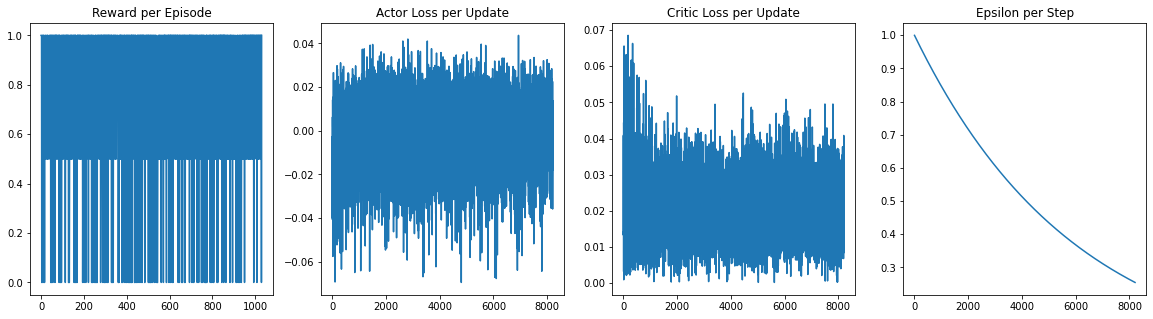

0
2
1
0
[-5.00000000e-01-5.00000000e-01j  7.85046229e-17+1.66533454e-16j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(5.638)----Rz(1.655)--------S--------Rx(0.735)----Rz(0.689)--
                                                                      
--S--------S--------Ry(4.444)----Rz(0.764)----------------------------
                                                                      
0
1
0
0
2
2
0
0
1
2
--Rx(4.320)----Rz(1.633)----Rx(4.648)----Rz(2.899)----Rx(3.746)----Rz(1.599)----S----S----Rx(1.629)----Rz(1.672)----Rx(6.109)----Rz(1.261)----S--
                                                                                                                                                 
--Ry(5.471)----Rz(4.546)--------S------------S--------Ry(5.895)----Rz(3.327)----S----------------------------------------------------------------
                                                                                                                                                 
0
2
0

2
0
1
[-5.00000000e-01-5.00000000e-01j  1.57009246e-16+1.66533454e-16j
  5.00000000e-01-5.00000000e-01j]
--Rx(0.490)----Rz(2.969)----Rx(1.440)----Rz(0.351)--------S--------Rx(4.364)----Rz(1.710)----------------------------
                                                                                                                     
--Ry(0.466)----Rz(3.510)----Ry(3.586)----Rz(1.039)----Ry(3.313)----Rz(3.571)--------S--------Ry(2.189)----Rz(2.865)--
                                                                                                                     
0
2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.158)----Rz(3.089)--------S--------Rx(3.138)----Rz(2.363)--
                                                                 
------S--------Ry(2.497)----Rz(5.720)----------------------------
                                                                 
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-

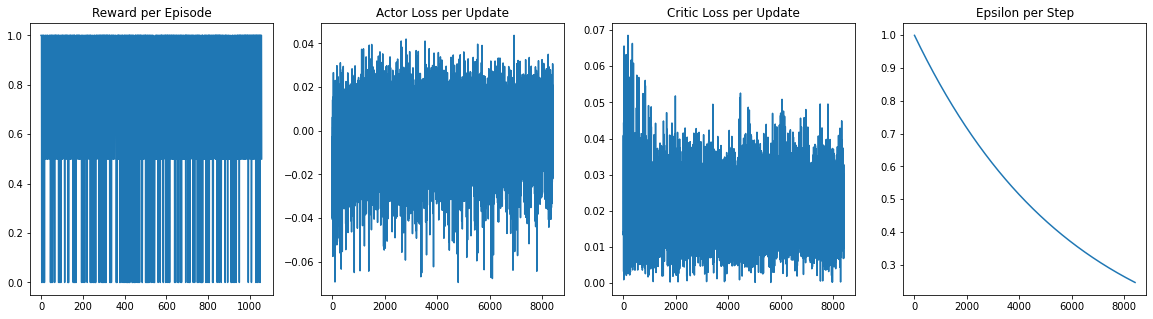

0
1
2
0
2
2
0
--Rx(2.013)----Rz(5.240)--------S------------S--------Rx(3.864)----Rz(2.837)----S----Rx(4.975)----Rz(1.656)----S----S----Rx(3.567)----Rz(3.856)--
                                                                                                                                                 
------S------------S--------Ry(2.366)----Rz(5.090)--------S------------S--------S----------------------------------------------------------------
                                                                                                                                                 
2
2
1
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-5.55111512e-17j
 -5.00000000e-01+5.00000000e-01j]
--S----S--------S--------------------------------------------------
                                                                   
--S----S----Ry(5.142)----Rz(4.887)----S----Ry(4.278)----Rz(5.351)--
                                                                   
1
0
0
1
2
0
2
2
0
1
-

0
1
0
0
0
2
--Rx(2.342)----Rz(0.460)----Rx(5.663)----Rz(4.593)----Rx(5.692)----Rz(2.584)----Rx(2.396)----Rz(5.740)----Rx(5.847)----Rz(0.478)----Rx(5.062)----Rz(1.848)----Rx(0.832)----Rz(6.151)----S--
                                                                                                                                                                                           
--Ry(0.688)----Rz(2.234)----Ry(0.385)----Rz(6.107)--------S--------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                           
0
0
2
0
0
1
0
1
1
0
--Rx(2.620)----Rz(1.971)----Rx(1.692)----Rz(0.546)--------S--------Rx(1.145)----Rz(1.508)----Rx(4.250)----Rz(0.319)----Rx(5.838)----Rz(5.912)----Rx(5.690)----Rz(0.257)--
                                              

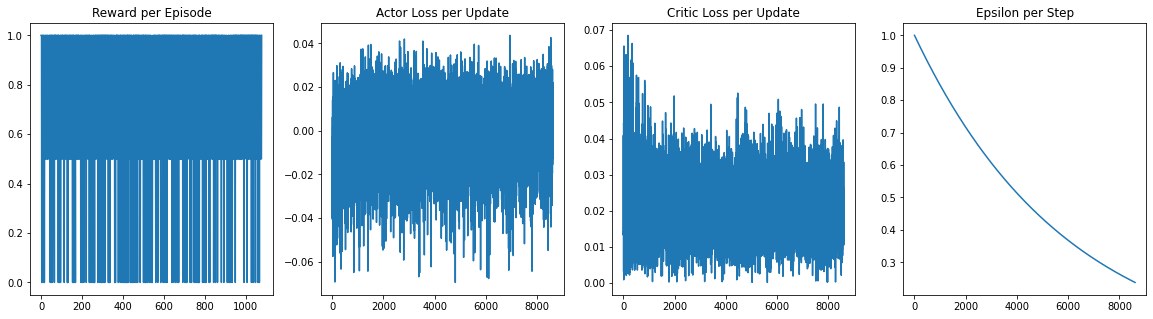

1
0
0
1
0
0
--S----S----Rx(2.336)----Rz(2.792)----Rx(6.160)----Rz(0.781)----Rx(5.279)----Rz(4.360)----Rx(2.347)----Rz(5.733)----Rx(5.251)----Rz(1.453)--
                                                                                                                                            
--S----S----Ry(3.686)----Rz(3.707)----Ry(6.063)----Rz(3.620)----Ry(4.018)----Rz(4.837)------------------------------------------------------
                                                                                                                                            
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(4.073)----Rz(3.560)----S----Ry(4.567)----Rz(4.883)--
                                                         
1
1
2
1
2
0
2
1
2
2
------S------------S--------Rx(3.393)----Rz(4.934)----S--------S---

0
1
1
1
2
0
[-5.00000000e-01+0.5j -5.88784672e-17+0.j   5.00000000e-01+0.5j]
--S----S----Rx(4.271)----Rz(0.040)--------S--------Rx(3.480)----Rz(4.457)--------------------
                                                                                             
--S----S----Ry(5.339)----Rz(1.357)----Ry(2.693)----Rz(0.824)----Ry(3.740)----Rz(0.662)----S--
                                                                                             
0
2
1
1
1
1
1
0
[0.5-5.00000000e-01j 0. +7.85046229e-17j 0.5+5.00000000e-01j]
--Rx(4.755)----Rz(6.264)--------S--------Rx(5.400)----Rz(4.968)--------------------------------------------------------------------------------
                                                                                                                                               
------S--------Ry(2.758)----Rz(4.568)----Ry(6.063)----Rz(2.505)----Ry(2.714)----Rz(2.631)----Ry(4.944)----Rz(0.097)----Ry(5.053)----Rz(5.812)--
                                     

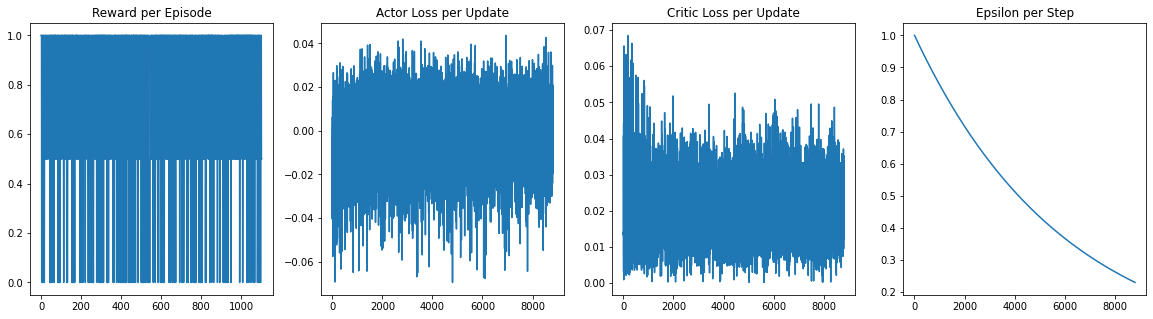

1
0
2
--Rx(2.875)----Rz(4.098)----Rx(1.026)----Rz(3.377)----Rx(5.664)----Rz(2.914)----Rx(1.917)----Rz(6.085)----Rx(3.871)----Rz(4.018)----Rx(0.927)----Rz(5.496)----S--
                                                                                                                                                                 
--Ry(2.522)----Rz(2.379)----Ry(3.831)----Rz(1.477)----Ry(2.362)----Rz(5.093)--------S----------------------------------------------------------------------------
                                                                                                                                                                 
2
2
2
1
0
2
0
1
[ 5.00000000e-01-5.00000000e-01j  5.88784672e-17+5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--S----S----S----Rx(1.881)----Rz(5.207)----S----Rx(4.046)----Rz(3.766)--
                                                                        
--S----S----S----Ry(5.632)----Rz(4.037)----S----Ry(2.251)----Rz(4.612)--
            

1
0
0
2
0
0
0
--S----Rx(6.253)----Rz(1.125)----Rx(0.017)----Rz(1.251)--------S--------Rx(1.499)----Rz(1.704)----Rx(3.338)----Rz(0.106)----Rx(0.433)----Rz(3.251)--
                                                                                                                                                    
--S----Ry(5.837)----Rz(6.215)----Ry(5.932)----Rz(2.701)----Ry(4.878)----Rz(4.275)--------S----------------------------------------------------------
                                                                                                                                                    
0
1
1
0
2
0
2
2
1
0
--Rx(4.893)----Rz(1.958)----Rx(4.240)----Rz(3.154)----S----Rx(5.122)----Rz(3.791)--------S------------S--------Rx(1.469)----Rz(2.781)--
                                                                                                                                       
--Ry(1.767)----Rz(0.304)----Ry(2.892)----Rz(5.527)----S--------S------------S--------Ry(4.258)----

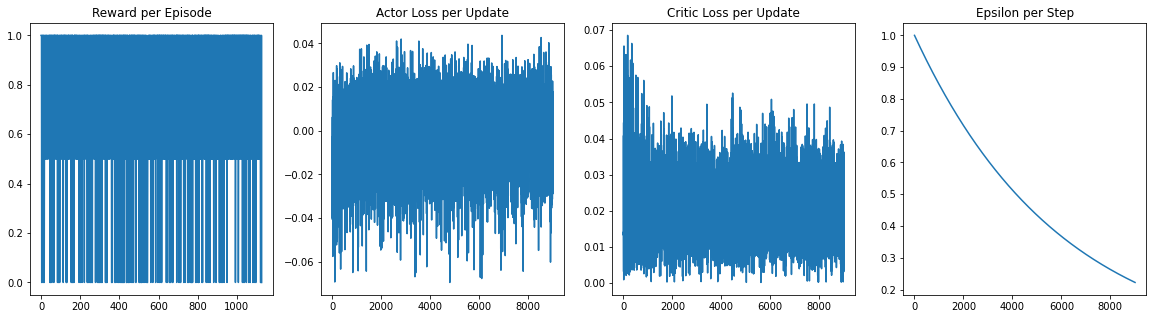

2
0
1
[-0.5-5.00000000e-01j  0. -7.85046229e-17j -0.5+5.00000000e-01j]
--S----S----Rx(0.527)----Rz(1.749)----Rx(5.382)----Rz(5.771)----Rx(2.014)----Rz(1.208)----S----Rx(5.030)----Rz(4.041)--
                                                                                                                       
--S----S----Ry(3.883)----Rz(3.165)--------S--------Ry(1.088)----Rz(1.375)----------------------------------------------
                                                                                                                       
0
0
1
2
0
1
[ 5.00000000e-01+5.00000000e-01j  1.89526925e-16+5.55111512e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(0.645)----Rz(6.142)----Rx(3.279)----Rz(4.841)--------S--------Rx(1.067)----Rz(3.513)--
                                                                                           
--Ry(4.725)----Rz(6.152)--------S--------Ry(3.157)----Rz(6.113)----------------------------
                                                              

2
0
1
1
0
0
2
1
2
0
--S----Rx(5.098)----Rz(5.120)----Rx(2.365)----Rz(4.433)----Rx(3.177)----Rz(2.841)--------S--------S----Rx(0.302)----Rz(2.561)--
                                                                                                                               
--S----Ry(1.864)----Rz(1.147)----Ry(2.371)----Rz(1.603)--------S--------Ry(1.954)----Rz(2.612)----S----------------------------
                                                                                                                               
0
1
2
2
1
1
0
2
1
0
--Rx(0.888)----Rz(0.686)----S----S----Rx(1.862)----Rz(3.685)--------S--------Rx(2.414)----Rz(1.503)----------------------------
                                                                                                                               
--Ry(2.127)----Rz(5.271)----S----S----Ry(3.664)----Rz(5.707)----Ry(2.597)----Rz(3.854)--------S--------Ry(3.586)----Rz(0.713)--
                                                                

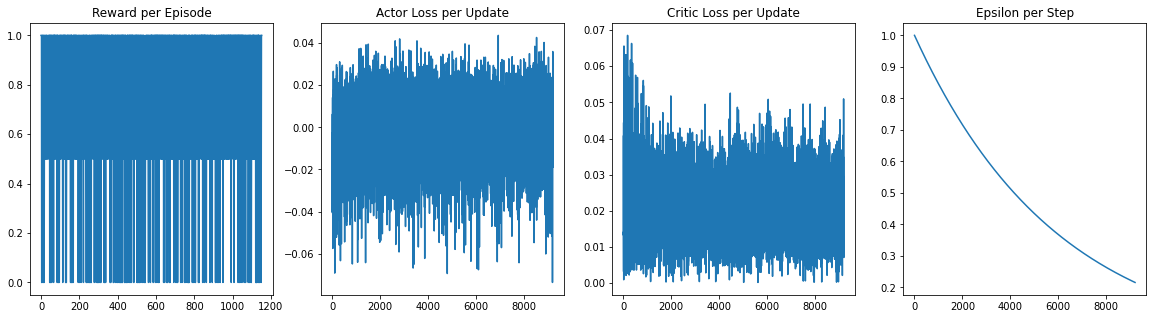

0
0
1
2
--S----S----Rx(5.535)----Rz(2.823)----Rx(6.278)----Rz(1.986)----Rx(1.678)----Rz(1.489)----Rx(0.290)----Rz(5.249)----Rx(5.515)----Rz(1.474)----S--
                                                                                                                                                 
--S----S----Ry(3.044)----Rz(1.864)----Ry(4.451)----Rz(1.626)--------S----------------------------------------------------------------------------
                                                                                                                                                 
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.686)----Rz(4.173)----S----Rx(0.148)----Rz(1.906)--
                                                         
------S--------------------------------------------------
                                                         
0
0
0
0
1
0
2
1
[ 5.00000000e-01-5.00000000e-01j -3.33066907e-16-9.8130

1
------S------------S------------S--------Rx(0.119)----Rz(0.940)----S------------------------------------------------------------------------------------------
                                                                                                                                                              
--Ry(5.030)----Rz(4.977)----Ry(1.800)----Rz(0.095)--------S--------S----S----Ry(6.027)----Rz(2.740)----S----Ry(0.799)----Rz(4.503)----Ry(0.854)----Rz(2.590)--
                                                                                                                                                              
0
1
1
0
1
2
2
1
1
0
--Rx(5.248)----Rz(4.246)----Rx(0.673)----Rz(4.179)--------S------------S--------Rx(4.550)----Rz(1.601)------------------------------------------------------
                                                                                                                                                            
--Ry(5.614)----Rz(3.581)----

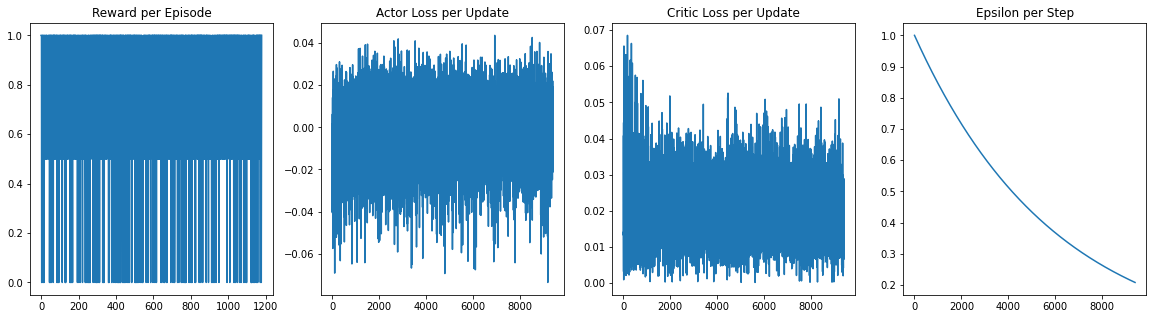

2
0
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--S----Rx(2.758)----Rz(2.084)----S----Rx(0.148)----Rz(0.957)--
                                                              
--S--------S--------------------------------------------------
                                                              
0
0
0
2
2
1
0
2
1
0
--Rx(5.669)----Rz(1.969)----Rx(6.250)----Rz(3.371)----Rx(0.588)----Rz(4.199)--------S--------S----Rx(1.122)----Rz(6.003)----S----Rx(1.968)----Rz(4.235)--
                                                                                                                                                         
------S------------S--------Ry(4.750)----Rz(4.857)--------S--------Ry(3.484)----Rz(4.288)----------------------------------------------------------------
                                                                                                                                                         
0
1
2

0
1
--S----S----Rx(5.971)----Rz(2.686)----Rx(4.843)----Rz(3.769)----Rx(0.574)----Rz(4.533)------------------------------------------------------
                                                                                                                                            
--S----S----Ry(4.165)----Rz(5.104)----Ry(5.068)----Rz(4.041)----Ry(1.603)----Rz(4.594)----Ry(2.068)----Rz(0.526)----Ry(6.220)----Rz(0.578)--
                                                                                                                                            
1
0
1
1
0
1
2
0
2
1
--Rx(0.162)----Rz(2.103)----Rx(2.625)----Rz(3.272)--------S--------Rx(5.077)----Rz(5.072)--------S------------------------------------------
                                                                                                                                            
--Ry(1.243)----Rz(6.035)----Ry(4.121)----Rz(3.034)----Ry(1.287)----Rz(0.563)----Ry(3.834)----Rz(5.399)----S----S----Ry(5.224)----R

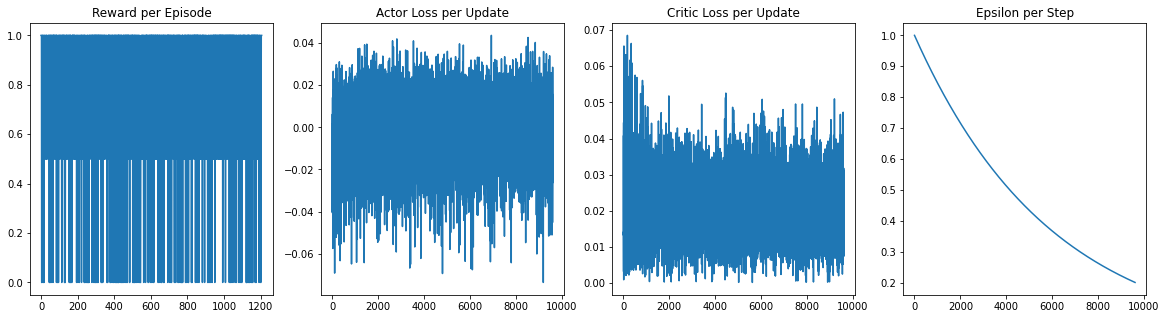

1
--S----S----Rx(1.561)----Rz(4.745)----Rx(2.614)----Rz(5.025)----Rx(0.401)----Rz(6.146)----Rx(0.842)----Rz(3.445)----Rx(3.001)----Rz(1.706)--
                                                                                                                                            
--S----S----Ry(5.646)----Rz(3.153)----Ry(4.014)----Rz(5.020)----Ry(0.544)----Rz(0.691)------------------------------------------------------
                                                                                                                                            
0
2
2
0
0
2
1
0
[-5.00000000e-01+5.00000000e-01j  1.66533454e-16-7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(2.452)----Rz(0.669)----S--------S--------Rx(0.253)----Rz(3.844)----Rx(2.164)----Rz(0.189)----S----Rx(2.900)----Rz(4.060)--
                                                                                                                               
------S------------S--------S----Ry(0.179)----Rz(2.768)--------

1
1
2
2
1
0
--S----Rx(6.123)----Rz(3.313)----Rx(0.159)----Rz(4.862)--------S------------S--------Rx(6.224)----Rz(2.502)----------------------------
                                                                                                                                       
--S----Ry(0.919)----Rz(4.660)----Ry(1.406)----Rz(5.074)----Ry(4.225)----Rz(4.674)--------S------------S--------Ry(0.751)----Rz(0.303)--
                                                                                                                                       
1
2
2
0
1
0
1
1
2
0
[-5.00000000e-01+5.00000000e-01j  1.57009246e-16+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
------S------------S--------Rx(1.658)----Rz(5.844)----Rx(6.054)----Rz(3.310)--------S--------Rx(2.002)----Rz(5.786)--------------------
                                                                                                                                       
--Ry(2.976)----Rz(4.020)--------S------------S-------

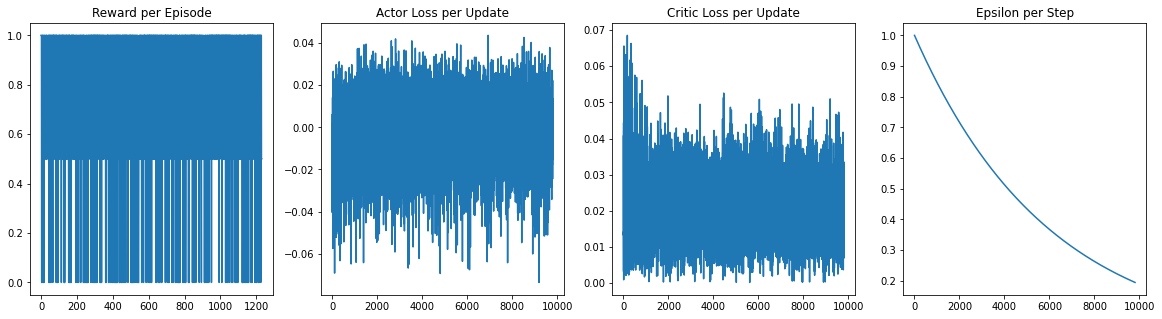

2
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
------S--------Rx(0.040)----Rz(5.207)----Rx(2.635)----Rz(2.807)----Rx(6.207)----Rz(6.133)----S----S--
                                                                                                     
--Ry(3.829)----Rz(3.663)--------S------------S------------S--------Ry(5.276)----Rz(3.359)------------
                                                                                                     
2
2
2
2
1
1
1
0
0
1
--S----S----S----S----Rx(0.852)----Rz(3.102)----Rx(4.449)----Rz(0.123)------------------------------------------------------
                                                                                                                            
--S----S----S----S----Ry(1.945)----Rz(4.839)----Ry(2.079)----Rz(5.964)----Ry(3.113)----Rz(3.254)----Ry(5.191)----Rz(2.193)--
                                                                                            

0
1
--Rx(2.143)----Rz(2.372)--------S------------S--------Rx(1.397)----Rz(4.683)----Rx(6.198)----Rz(0.785)----Rx(2.487)----Rz(0.507)--
                                                                                                                                  
--Ry(2.947)----Rz(2.285)----Ry(0.966)----Rz(4.153)--------S------------S--------Ry(6.215)----Rz(0.659)----Ry(0.105)----Rz(0.898)--
                                                                                                                                  
2
2
2
0
1
2
1
1
1
0
[-0.5+5.00000000e-01j  0. -9.81307787e-17j -0.5-5.00000000e-01j]
--S----S----S----Rx(0.218)----Rz(5.898)----S----Rx(3.939)----Rz(1.083)------------------------------------------------------
                                                                                                                            
--S----S----S----Ry(5.209)----Rz(5.047)----S----Ry(4.729)----Rz(4.191)----Ry(5.963)----Rz(3.873)----Ry(2.950)----Rz(5.381)--
            

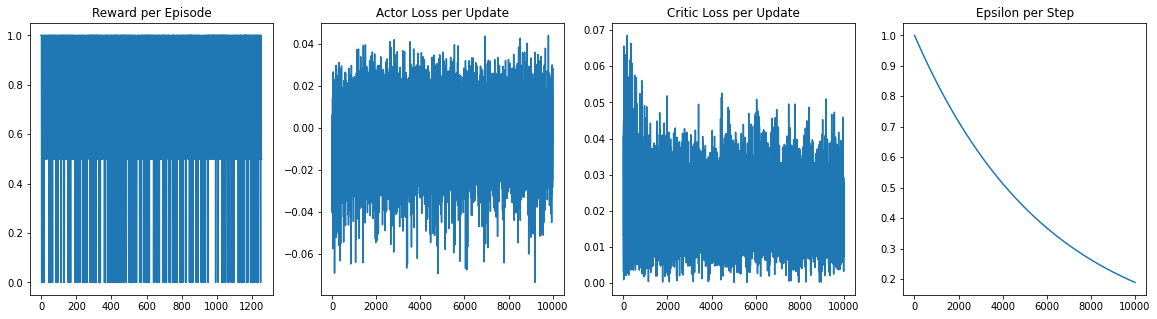

0
1
1
0
0
0
--S----S----S----Rx(2.961)----Rz(6.104)----Rx(5.098)----Rz(5.778)----Rx(4.038)----Rz(5.477)----Rx(1.544)----Rz(1.765)----Rx(1.352)----Rz(2.683)--
                                                                                                                                                 
--S----S----S----Ry(1.954)----Rz(3.386)----Ry(1.149)----Rz(1.353)--------------------------------------------------------------------------------
                                                                                                                                                 
1
2
0
2
1
1
2
0
2
1
------S--------Rx(2.401)----Rz(0.038)----S--------S--------Rx(5.166)----Rz(0.622)--------S------------------------------------------
                                                                                                                                    
--Ry(2.641)----Rz(2.683)--------S--------S----Ry(4.473)----Rz(4.920)----Ry(3.082)----Rz(1.937)----S----S----Ry(0.992)-

2
1
1
1
1
0
1
0
------S--------Rx(2.387)----Rz(2.779)----Rx(5.175)----Rz(5.750)------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                   
--Ry(2.934)----Rz(5.153)----Ry(2.696)----Rz(4.820)--------S--------Ry(1.036)----Rz(1.332)----Ry(2.453)----Rz(0.067)----Ry(4.985)----Rz(0.299)----Ry(1.631)----Rz(5.189)----Ry(1.946)----Rz(2.774)--
                                                                                                                                                                                                   
1
0
0
0
2
0
0
1
[ 5.00000000e-01-5.0000000e-01j -1.66533454e-16-1.3738309e-16j
  5.00000000e-01+5.0000000e-01j]
--Rx(3.046)----Rz(2.898)----Rx(6.058)----Rz(4.709)----Rx(3.463)----Rz(5.937)----S----Rx(

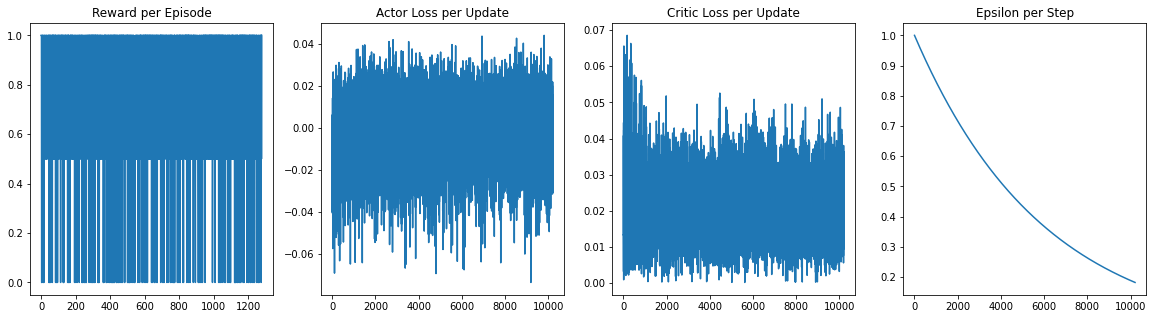

1
1
0
0
--Rx(2.025)----Rz(1.107)----Rx(4.290)----Rz(0.102)----Rx(2.037)----Rz(0.794)----Rx(3.315)----Rz(3.337)----Rx(3.383)----Rz(2.220)----Rx(4.875)----Rz(1.270)--
                                                                                                                                                            
--Ry(5.766)----Rz(2.880)----Ry(2.544)----Rz(1.117)----Ry(4.439)----Rz(4.259)----Ry(5.271)----Rz(0.924)------------------------------------------------------
                                                                                                                                                            
1
0
0
1
1
2
0
2
2
0
--Rx(3.213)----Rz(3.888)----Rx(5.639)----Rz(2.249)--------S--------Rx(1.587)----Rz(4.893)----S----S----Rx(5.490)----Rz(0.595)--
                                                                                                                               
--Ry(1.431)----Rz(4.005)----Ry(0.916)----Rz(5.338)----Ry(4.369)----Rz(2.230)--------S---

0
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17-5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--Rx(4.948)----Rz(0.693)--------S--------Rx(1.052)----Rz(0.319)--------------------
                                                                                   
--Ry(3.835)----Rz(2.151)----Ry(2.066)----Rz(0.334)----Ry(4.656)----Rz(0.449)----S--
                                                                                   
1
2
0
2
0
0
1
0
0
1
------S--------Rx(5.919)----Rz(5.821)----S----Rx(3.436)----Rz(2.868)----Rx(0.924)----Rz(4.037)----Rx(3.332)----Rz(5.610)----Rx(1.600)----Rz(3.245)--
                                                                                                                                                    
--Ry(2.236)----Rz(5.635)--------S--------S----Ry(4.983)----Rz(2.587)----Ry(2.437)----Rz(1.587)------------------------------------------------------
                                                                                                

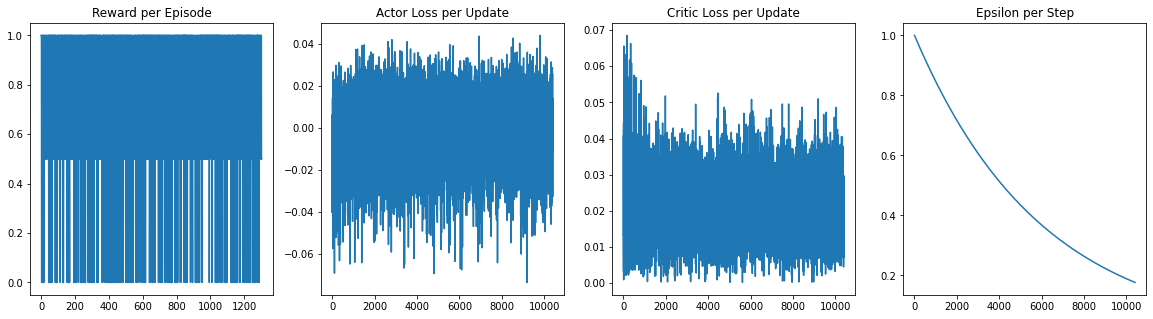

0
0
2
1
1
------S------------S------------S--------Rx(5.572)----Rz(0.014)----Rx(1.356)----Rz(0.101)----S------------------------------------------------------
                                                                                                                                                    
--Ry(4.336)----Rz(0.156)----Ry(1.804)----Rz(3.052)--------S------------S------------S--------S----Ry(1.202)----Rz(5.413)----Ry(2.126)----Rz(0.409)--
                                                                                                                                                    
2
2
0
0
0
1
2
0
[-5.00000000e-01-0.5j -1.96261557e-16+0.j   5.00000000e-01-0.5j]
--S----S----Rx(5.428)----Rz(4.251)----Rx(0.854)----Rz(5.363)----Rx(5.879)----Rz(3.766)----S----Rx(1.102)----Rz(0.401)--
                                                                                                                       
--S----S----Ry(4.320)----Rz(2.105)--------S------------------------------

1
0
2
0
0
0
1
[ 5.00000000e-01+5.00000000e-01j -2.22044605e-16+7.85046229e-17j
  5.00000000e-01-5.00000000e-01j]
--Rx(5.385)----Rz(3.249)----S----Rx(1.430)----Rz(0.878)----Rx(5.028)----Rz(0.218)----Rx(3.662)----Rz(3.127)--
                                                                                                             
--Ry(0.401)----Rz(2.848)----S----Ry(3.127)----Rz(3.813)------------------------------------------------------
                                                                                                             
2
1
1
2
1
1
2
0
2
0
[ 5.00000000e-01-5.00000000e-01j  1.89526925e-16-2.22044605e-16j
 -5.00000000e-01-5.00000000e-01j]
--S--------S------------S--------Rx(1.678)----Rz(2.902)----S----Rx(5.941)----Rz(2.398)--------------------------------------
                                                                                                                            
--S----Ry(5.402)----Rz(5.950)----Ry(0.431)----Rz(6.007)----S----Ry(2.450)----R

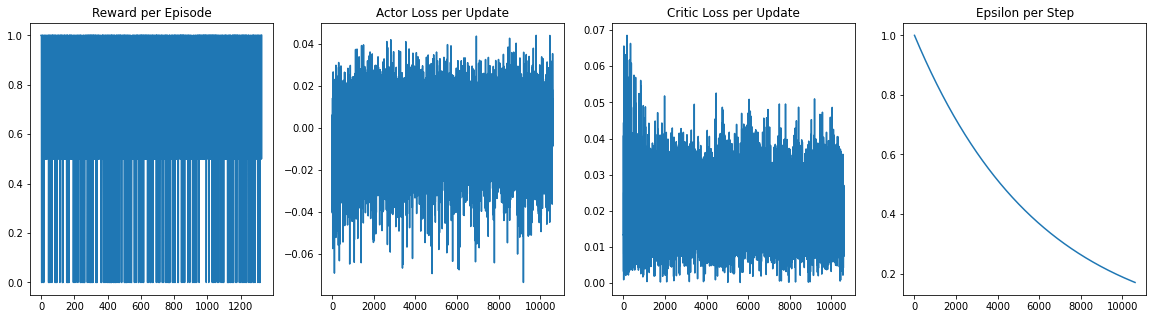

1
0
0
2
--Rx(0.674)----Rz(3.690)----S----S----Rx(2.484)----Rz(3.597)----Rx(5.408)----Rz(4.591)----Rx(1.075)----Rz(1.079)----S--
                                                                                                                       
--Ry(1.687)----Rz(3.119)----S----S----Ry(4.941)----Rz(5.737)----Ry(0.339)----Rz(2.629)--------S------------------------
                                                                                                                       
1
0
2
1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(0.473)----Rz(1.388)----S----------------------------
                                                         
--Ry(6.257)----Rz(5.430)----S----Ry(0.635)----Rz(4.019)--
                                                         
2
0
1
0
2
1
2
0
0
0
--S----Rx(2.061)----Rz(3.786)----Rx(4.221)----Rz(5.127)--------S--------S----Rx(4.154)----Rz(4.972)----Rx(0.346)----Rz(3.421)----Rx(2.373)----Rz(1.851)--

0
[0.5-5.00000000e-01j 0. +7.85046229e-17j 0.5+5.00000000e-01j]
--Rx(4.772)----Rz(2.774)--------S--------Rx(3.857)----Rz(6.163)--------------------------------------------------------------------------------
                                                                                                                                               
--Ry(2.513)----Rz(0.856)----Ry(3.800)----Rz(1.429)--------S--------Ry(4.886)----Rz(1.192)----Ry(4.948)----Rz(1.074)----Ry(2.722)----Rz(2.510)--
                                                                                                                                               
1
1
0
0
0
0
0
2
2
1
--Rx(4.993)----Rz(2.941)----Rx(3.277)----Rz(5.148)----Rx(5.160)----Rz(6.209)----Rx(1.180)----Rz(1.685)----Rx(2.001)----Rz(4.901)----S----S--
                                                                                                                                            
--Ry(4.433)----Rz(0.923)----Ry(3.100)----Rz(5.533)--------

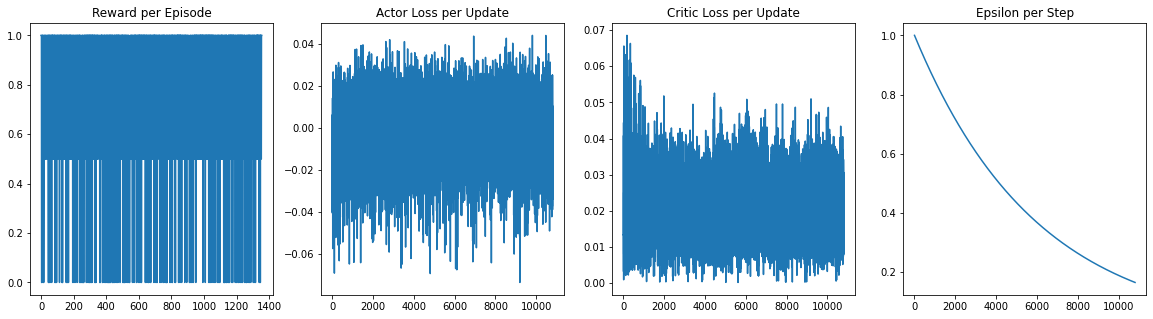

1
0
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(5.641)----Rz(3.022)----S----------------------------
                                                              
--S----Ry(0.745)----Rz(4.076)----S----Ry(2.197)----Rz(2.305)--
                                                              
2
1
2
0
1
[0.5+5.00000000e-01j 0. +7.85046229e-17j 0.5-5.00000000e-01j]
--S--------S--------Rx(4.270)----Rz(3.970)----------------------------
                                                                      
--S----Ry(3.651)----Rz(6.133)--------S--------Ry(1.270)----Rz(4.114)--
                                                                      
2
1
2
1
[-5.00000000e-01+5.00000000e-01j  5.55111512e-17+7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--S--------S--------------------------------------------------
                                                              
--S----Ry(1.842)----Rz(3.747)----S----Ry(4.134)----R

0
2
1
0
1
--S----Rx(1.782)----Rz(3.938)----Rx(4.600)----Rz(3.769)--------S--------Rx(2.963)----Rz(2.430)----Rx(4.734)----Rz(1.497)----S----Rx(4.824)----Rz(5.079)--
                                                                                                                                                         
--S--------S------------S--------Ry(3.635)----Rz(2.422)----Ry(2.370)----Rz(3.316)------------------------------------------------------------------------
                                                                                                                                                         
0
1
1
0
0
0
2
0
1
1
--Rx(3.619)----Rz(5.089)----Rx(2.616)----Rz(4.717)----Rx(4.533)----Rz(1.666)----Rx(4.986)----Rz(0.588)--------S--------Rx(4.418)----Rz(4.344)--
                                                                                                                                               
--Ry(1.595)----Rz(1.771)----Ry(0.471)----Rz(5.975)--------S-------

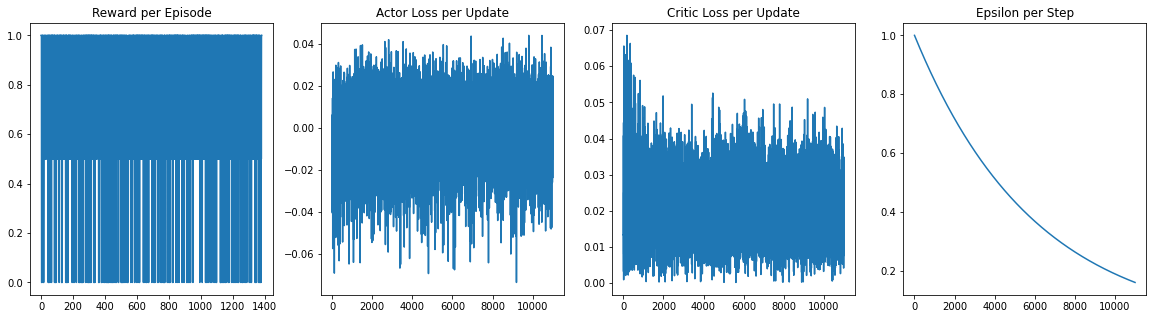

2
1
2
1
0
0
2
1
--Rx(4.801)----Rz(3.038)----S--------S--------Rx(2.196)----Rz(6.077)----Rx(4.505)----Rz(4.361)----S----------------------------
                                                                                                                               
--Ry(2.523)----Rz(6.118)----S----Ry(1.529)----Rz(5.613)--------S--------Ry(2.163)----Rz(4.183)----S----Ry(6.085)----Rz(5.905)--
                                                                                                                               
2
1
0
1
2
1
0
1
1
1
--S----Rx(2.833)----Rz(3.504)--------S--------Rx(0.567)----Rz(5.151)----------------------------------------------------------------------------------------------------------
                                                                                                                                                                              
--S----Ry(3.055)----Rz(3.955)----Ry(4.570)----Rz(0.698)--------S--------Ry(3.998)----Rz(3.426)----Ry(5

2
1
1
0
0
0
1
2
1
2
--S----Rx(5.828)----Rz(1.923)----Rx(5.037)----Rz(1.721)----Rx(3.187)----Rz(3.945)----S--------S------------------------
                                                                                                                       
--S----Ry(1.762)----Rz(4.749)----Ry(3.159)----Rz(0.640)----Ry(1.426)----Rz(0.677)----S----Ry(0.228)----Rz(5.440)----S--
                                                                                                                       
1
0
1
0
1
1
2
2
1
0
--Rx(1.768)----Rz(0.809)----Rx(4.476)----Rz(2.451)--------S------------S--------Rx(5.241)----Rz(2.227)--------------------------------------
                                                                                                                                            
--Ry(5.416)----Rz(2.600)----Ry(0.719)----Rz(3.794)----Ry(3.698)----Rz(0.118)----Ry(4.336)----Rz(3.880)----S----S----Ry(3.225)----Rz(4.871)--
                                                         

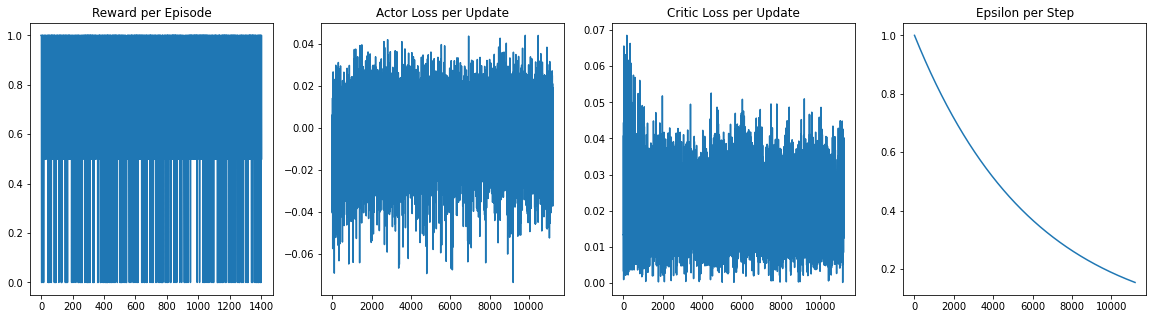

1
0
0
1
1
1
1
1
1
--Rx(0.717)----Rz(4.243)----Rx(1.145)----Rz(3.273)--------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                
--Ry(5.743)----Rz(4.846)----Ry(3.430)----Rz(6.119)----Ry(4.460)----Rz(0.258)----Ry(5.884)----Rz(3.789)----Ry(3.709)----Rz(4.714)----Ry(1.995)----Rz(1.868)----Ry(4.165)----Rz(0.099)----Ry(2.960)----Rz(3.580)--
                                                                                                                                                                                                                
0
1
1
0
1
2
1
[ 5.00000000e-01-5.00000000e-01j -8.80288308e-17-5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(0.760)----Rz(0.939)----Rx(6.

0
2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.342)----Rz(4.152)--------S--------Rx(3.157)----Rz(2.148)--
                                                                 
------S--------Ry(0.549)----Rz(2.641)----------------------------
                                                                 
2
0
1
0
1
2
1
[ 5.00000000e-01-5.00000000e-01j -3.25176795e-17-5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--S----Rx(5.493)----Rz(5.531)----Rx(0.224)----Rz(2.787)----S----------------------------
                                                                                        
--S----Ry(5.519)----Rz(5.204)----Ry(4.029)----Rz(2.597)----S----Ry(5.684)----Rz(2.199)--
                                                                                        
1
1
0
1
2
1
2
1
2
2
--Rx(5.128)----Rz(6.138)--------S------------S------------S------------S--------------------------------------------------------------------

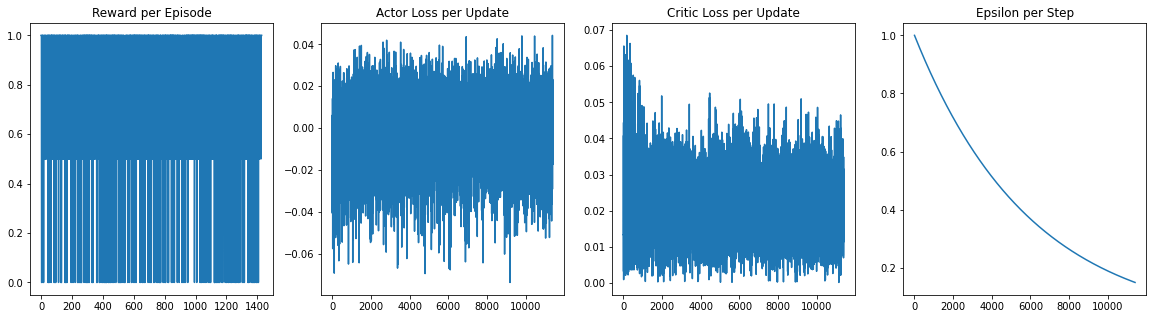

1
0
0
0
0
0
--S----S----S----Rx(1.082)----Rz(1.638)----Rx(4.353)----Rz(0.795)----Rx(6.122)----Rz(1.020)----Rx(1.843)----Rz(3.718)----Rx(1.873)----Rz(1.414)--
                                                                                                                                                 
--S----S----S----Ry(1.796)----Rz(5.582)----Ry(1.056)----Rz(1.496)--------------------------------------------------------------------------------
                                                                                                                                                 
0
0
1
1
2
0
0
0
0
1
--Rx(2.975)----Rz(5.150)----Rx(1.917)----Rz(4.188)----S----Rx(3.474)----Rz(4.864)----Rx(3.054)----Rz(0.800)----Rx(5.551)----Rz(0.898)----Rx(3.968)----Rz(1.096)--
                                                                                                                                                                 
--Ry(5.311)----Rz(4.788)----Ry(0.704)----Rz(2.642)----S----R

1
2
0
1
[0.5+5.00000000e-01j 0. +7.85046229e-17j 0.5-5.00000000e-01j]
--S--------S--------Rx(0.670)----Rz(0.330)----------------------------
                                                                      
--S----Ry(4.308)----Rz(5.650)--------S--------Ry(0.959)----Rz(4.628)--
                                                                      
2
2
2
0
0
2
1
1
1
2
--S----S----S----Rx(4.663)----Rz(3.044)----Rx(3.712)----Rz(0.170)--------S------------S------------------------
                                                                                                               
--S----S----S--------S--------Ry(5.644)----Rz(3.025)----Ry(2.906)----Rz(0.189)----Ry(2.197)----Rz(1.407)----S--
                                                                                                               
1
0
1
2
1
1
0
2
0
[-5.00000000e-01-5.00000000e-01j -2.22044605e-16+8.80288308e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(1.659)----Rz(3.266)--------S--------Rx(3.827)----Rz(5.86

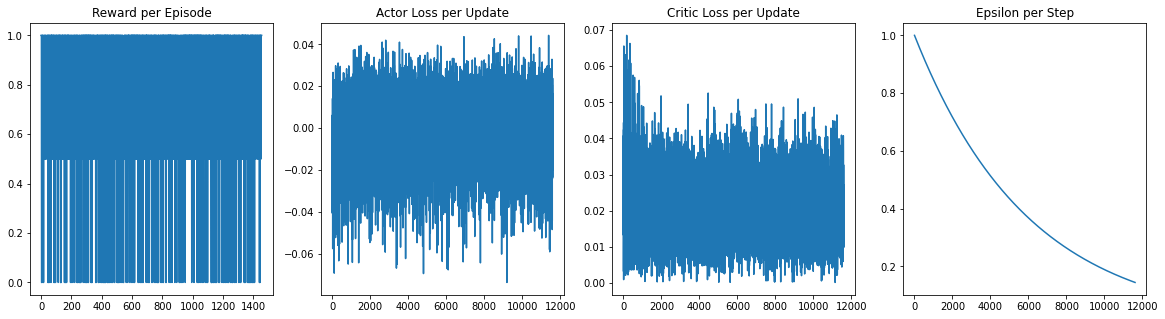

0
1
2
1
2
0
1
--Rx(1.880)----Rz(1.019)----Rx(5.648)----Rz(1.822)--------S------------S--------Rx(2.364)----Rz(3.077)----------------------------------------------
                                                                                                                                                    
--Ry(4.275)----Rz(5.263)----Ry(3.441)----Rz(1.388)----Ry(3.812)----Rz(4.657)--------S--------Ry(1.393)----Rz(6.054)----S----Ry(0.130)----Rz(5.575)--
                                                                                                                                                    
0
0
2
1
0
2
0
0
2
1
--Rx(5.856)----Rz(5.669)----Rx(0.696)----Rz(2.704)----S----Rx(0.996)----Rz(1.414)----S----Rx(6.224)----Rz(0.021)----Rx(0.429)----Rz(3.670)----S--
                                                                                                                                                 
------S--------Ry(0.676)----Rz(1.961)--------S--------S----Ry(3.556)----Rz(0.9

1
0
0
0
2
0
[-5.00000000e-01-5.00000000e-01j -2.22044605e-16-1.89526925e-16j
 -5.00000000e-01+5.00000000e-01j]
--S----S----Rx(4.905)----Rz(6.265)----Rx(3.538)----Rz(0.969)----Rx(1.699)----Rz(5.956)----S----Rx(5.219)----Rz(0.491)--
                                                                                                                       
--S----S----Ry(3.876)----Rz(1.167)----Ry(1.351)----Rz(2.892)--------S--------------------------------------------------
                                                                                                                       
1
1
2
1
2
1
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-1.89526925e-16j
 -5.00000000e-01+5.00000000e-01j]
------S------------S----------------------------------------------------------------------------------------------
                                                                                                                  
--Ry(5.574)----Rz(0.033)----Ry(3.963)----Rz(2.272)----S----Ry(1.833)

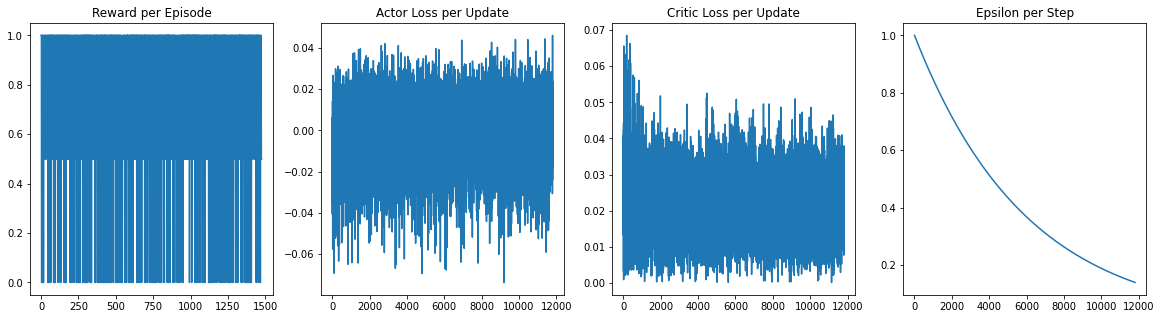

0
2
1
0
2
1
[ 5.00000000e-01-5.00000000e-01j  2.94392336e-16+5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(3.592)----Rz(1.344)----Rx(3.547)----Rz(1.928)--------S--------Rx(2.603)----Rz(0.457)----S--
                                                                                                
------S--------Ry(2.302)----Rz(4.934)--------S--------Ry(0.220)----Rz(6.094)--------------------
                                                                                                
0
2
1
1
2
0
1
1
1
0
--Rx(0.939)----Rz(6.164)--------S------------S--------Rx(4.498)----Rz(1.111)----Rx(0.111)----Rz(2.568)------------------------------------------------------
                                                                                                                                                            
------S--------Ry(3.713)----Rz(1.689)----Ry(2.032)----Rz(5.476)--------S--------Ry(4.216)----Rz(3.404)----Ry(1.493)----Rz(4.757)----Ry(0.699)----Rz(4.176)--
          

1
1
1
1
1
1
0
2
0
[ 5.00000000e-01+0.5j -3.56060379e-16+0.j  -5.00000000e-01+0.5j]
--S----Rx(1.725)----Rz(0.798)--------S--------Rx(3.501)----Rz(4.412)--------------------------------------------------------------------------------------------------
                                                                                                                                                                      
--S----Ry(5.577)----Rz(1.210)----Ry(2.608)----Rz(2.379)----Ry(3.743)----Rz(4.196)----Ry(2.279)----Rz(5.163)----Ry(1.174)----Rz(1.190)----Ry(5.478)----Rz(4.630)----S--
                                                                                                                                                                      
0
2
1
1
1
2
0
2
1
2
--Rx(3.000)----Rz(3.190)--------S------------S--------Rx(2.866)----Rz(3.638)--------S--------S--------------------------------------
                                                                                                

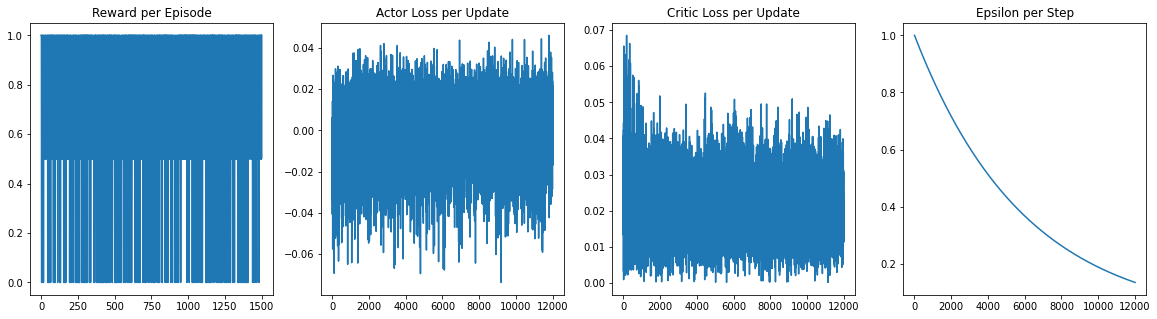

0
2
2
1
1
2
--Rx(3.803)----Rz(0.436)----Rx(4.267)----Rz(2.323)----Rx(3.946)----Rz(1.573)--------S------------S------------S------------------------
                                                                                                                                       
--Ry(3.137)----Rz(5.015)----Ry(2.520)----Rz(2.181)--------S------------S--------Ry(2.108)----Rz(3.404)----Ry(3.277)----Rz(1.084)----S--
                                                                                                                                       
1
0
1
2
1
2
1
[ 5.00000000e-01-5.00000000e-01j  1.89526925e-16-1.11022302e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(2.603)----Rz(5.569)--------S------------S--------------------------------------------------------------------
                                                                                                                  
--Ry(3.730)----Rz(4.974)----Ry(2.731)----Rz(5.336)----S----Ry(2.957)----Rz(1.721)----S----Ry(0.442)--

0
0
0
2
0
1
1
0
--Rx(1.142)----Rz(2.110)----Rx(2.166)----Rz(1.985)----Rx(4.985)----Rz(0.512)----Rx(6.006)----Rz(4.843)----S----Rx(6.170)----Rz(0.302)----Rx(5.420)----Rz(0.764)--
                                                                                                                                                                 
--Ry(2.161)----Rz(2.303)--------S--------Ry(0.559)----Rz(4.336)----Ry(0.725)----Rz(3.610)------------------------------------------------------------------------
                                                                                                                                                                 
1
2
2
1
1
0
0
0
0
2
------S------------S--------Rx(1.807)----Rz(1.767)----Rx(5.005)----Rz(5.664)----Rx(2.144)----Rz(4.435)----Rx(4.651)----Rz(4.616)----S--
                                                                                                                                       
--Ry(1.393)----Rz(4.832)--------S-----------

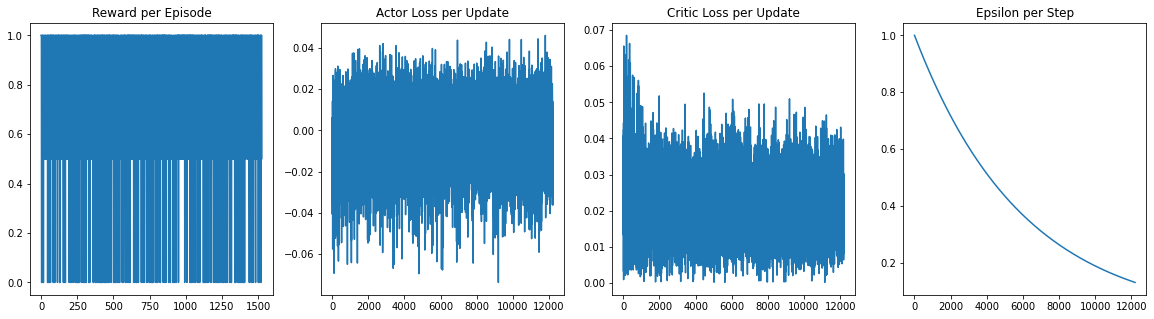

2
0
1
[-5.00000000e-01-5.00000000e-01j -1.89526925e-16-1.66533454e-16j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(5.763)----Rz(5.426)----Rx(2.267)----Rz(4.215)----S----Rx(3.331)----Rz(4.305)--
                                                                                        
--S----Ry(4.083)----Rz(5.428)----Ry(3.967)----Rz(5.039)----S----Ry(4.323)----Rz(5.925)--
                                                                                        
0
1
1
0
0
0
0
1
0
0
--Rx(4.432)----Rz(2.371)----Rx(3.231)----Rz(3.736)----Rx(1.193)----Rz(1.309)----Rx(4.740)----Rz(1.723)----Rx(5.261)----Rz(4.999)----Rx(1.980)----Rz(3.291)----Rx(1.803)----Rz(2.168)--
                                                                                                                                                                                      
--Ry(6.012)----Rz(1.987)----Ry(3.768)----Rz(1.077)----Ry(5.613)----Rz(2.536)-----------------------------------------------------------------------------

1
2
0
2
2
--Rx(3.103)----Rz(2.463)----S----S----Rx(5.774)----Rz(0.139)----S----Rx(3.026)----Rz(1.412)----S----S--
                                                                                                       
--Ry(4.225)----Rz(1.072)----S----S----Ry(0.167)----Rz(0.923)----S--------S------------S----------------
                                                                                                       
2
2
1
2
2
2
2
0
2
0
--S----S--------S------------S--------S----S----Rx(6.007)----Rz(1.769)----S----Rx(2.135)----Rz(1.441)--
                                                                                                       
--S----S----Ry(4.837)----Rz(2.046)----S----S--------S------------S--------S----------------------------
                                                                                                       
0
0
2
0
1
1


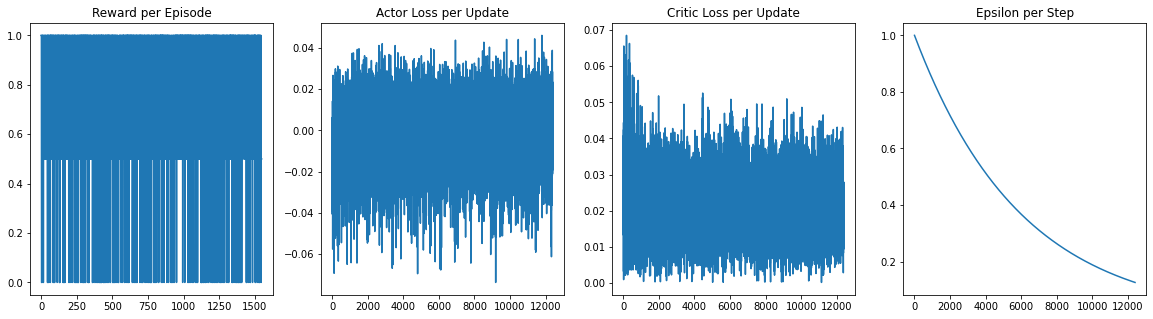

0
1
2
1
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+8.80288308e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.597)----Rz(5.949)----Rx(5.115)----Rz(4.294)--------S--------Rx(4.507)----Rz(4.092)----Rx(2.550)----Rz(2.034)--------S------
                                                                                                                                  
------S--------Ry(2.264)----Rz(4.057)----Ry(0.741)----Rz(5.973)----Ry(2.930)----Rz(3.651)--------S--------Ry(4.953)----Rz(1.361)--
                                                                                                                                  
2
1
1
0
1
0
1
0
1
1
--S----Rx(4.762)----Rz(1.051)----Rx(0.211)----Rz(1.717)----Rx(0.264)----Rz(3.701)--------------------------------------------------------------------------------
                                                                                                                                                                 
--S----Ry(3.802)----Rz(3.

0
2
2
0
2
2
1
0
0
2
--Rx(0.922)----Rz(2.827)----S----S----Rx(1.965)----Rz(5.066)----S----S----Rx(2.799)----Rz(5.170)----Rx(3.874)----Rz(2.312)----S--
                                                                                                                                 
------S------------S--------S----S----Ry(1.109)----Rz(0.397)----S----------------------------------------------------------------
                                                                                                                                 
0
2
1
2
0
1
0
1
1
1
--Rx(5.389)----Rz(1.331)--------S--------S----Rx(4.397)----Rz(2.590)----Rx(0.072)----Rz(6.047)------------------------------------------------------
                                                                                                                                                    
------S--------Ry(4.727)----Rz(6.056)----S----Ry(4.648)----Rz(4.240)----Ry(1.375)----Rz(0.062)----Ry(3.882)----Rz(4.113)----Ry(1.140)----Rz(4.

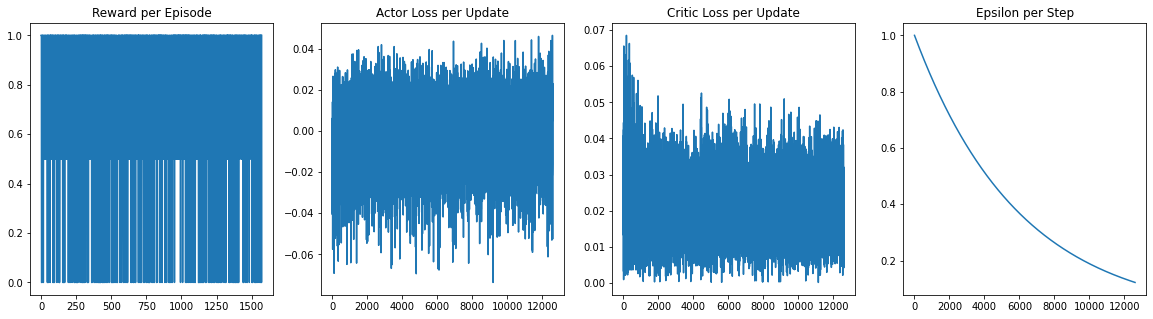

2
0
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--S----Rx(1.612)----Rz(4.778)----S----Rx(0.524)----Rz(2.522)--
                                                              
--S--------S--------------------------------------------------
                                                              
2
1
0
2
2
0
0
1
2
1
--S----Rx(0.952)----Rz(1.473)----S----S----Rx(0.450)----Rz(1.421)----Rx(2.404)----Rz(3.641)--------S------
                                                                                                          
--S----Ry(0.726)----Rz(1.890)----S----S----Ry(0.860)----Rz(1.331)--------S--------Ry(1.477)----Rz(0.532)--
                                                                                                          
1
1
1
0
0
0
0
1
1
0
--Rx(0.926)----Rz(4.741)----Rx(0.643)----Rz(3.476)----Rx(4.073)----Rz(3.328)----Rx(4.066)----Rz(2.836)----Rx(3.246)----Rz(5.270)--
                                          

0
1
2
1
0
[ 5.0000000e-01-5.00000000e-01j -2.7476618e-16-2.77555756e-16j
 -5.0000000e-01-5.00000000e-01j]
--Rx(2.687)----Rz(5.917)----Rx(1.667)----Rz(3.808)----Rx(0.277)----Rz(4.467)----S----Rx(6.132)----Rz(1.328)--
                                                                                                             
--Ry(2.625)----Rz(1.677)----Ry(4.843)----Rz(3.397)----Ry(3.277)----Rz(2.603)----S----Ry(0.938)----Rz(1.265)--
                                                                                                             
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.743)----Rz(3.194)----S----Rx(4.746)----Rz(3.677)--
                                                         
------S--------------------------------------------------
                                                         
0
2
2
0
1
0
1
2
0
2
--Rx(5.082)----Rz(1.957)--------S------------S--------Rx(0.764)----Rz(1.438)----Rx(5.666)----Rz(4

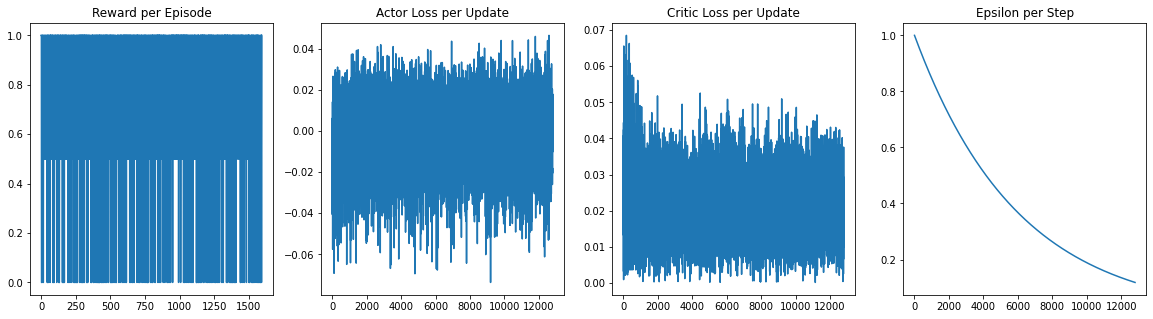

1
--Rx(0.601)----Rz(0.984)--------S--------S--------S------------S--------Rx(0.084)----Rz(2.523)----Rx(4.812)----Rz(2.464)--
                                                                                                                          
------S--------Ry(0.921)----Rz(2.733)----S----Ry(4.541)----Rz(3.088)--------S------------S--------Ry(3.142)----Rz(1.485)--
                                                                                                                          
2
2
1
0
0
1
1
1
1
0
--S----S----Rx(4.120)----Rz(2.334)----Rx(0.692)----Rz(1.353)----Rx(5.168)----Rz(2.720)------------------------------------------------------
                                                                                                                                            
--S----S----Ry(4.656)----Rz(0.102)----Ry(2.971)----Rz(2.849)----Ry(1.292)----Rz(4.350)----Ry(1.334)----Rz(0.115)----Ry(2.130)----Rz(3.377)--
                                                               

0
0
0
--Rx(0.339)----Rz(1.211)----Rx(4.799)----Rz(6.060)----Rx(5.427)----Rz(6.076)----Rx(4.130)----Rz(3.161)----S----Rx(3.748)----Rz(3.316)----Rx(1.471)----Rz(0.933)----Rx(2.467)----Rz(2.302)----Rx(0.882)----Rz(5.537)--
                                                                                                                                                                                                                     
--Ry(3.378)----Rz(5.210)--------S------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                     
2
2
2
2
0
2
1
2
0
1
--S----S----S----S----Rx(4.985)----Rz(3.097)--------S--------S----Rx(4.874)----Rz(2.540)--
                           

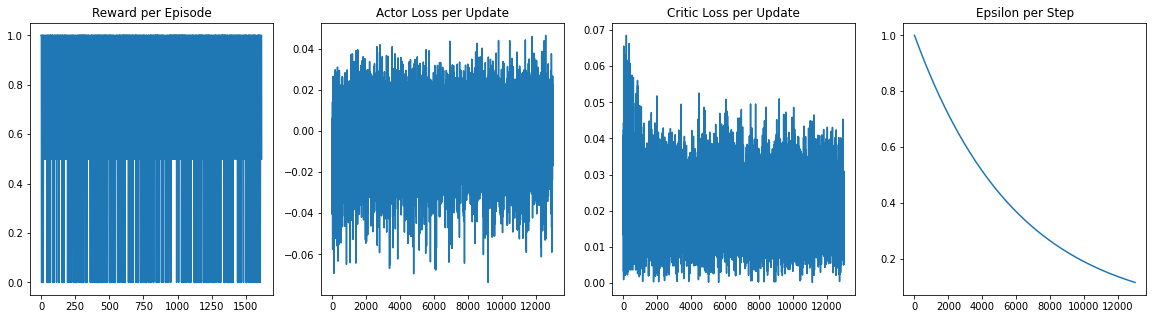

0
1
1
1
2
1
[-5.00000000e-01+5.00000000e-01j  2.77555756e-16-3.25176795e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(6.053)----Rz(5.399)----Rx(1.524)----Rz(4.045)--------S--------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                           
--Ry(4.657)----Rz(6.190)----Ry(3.004)----Rz(0.661)----Ry(5.592)----Rz(2.753)----Ry(6.158)----Rz(5.946)----Ry(0.349)----Rz(2.084)----Ry(4.622)----Rz(3.189)----S----Ry(5.552)----Rz(2.388)--
                                                                                                                                                                                           
2
1
1
1
1
1
0
1
2
2
--S----Rx(0.297)----Rz(5.937)--------S------------S------------------------------------------------------------------

1
2
2
0
0
0
2
2
2
------S------------S--------Rx(0.642)----Rz(3.874)----Rx(2.875)----Rz(1.700)----Rx(3.808)----Rz(1.864)----S----S----S--
                                                                                                                       
--Ry(5.219)----Rz(4.869)----Ry(1.305)----Rz(2.761)--------S------------S------------S------------S--------S------------
                                                                                                                       
1
1
2
2
1
0
1
2
2
2
------S------------S--------Rx(1.555)----Rz(5.235)----S----S--------S------------------------------------------------------------
                                                                                                                                 
--Ry(2.079)----Rz(5.309)----Ry(1.921)----Rz(3.504)----S----S----Ry(1.742)----Rz(3.862)----Ry(4.040)----Rz(1.855)----S----S----S--
                                                                                            

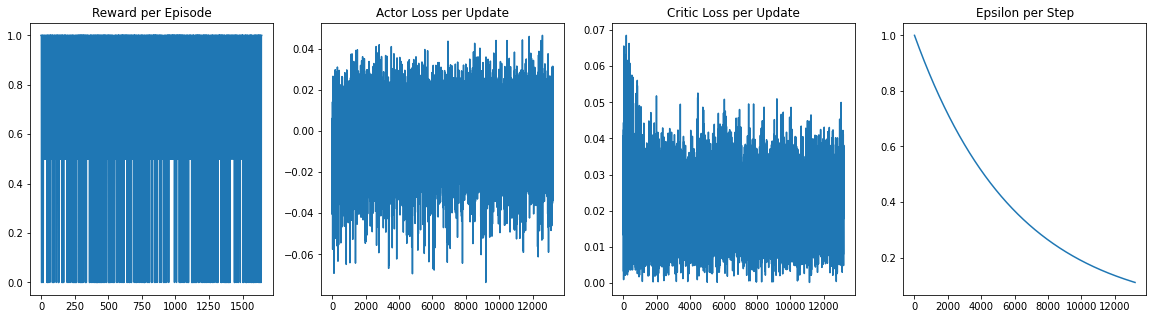

1
1
1
0
1
1
2
--Rx(2.088)----Rz(3.183)----Rx(1.206)----Rz(0.428)--------S--------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                           
--Ry(4.122)----Rz(0.021)----Ry(3.829)----Rz(3.943)----Ry(2.717)----Rz(2.248)----Ry(6.148)----Rz(5.797)----Ry(2.870)----Rz(4.456)----Ry(2.495)----Rz(5.101)----Ry(0.138)----Rz(1.390)----S--
                                                                                                                                                                                           
0
2
1
1
1
1
2
2
2
0
--Rx(3.803)----Rz(5.045)--------S------------S------------S------------S--------Rx(0.442)----Rz(4.454)------------------------------
                                                                                 

1
2
--Rx(2.756)----Rz(3.899)----Rx(5.095)----Rz(1.668)----S----Rx(0.201)----Rz(3.367)----Rx(3.675)----Rz(2.289)----S----S--
                                                                                                                       
--Ry(1.529)----Rz(4.852)----Ry(3.562)----Rz(1.375)----S--------S--------Ry(2.246)----Rz(6.221)--------S----------------
                                                                                                                       
0
1
0
1
1
2
0
1
0
0
--Rx(0.957)----Rz(3.799)----Rx(6.084)----Rz(4.682)--------S--------Rx(2.325)----Rz(0.830)----Rx(3.940)----Rz(4.108)----Rx(3.862)----Rz(2.328)--
                                                                                                                                               
--Ry(1.897)----Rz(1.698)----Ry(5.615)----Rz(0.324)----Ry(4.393)----Rz(5.755)--------S--------Ry(4.628)----Rz(4.336)----------------------------
                                                                

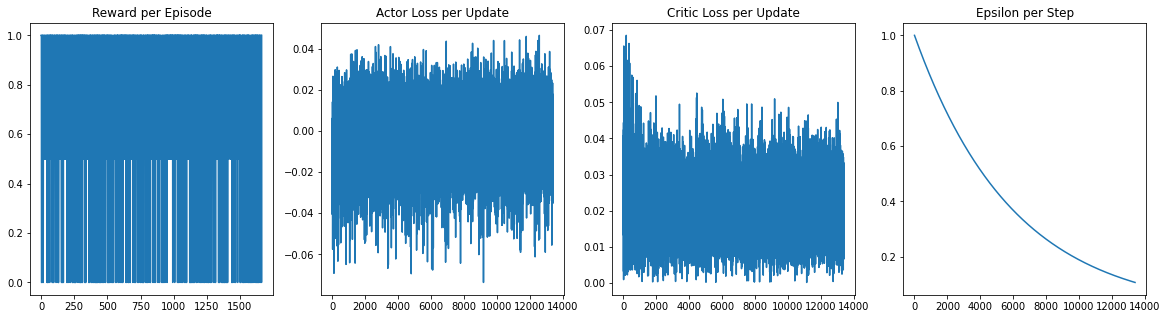

2
1
0
0
0
0
------S--------Rx(4.818)----Rz(0.751)----Rx(1.365)----Rz(0.260)--------S--------Rx(3.928)----Rz(0.935)----Rx(4.617)----Rz(0.090)----Rx(0.909)----Rz(0.588)----Rx(2.524)----Rz(2.536)--
                                                                                                                                                                                      
--Ry(4.071)----Rz(4.715)--------S------------S--------Ry(3.564)----Rz(5.454)----------------------------------------------------------------------------------------------------------
                                                                                                                                                                                      
0
1
0
0
0
0
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+2.22044605e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(3.560)----Rz(3.067)----Rx(5.747)----Rz(5.098)----Rx(0.449)----Rz(5.990)----Rx(3.814)----Rz(6.212)----Rx(2.465)----Rz(0.839)----S----Rx(2

2
2
1
--Rx(2.352)----Rz(0.756)----Rx(1.810)----Rz(2.429)----Rx(5.652)----Rz(2.220)----Rx(3.853)----Rz(2.438)--------S------------S------
                                                                                                                                  
--Ry(4.406)----Rz(0.462)----Ry(4.768)----Rz(5.046)----Ry(3.485)----Rz(0.768)--------S------------S--------Ry(5.120)----Rz(3.172)--
                                                                                                                                  
1
0
0
0
2
2
2
0
1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-1.96261557e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.383)----Rz(5.061)----Rx(4.706)----Rz(5.768)----Rx(0.117)----Rz(2.417)--------S--------S----S----Rx(0.876)----Rz(2.174)--
                                                                                                                               
--Ry(4.251)----Rz(2.369)--------S------------S------------S--------Ry(4.448)----Rz(5.547)--------

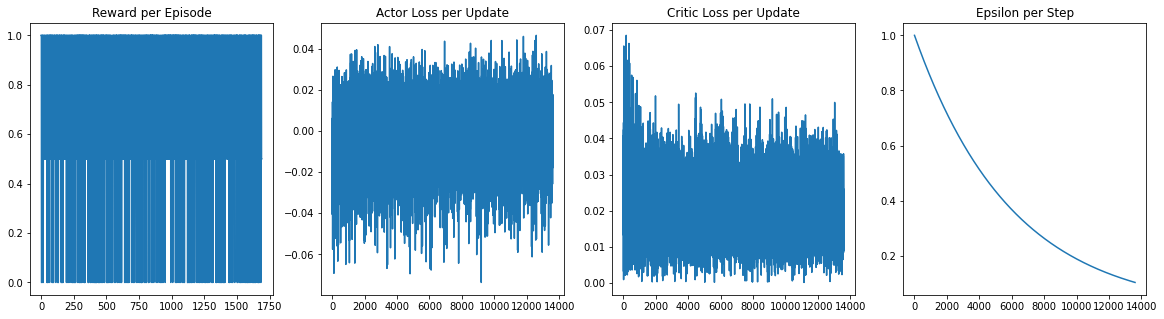

1
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+2.77555756e-16j
  5.00000000e-01+5.00000000e-01j]
------S--------Rx(3.081)----Rz(4.132)--------S------------S------------------------------------------------------------
                                                                                                                       
--Ry(0.789)----Rz(4.717)----Ry(2.240)----Rz(3.373)----Ry(5.016)----Rz(5.161)----S----S----S----Ry(4.818)----Rz(0.139)--
                                                                                                                       
0
1
2
1
1
1
2
0
0
0
--Rx(2.663)----Rz(5.028)----S--------S--------Rx(2.966)----Rz(4.158)----Rx(4.316)----Rz(0.920)----Rx(4.017)----Rz(6.090)--
                                                                                                                          
--Ry(4.545)----Rz(3.600)----S----Ry(3.294)----Rz(1.289)----Ry(2.650)----Rz(2.439)----Ry(0.270)----Rz(1.854)--------S------
                              

--Rx(1.256)----Rz(2.887)----Rx(3.455)----Rz(2.247)----S----Rx(3.362)----Rz(0.919)----Rx(3.308)----Rz(6.107)----Rx(0.357)----Rz(1.487)--
                                                                                                                                       
--Ry(3.030)----Rz(0.198)----Ry(2.625)----Rz(0.012)----S----Ry(1.619)----Rz(2.219)----Ry(3.817)----Rz(5.475)----------------------------
                                                                                                                                       
1
2
2
0
1
1
2
2
0


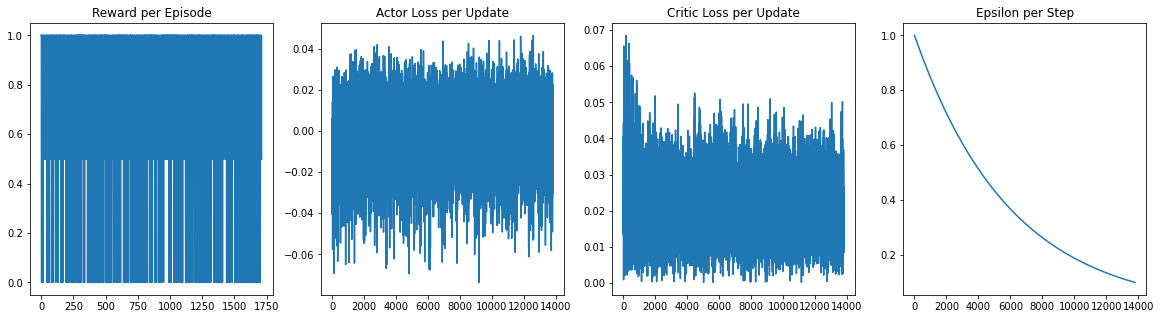

1
------S------------S--------Rx(2.155)----Rz(5.944)--------S------------S--------Rx(1.161)----Rz(2.055)--------------------------------------
                                                                                                                                            
--Ry(6.006)----Rz(2.939)--------S------------S--------Ry(3.427)----Rz(6.204)----Ry(0.877)----Rz(5.708)----S----S----Ry(5.183)----Rz(2.093)--
                                                                                                                                            
1
0
0
0
2
1
[-5.00000000e-01+5.00000000e-01j  5.55111512e-17+1.96261557e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.008)----Rz(1.405)----Rx(2.159)----Rz(0.584)----Rx(2.014)----Rz(5.449)----S--
                                                                                   
--Ry(5.464)----Rz(3.729)--------S--------Ry(0.901)----Rz(4.204)--------------------
                                                                       

2
1
1
0
1
0
0
0
1
0
--S----Rx(2.038)----Rz(2.862)----Rx(5.071)----Rz(1.010)----Rx(4.979)----Rz(3.695)----Rx(2.983)----Rz(0.790)----Rx(4.623)----Rz(5.758)--
                                                                                                                                       
--S----Ry(2.156)----Rz(1.292)----Ry(1.836)----Rz(4.301)----Ry(5.389)----Rz(0.403)----Ry(5.856)----Rz(0.662)----------------------------
                                                                                                                                       
1
1
0
2
1
2
2
1
0
[-0.5-5.00000000e-01j  0. +3.25176795e-17j -0.5+5.00000000e-01j]
--Rx(5.840)----Rz(5.385)--------S------------S--------S----Rx(2.132)----Rz(4.091)--------------------------------------
                                                                                                                       
--Ry(3.701)----Rz(1.521)----Ry(2.608)----Rz(1.934)----S----Ry(1.381)----Rz(2.088)----S----S----Ry(5.682)----Rz(3.

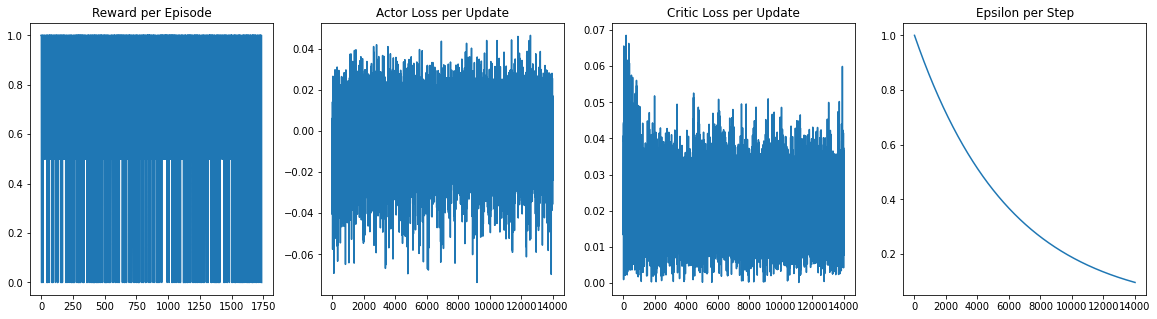

1
0
1
--Rx(2.284)----Rz(3.799)----Rx(2.566)----Rz(0.564)----Rx(0.211)----Rz(5.892)----Rx(4.748)----Rz(3.283)----Rx(3.353)----Rz(5.423)--
                                                                                                                                  
--Ry(0.175)----Rz(2.835)----Ry(3.545)----Rz(0.271)----Ry(1.364)----Rz(3.945)----Ry(1.373)----Rz(0.326)----Ry(4.265)----Rz(4.657)--
                                                                                                                                  
1
1
1
2
0
0
0
0
1
[ 5.00000000e-01-5.00000000e-01j  7.85046229e-17-3.33066907e-16j
 -5.00000000e-01-5.00000000e-01j]
------S--------Rx(0.102)----Rz(1.621)----Rx(3.701)----Rz(1.162)----Rx(3.129)----Rz(0.349)----Rx(1.872)----Rz(3.887)--
                                                                                                                     
--Ry(4.522)----Rz(4.160)----Ry(4.357)----Rz(4.497)----Ry(1.313)----Rz(3.044)--------S--------Ry(5.749)----Rz(5.027)--

1
0
1
1
--S----Rx(6.224)----Rz(0.835)----Rx(3.188)----Rz(0.774)----Rx(6.161)----Rz(2.006)--------------------------------------------------------------------------------
                                                                                                                                                                 
--S----Ry(1.233)----Rz(0.414)----Ry(2.669)----Rz(5.746)----Ry(1.830)----Rz(2.449)----Ry(2.901)----Rz(3.328)----Ry(3.219)----Rz(4.064)----Ry(0.306)----Rz(1.483)--
                                                                                                                                                                 
0
1
2
1
0
[-5.00000000e-01-5.00000000e-01j  7.85046229e-17+1.66533454e-16j
  5.00000000e-01-5.00000000e-01j]
--Rx(2.580)----Rz(0.129)----S----Rx(4.345)----Rz(5.728)--
                                                         
--Ry(5.518)----Rz(1.200)----S----Ry(5.435)----Rz(2.170)--
                                                         
2
2

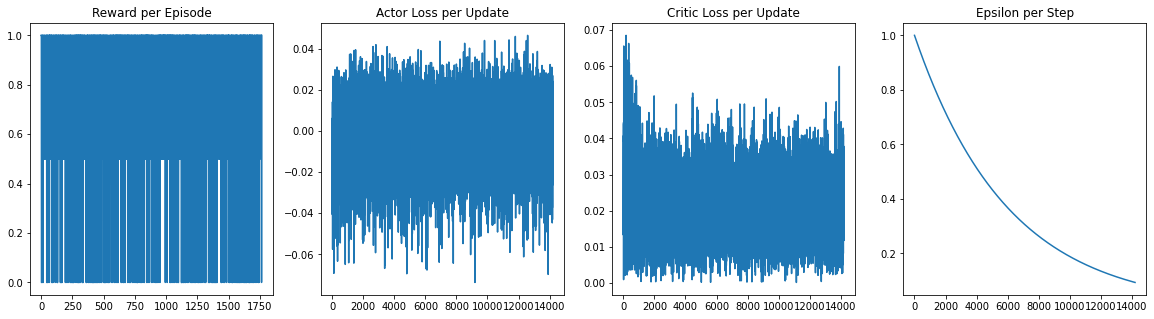

1
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17+1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--S----Rx(2.862)----Rz(0.551)----Rx(5.234)----Rz(1.866)----Rx(2.686)----Rz(6.040)----Rx(1.839)----Rz(0.174)----S----S--
                                                                                                                       
--S--------S--------Ry(5.416)----Rz(3.451)--------S--------Ry(5.289)----Rz(1.141)--------------------------------------
                                                                                                                       
0
0
0
0
1
2
2
2
2
2
--Rx(4.635)----Rz(2.150)----Rx(1.927)----Rz(3.515)----Rx(5.085)----Rz(0.424)----Rx(0.901)----Rz(2.810)----S----S----S----S----S--
                                                                                                                                 
--Ry(0.276)----Rz(2.116)--------S------------S------------S------------S------------S--------------------------------------------
     

--Rx(4.056)----Rz(3.706)--------S--------Rx(5.580)----Rz(5.576)----Rx(3.461)----Rz(3.382)--------------------------------------------------------------------------------
                                                                                                                                                                         
--Ry(3.708)----Rz(0.215)----Ry(1.795)----Rz(1.031)--------S--------Ry(2.433)----Rz(0.775)----Ry(5.303)----Rz(5.744)----Ry(0.129)----Rz(6.135)----Ry(5.530)----Rz(0.291)--
                                                                                                                                                                         
1
1
0
0
1
1
0
1
2
2
--Rx(3.170)----Rz(3.019)----Rx(3.916)----Rz(0.696)----Rx(0.295)----Rz(2.486)--------S------------S------------------------------------------
                                                                                                                                            
--Ry(5.968)----Rz(

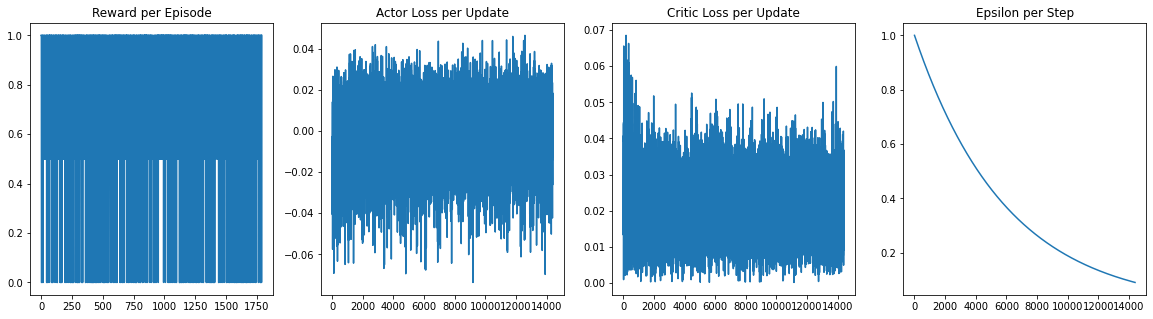

0
0
0
1
--Rx(4.974)----Rz(3.010)----Rx(1.520)----Rz(3.544)--------S------------S--------Rx(2.398)----Rz(6.213)----Rx(2.977)----Rz(4.260)----Rx(5.650)----Rz(0.106)--
                                                                                                                                                            
------S------------S--------Ry(1.769)----Rz(0.330)----Ry(0.126)----Rz(5.493)----Ry(2.480)----Rz(0.126)------------------------------------------------------
                                                                                                                                                            
2
1
2
2
0
2
2
0
2
2
--S--------S------------S--------Rx(5.207)----Rz(2.645)----S----S----Rx(4.049)----Rz(0.540)----S----S--
                                                                                                       
--S----Ry(3.294)----Rz(1.047)--------S------------S--------S----S--------S------------S----------------
                                

0
2
1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(4.670)----Rz(4.259)----S----------------------------
                                                         
--Ry(3.743)----Rz(3.933)----S----Ry(0.560)----Rz(3.485)--
                                                         
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(5.958)----Rz(1.444)----S----Ry(2.521)----Rz(2.355)--
                                                         
1
0
2
0
0
0
0
1
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(4.678)----Rz(3.530)----S----Rx(4.097)----Rz(0.696)----Rx(6.191)----Rz(3.056)----Rx(1.298)----Rz(4.725)----Rx(3.447)----Rz(2.438)--
                                                                           

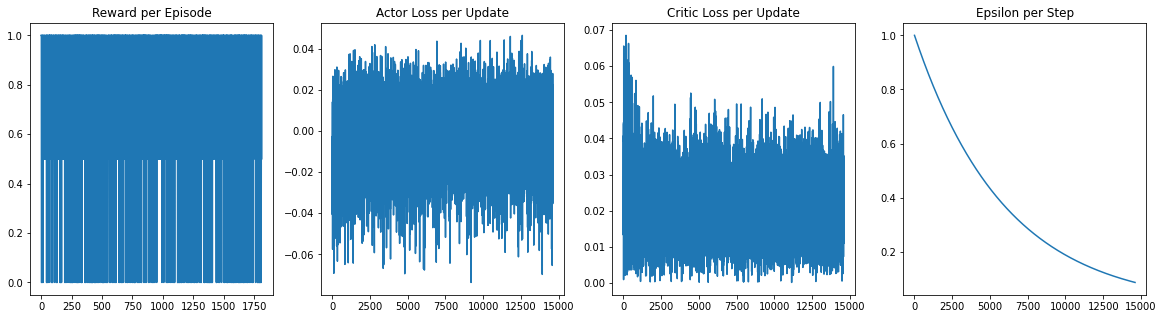

1
2
2
2
2
0
0
1
--Rx(5.532)----Rz(4.937)--------S------------S--------S----S----Rx(3.761)----Rz(2.856)----Rx(5.394)----Rz(2.645)--
                                                                                                                  
--Ry(2.574)----Rz(5.964)----Ry(5.648)----Rz(1.419)----S----S--------S------------S--------Ry(5.163)----Rz(6.069)--
                                                                                                                  
0
1
0
0
1
0
2
1
0
2
--Rx(5.223)----Rz(0.750)----Rx(3.771)----Rz(1.225)----Rx(3.175)----Rz(4.908)----Rx(3.309)----Rz(2.215)----S----Rx(1.760)----Rz(0.361)----S--
                                                                                                                                            
--Ry(4.462)----Rz(5.895)----Ry(1.005)----Rz(1.955)--------S--------Ry(2.343)----Rz(6.198)--------S------------------------------------------
                                                                                 

0
0
1
1
0
2
2
2
0
[0.5-5.00000000e-01j 0. +2.45038077e-16j 0.5+5.00000000e-01j]
--Rx(2.308)----Rz(4.958)----Rx(2.560)----Rz(5.588)----Rx(3.109)----Rz(5.718)----S----S----S----Rx(5.458)----Rz(6.250)--
                                                                                                                       
--Ry(5.788)----Rz(1.213)----Ry(6.228)----Rz(6.149)--------S------------S--------S--------------------------------------
                                                                                                                       
1
0
2
1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.882)----Rz(4.417)----S----------------------------
                                                         
--Ry(2.872)----Rz(1.930)----S----Ry(3.431)----Rz(3.514)--
                                                         
1
1
1
0
0
1
0
0
2
0
--Rx(5.110)----Rz(2.270)----Rx(2.771)----Rz(2.422)----Rx(0.053)----Rz(1.403)----R

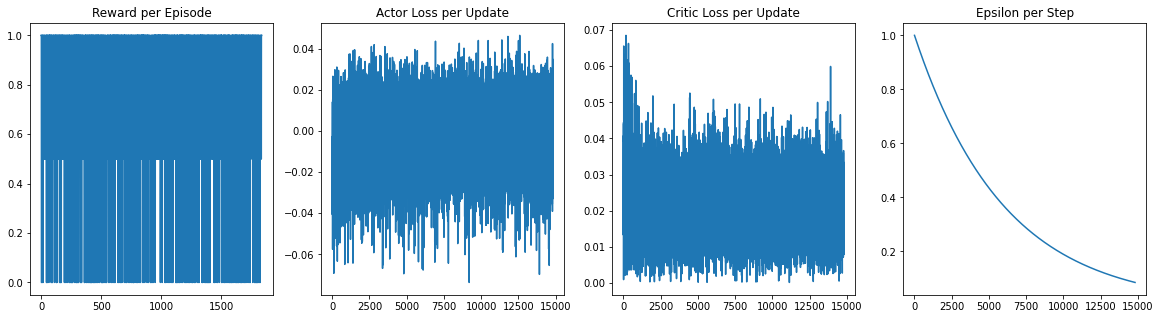

2
1
[-5.00000000e-01-5.00000000e-01j  1.11022302e-16-2.35513869e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.945)----Rz(4.720)----Rx(2.147)----Rz(3.301)----S----Rx(5.288)----Rz(2.631)----S----Rx(2.757)----Rz(5.865)----S--
                                                                                                                       
--Ry(4.044)----Rz(1.337)--------S------------S--------S----Ry(4.191)----Rz(5.811)--------------------------------------
                                                                                                                       
1
0
2
2
2
0
1
[-5.00000000e-01+5.00000000e-01j  1.66533454e-16+7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(3.825)----Rz(1.527)----S----S----S----Rx(0.115)----Rz(6.262)--
                                                                   
--Ry(3.752)----Rz(0.499)----S----S----S----Ry(3.658)----Rz(4.785)--
                                                                   
1
1
1
1
1
0
2
1
[0.5-5.00000000e

0
1
1
2
2
1
--Rx(4.789)----Rz(3.590)----Rx(3.150)----Rz(0.996)--------S------------S----------------------------------------------------------------------------------------------
                                                                                                                                                                      
--Ry(0.076)----Rz(0.409)----Ry(2.130)----Rz(0.474)----Ry(0.246)----Rz(2.452)----Ry(6.095)----Rz(5.648)----Ry(4.197)----Rz(5.706)----S----S----Ry(3.820)----Rz(3.887)--
                                                                                                                                                                      
0
1
1
2
0
[5.00000000e-01+5.00000000e-01j 1.11022302e-16+7.85046229e-17j
 5.00000000e-01-5.00000000e-01j]
--Rx(2.484)----Rz(1.283)--------S--------Rx(0.099)----Rz(0.709)--
                                                                 
--Ry(1.016)----Rz(2.272)----Ry(5.710)----Rz(4.505)--------S------
                

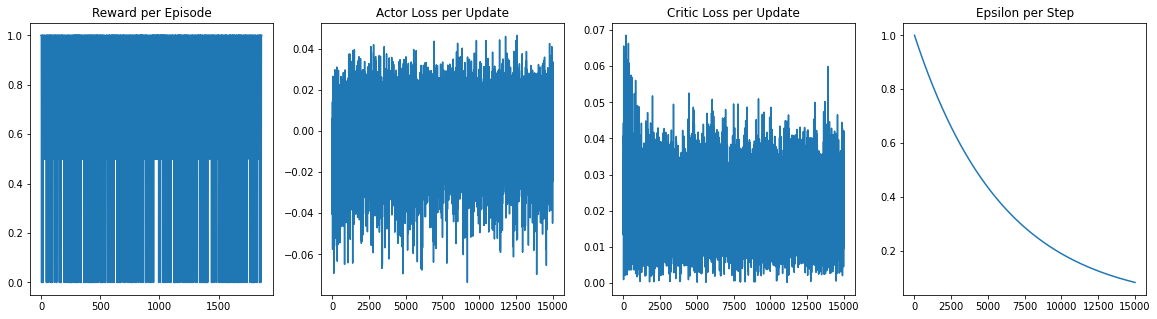

2
1
1
--Rx(1.904)----Rz(1.578)----Rx(0.386)----Rz(4.542)--------S--------Rx(3.169)----Rz(4.997)----S------------------------------------------------------
                                                                                                                                                    
------S--------Ry(5.251)----Rz(0.821)----Ry(3.040)----Rz(1.743)----Ry(0.213)----Rz(2.702)----S----Ry(5.105)----Rz(1.597)----Ry(4.317)----Rz(4.900)--
                                                                                                                                                    
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(1.618)----Rz(3.835)----S----Ry(0.794)----Rz(0.757)--
                                                         
0
0
0
1
0
0
0
0
1
2
--Rx(1.428)----Rz(3.440)----Rx(1.239)----

1
1
1
2
0
[ 5.00000000e-01+5.00000000e-01j -2.35513869e-16-2.22044605e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.106)----Rz(5.233)--------S--------Rx(4.961)----Rz(2.833)------------------------------------------------------------------------
                                                                                                                                       
--Ry(2.566)----Rz(5.918)----Ry(6.071)----Rz(0.459)----Ry(0.818)----Rz(2.893)----Ry(6.129)----Rz(0.560)----Ry(2.170)----Rz(3.338)----S--
                                                                                                                                       
0
1
1
0
2
0
1
1
2
0
[-5.0000000e-01-5.00000000e-01j -1.3738309e-16+2.77555756e-16j
  5.0000000e-01-5.00000000e-01j]
--Rx(6.178)----Rz(0.273)----Rx(6.058)----Rz(4.009)----S----Rx(4.323)----Rz(3.833)--------S--------Rx(0.643)----Rz(0.067)--
                                                                                                            

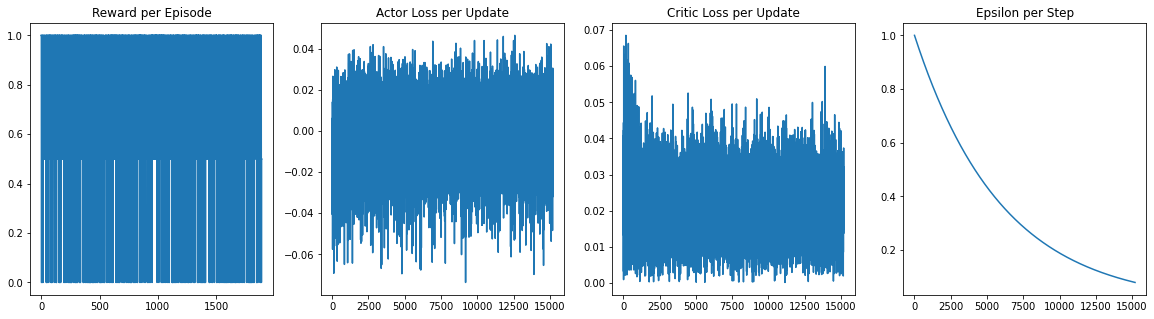

1
0
1
2
0
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17-5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--Rx(3.530)----Rz(1.295)--------S--------Rx(4.705)----Rz(0.961)--------------------
                                                                                   
--Ry(1.376)----Rz(0.860)----Ry(2.449)----Rz(4.370)----Ry(3.259)----Rz(4.593)----S--
                                                                                   
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.596)----Rz(4.998)----S----Rx(0.338)----Rz(3.590)--
                                                         
------S--------------------------------------------------
                                                         
1
1
1
1
1
2
0
1
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
------S--------Rx(2.496)----Rz(5.657)------------------------------------------------------------------

1
------S------------S--------Rx(4.091)----Rz(4.240)----Rx(3.529)----Rz(6.108)----Rx(0.620)----Rz(3.481)----Rx(4.629)----Rz(1.619)--
                                                                                                                                  
--Ry(1.187)----Rz(2.812)--------S------------S--------Ry(3.768)----Rz(5.290)----Ry(0.149)----Rz(5.087)----Ry(6.033)----Rz(5.806)--
                                                                                                                                  
2
1
2
2
0
1
2
2
1
0
--S--------S------------S--------Rx(5.089)----Rz(4.547)--------S------------S--------Rx(3.218)----Rz(5.607)----------------------------
                                                                                                                                       
--S----Ry(5.188)----Rz(0.427)--------S------------S--------Ry(3.819)----Rz(1.236)--------S------------S--------Ry(2.746)----Rz(2.765)--
                                              

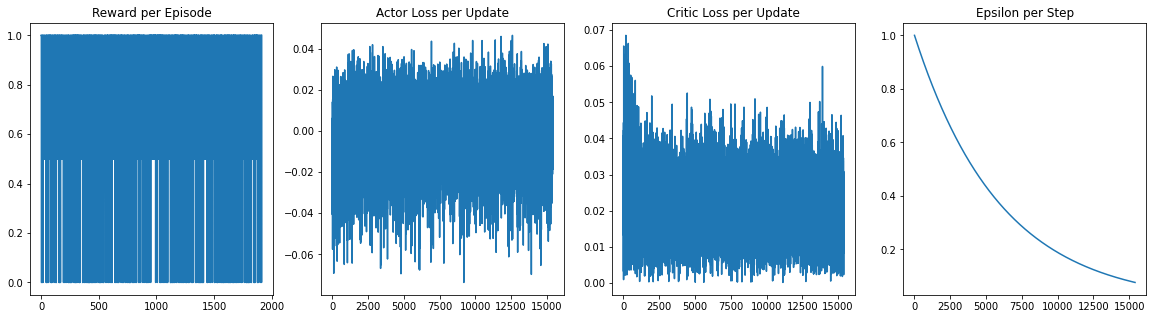

2
1
1
1
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17-1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(6.224)----Rz(0.012)----Rx(5.365)----Rz(5.901)----Rx(1.235)----Rz(1.322)--------S--------Rx(1.360)----Rz(3.093)--
                                                                                                                     
--Ry(5.022)----Rz(4.713)--------S--------Ry(1.321)----Rz(2.749)----Ry(2.361)----Rz(2.784)----Ry(0.953)----Rz(0.358)--
                                                                                                                     
2
0
2
1
2
1
0
0
0
2
--S----Rx(4.110)----Rz(1.790)--------S--------S----Rx(2.293)----Rz(2.677)----Rx(3.623)----Rz(2.648)----Rx(2.117)----Rz(5.087)----S--
                                                                                                                                    
--S--------S--------Ry(2.520)----Rz(2.341)----S----Ry(0.981)----Rz(5.028)--------S--------------------------------------------------


1
1
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-2.35513869e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.627)----Rz(0.859)----Rx(3.728)----Rz(2.332)--------S--------Rx(1.778)----Rz(0.882)--------------------------------------------------------------------------------
                                                                                                                                                                         
--Ry(2.066)----Rz(1.637)----Ry(4.385)----Rz(0.352)----Ry(1.636)----Rz(0.842)--------S--------Ry(4.500)----Rz(5.178)----Ry(3.596)----Rz(1.243)----Ry(0.776)----Rz(5.508)--
                                                                                                                                                                         
1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                    

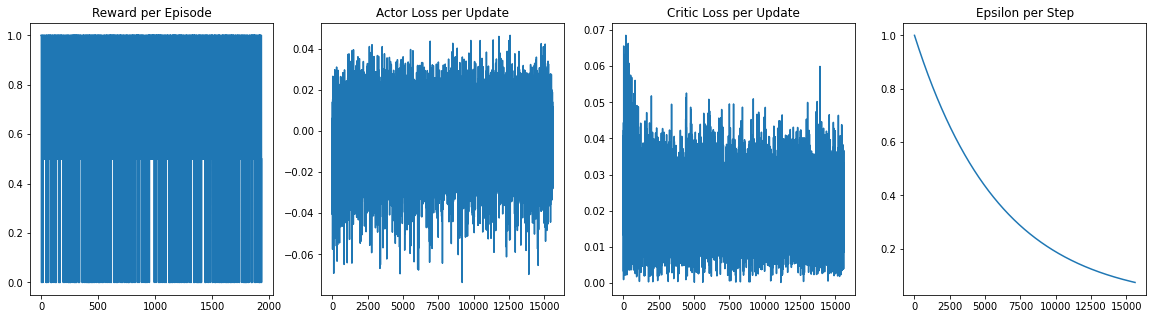

0
2
0
[0.5-5.00000000e-01j 0. +5.88784672e-17j 0.5+5.00000000e-01j]
--S----Rx(1.348)----Rz(0.332)----Rx(4.211)----Rz(2.674)----S----S----Rx(4.320)----Rz(5.690)----S----Rx(2.168)----Rz(1.948)--
                                                                                                                            
--S----Ry(2.210)----Rz(1.127)--------S------------S--------S----------------------------------------------------------------
                                                                                                                            
0
0
0
0
0
1
1
1
0
1
--Rx(5.912)----Rz(5.407)----Rx(1.427)----Rz(1.672)----Rx(3.068)----Rz(3.452)----Rx(5.597)----Rz(1.660)----Rx(5.658)----Rz(1.951)----Rx(0.310)----Rz(6.243)--
                                                                                                                                                            
--Ry(2.313)----Rz(5.902)----Ry(3.924)----Rz(1.714)----Ry(0.009)----Rz(1.501)----Ry(0.763)----Rz(3.

1
2
1
[-5.00000000e-01+5.00000000e-01j  1.66533454e-16+2.35513869e-16j
 -5.00000000e-01-5.00000000e-01j]
--S----Rx(6.135)----Rz(2.981)----Rx(3.354)----Rz(4.034)----Rx(3.442)----Rz(1.898)--------S--------------------------------------------------
                                                                                                                                            
--S----Ry(2.980)----Rz(1.623)----Ry(3.653)----Rz(1.485)----Ry(6.117)----Rz(0.150)----Ry(5.472)----Rz(5.855)----S----Ry(5.236)----Rz(2.023)--
                                                                                                                                            
2
2
0
2
0
[5.00000000e-01+5.00000000e-01j 5.55111512e-17+7.85046229e-17j
 5.00000000e-01-5.00000000e-01j]
--S----S----Rx(2.493)----Rz(5.663)----S----Rx(0.747)----Rz(2.204)--
                                                                   
--S----S--------S--------------------------------------------------
                     

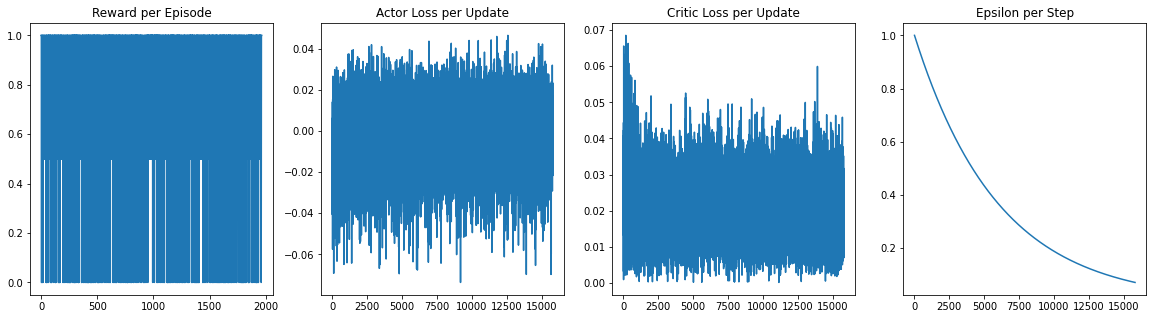

0
2
0
0
2
1
1
1
--S----Rx(4.252)----Rz(2.816)----S----Rx(0.034)----Rz(1.678)----Rx(5.167)----Rz(6.230)--------S--------------------------------
                                                                                                                               
--S----Ry(1.484)----Rz(0.559)----S--------S--------Ry(5.652)----Rz(3.266)----Ry(6.096)----Rz(1.861)----Ry(3.209)----Rz(0.038)--
                                                                                                                               
2
1
1
1
0
2
0
1
[ 5.00000000e-01+5.00000000e-01j -1.96261557e-16-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--S----Rx(0.833)----Rz(4.131)--------S--------Rx(3.964)----Rz(6.013)----------------------------------------------
                                                                                                                  
--S----Ry(2.928)----Rz(4.890)----Ry(0.793)----Rz(4.055)----Ry(0.520)----Rz(1.522)----S----Ry(5.489)----Rz(2.149)--
            

0
1
0
2
--Rx(4.647)----Rz(5.590)--------S------------S--------Rx(2.067)----Rz(2.651)----Rx(2.467)----Rz(3.789)----Rx(5.012)----Rz(0.627)----S--
                                                                                                                                       
------S------------S--------Ry(1.403)----Rz(4.697)----Ry(2.864)----Rz(3.322)----Ry(1.367)----Rz(5.966)--------S------------------------
                                                                                                                                       
1
0
1
0
1
2
0
[5.00000000e-01-5.00000000e-01j 5.55111512e-17-7.85046229e-17j
 5.00000000e-01+5.00000000e-01j]
--Rx(3.222)----Rz(4.726)----Rx(3.342)----Rz(0.287)--------S--------Rx(1.591)----Rz(4.597)--
                                                                                           
--Ry(1.489)----Rz(6.035)----Ry(2.712)----Rz(3.512)----Ry(3.373)----Rz(3.734)--------S------
                                                              

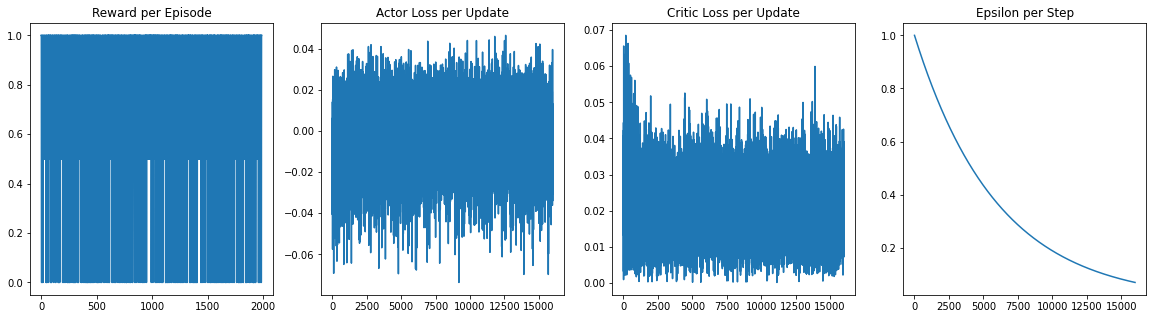

1
1
0
1
1
2
0
[5.00000000e-01+5.00000000e-01j 1.11022302e-16+3.14018492e-16j
 5.00000000e-01-5.00000000e-01j]
--Rx(4.131)----Rz(2.919)--------S--------Rx(1.989)----Rz(2.280)--------------------------------------------------------------------------------------------------
                                                                                                                                                                 
--Ry(1.488)----Rz(2.443)----Ry(3.626)----Rz(3.477)----Ry(3.865)----Rz(5.600)----Ry(3.154)----Rz(1.726)----Ry(3.666)----Rz(6.165)----Ry(0.673)----Rz(4.889)----S--
                                                                                                                                                                 
1
1
1
1
1
0
2
1
[0.5-5.00000000e-01j 0. +7.85046229e-17j 0.5+5.00000000e-01j]
--Rx(1.063)----Rz(4.247)--------S--------------------------------------------------------------------------------------------------------------------------------
  

1
0
1
2
1
--Rx(1.060)----Rz(0.124)----Rx(1.369)----Rz(1.368)----S----Rx(0.267)----Rz(2.803)--------S--------------------------------------------------
                                                                                                                                            
--Ry(3.707)----Rz(2.114)----Ry(4.286)----Rz(0.343)----S----Ry(1.985)----Rz(1.181)----Ry(0.540)----Rz(3.258)----S----Ry(3.663)----Rz(1.989)--
                                                                                                                                            
2
0
0
0
2
2
1
0
1
0
--S----Rx(4.272)----Rz(5.781)----Rx(2.033)----Rz(6.180)----Rx(3.888)----Rz(6.043)----S----S----Rx(1.731)----Rz(2.256)----Rx(4.572)----Rz(0.843)--
                                                                                                                                                 
--S--------S------------S--------Ry(2.725)----Rz(3.573)----Ry(5.095)----Rz(1.486)---------------------------------

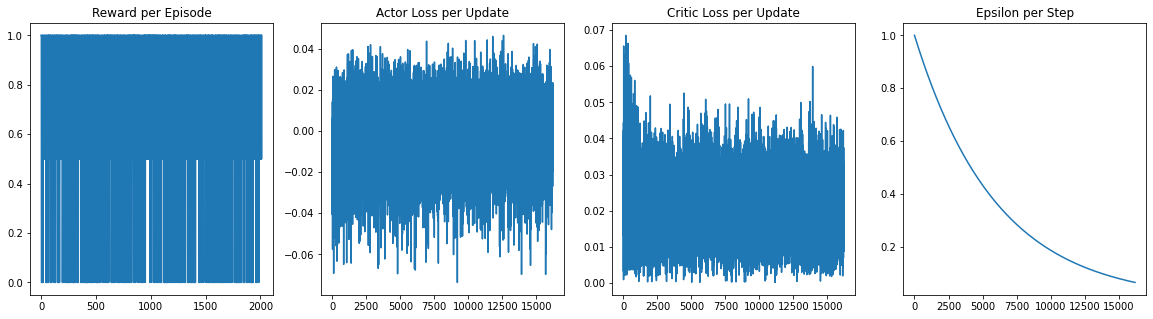

0
--Rx(1.101)----Rz(5.974)----Rx(1.229)----Rz(1.378)----Rx(2.929)----Rz(2.069)----------------------------------------------------------------------------------------------------------
                                                                                                                                                                                      
--Ry(2.282)----Rz(4.368)----Ry(0.185)----Rz(0.648)----Ry(2.852)----Rz(2.357)----Ry(4.635)----Rz(1.802)----Ry(1.474)----Rz(1.155)----Ry(0.512)----Rz(6.189)----Ry(5.232)----Rz(0.494)--
                                                                                                                                                                                      
1
2
2
2
2
0
1
0
1
0
------S------------S--------S----S----Rx(4.188)----Rz(0.188)----Rx(5.962)----Rz(1.244)----Rx(4.489)----Rz(3.304)--
                                                                                                                  
--Ry(0.743)----R

0
1
1
0
0
0
2
0
[-5.00000000e-01+5.00000000e-01j -1.66533454e-16+8.80288308e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(4.962)----Rz(1.477)----Rx(3.154)----Rz(2.681)----Rx(4.846)----Rz(3.974)----Rx(4.182)----Rz(0.732)----Rx(4.756)----Rz(3.149)----S----Rx(4.414)----Rz(3.975)--
                                                                                                                                                                 
--Ry(0.699)----Rz(0.610)----Ry(3.367)----Rz(0.218)--------S------------------------------------------------------------------------------------------------------
                                                                                                                                                                 
1
0
2
0
1
[-5.00000000e-01-5.00000000e-01j  5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.297)----Rz(3.572)----S----Rx(0.199)----Rz(3.940)--
                                                         
--Ry(1.536)-

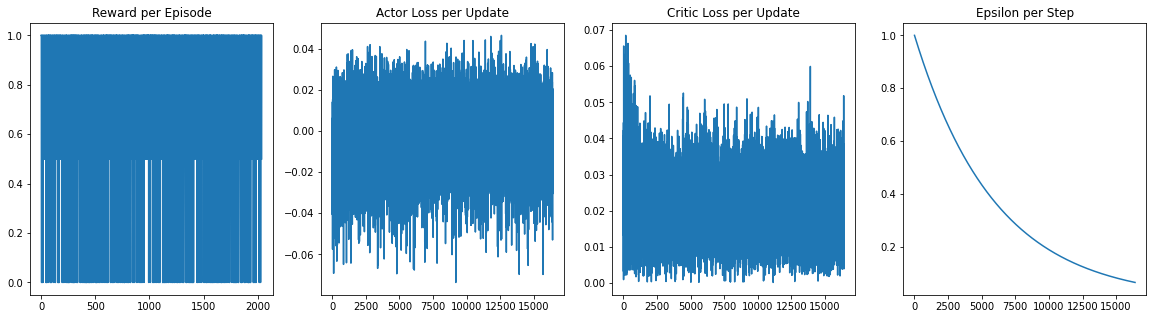

1
0
1
2
2
--S----Rx(0.021)----Rz(0.254)----Rx(5.081)----Rz(0.550)----Rx(0.750)----Rz(5.114)--------S------------S----------------
                                                                                                                       
--S----Ry(4.416)----Rz(0.373)----Ry(2.770)----Rz(2.853)----Ry(2.442)----Rz(2.320)----Ry(1.372)----Rz(1.014)----S----S--
                                                                                                                       
0
2
1
1
2
2
1
2
1
1
--Rx(5.651)----Rz(4.929)--------S------------S------------S--------S------------------------------------------------------------------------------------------
                                                                                                                                                              
------S--------Ry(1.299)----Rz(2.511)----Ry(5.567)----Rz(1.359)----S----S----Ry(4.962)----Rz(5.665)----S----Ry(3.320)----Rz(0.701)----Ry(0.511)----Rz(5.123)--
             

0
2
1
2
--Rx(0.030)----Rz(3.699)----S--------S--------Rx(1.752)----Rz(3.166)--------S------------S------------------------------------------
                                                                                                                                    
--Ry(3.483)----Rz(1.062)----S----Ry(3.788)----Rz(5.069)--------S--------Ry(1.432)----Rz(5.583)----S----Ry(4.388)----Rz(6.198)----S--
                                                                                                                                    
0
0
2
2
1
2
0
2
1
0
--Rx(5.402)----Rz(5.089)----Rx(0.692)----Rz(5.108)----S----S--------S--------Rx(0.009)----Rz(4.773)----S----Rx(5.894)----Rz(4.577)--
                                                                                                                                    
------S------------S--------Ry(1.082)----Rz(5.820)----S----S----Ry(1.702)----Rz(6.156)----------------------------------------------
                                         

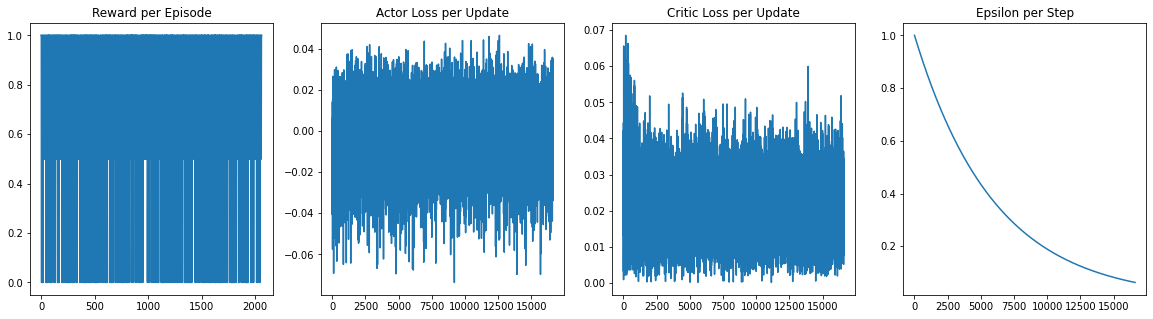

1
0
0
2
1
[-5.00000000e-01+5.00000000e-01j -5.88784672e-17-3.33066907e-16j
  5.00000000e-01+5.00000000e-01j]
--S----Rx(4.928)----Rz(4.309)----Rx(5.125)----Rz(1.906)----Rx(5.886)----Rz(1.987)----S----------------------------
                                                                                                                  
--S----Ry(4.682)----Rz(6.171)----Ry(5.954)----Rz(4.135)----Ry(2.660)----Rz(3.393)----S----Ry(4.910)----Rz(4.431)--
                                                                                                                  
1
2
0
1
[-5.00000000e-01+0.5j -7.85046229e-17+0.j   5.00000000e-01+0.5j]
------S--------Rx(2.594)----Rz(1.754)----------------------------
                                                                 
--Ry(5.552)----Rz(0.749)--------S--------Ry(3.516)----Rz(5.022)--
                                                                 
0
0
2
1
0
0
1
1
0
0
--Rx(0.098)----Rz(4.360)----Rx(2.406)----Rz(3.677)--------S--------Rx(5.13

0
1
0
1
0
0
1
0
2
--Rx(4.944)----Rz(2.723)----Rx(0.791)----Rz(2.431)----Rx(6.017)----Rz(2.622)----Rx(0.085)----Rz(5.301)----Rx(4.292)----Rz(4.968)----S--
                                                                                                                                       
--Ry(2.155)----Rz(0.057)----Ry(2.395)----Rz(6.001)----Ry(4.776)----Rz(3.362)----Ry(5.637)----Rz(1.876)--------S------------------------
                                                                                                                                       
2
1
1
0
1
0
1
1
0
0
--S----Rx(4.934)----Rz(5.199)----Rx(5.601)----Rz(5.395)----Rx(4.646)----Rz(5.859)----Rx(4.587)----Rz(1.214)----------------------------
                                                                                                                                       
--S----Ry(2.740)----Rz(5.659)----Ry(2.674)----Rz(2.540)----Ry(6.048)----Rz(1.784)----Ry(1.232)----Rz(5.267)----Ry(0.650)----Rz(5.094)--
          

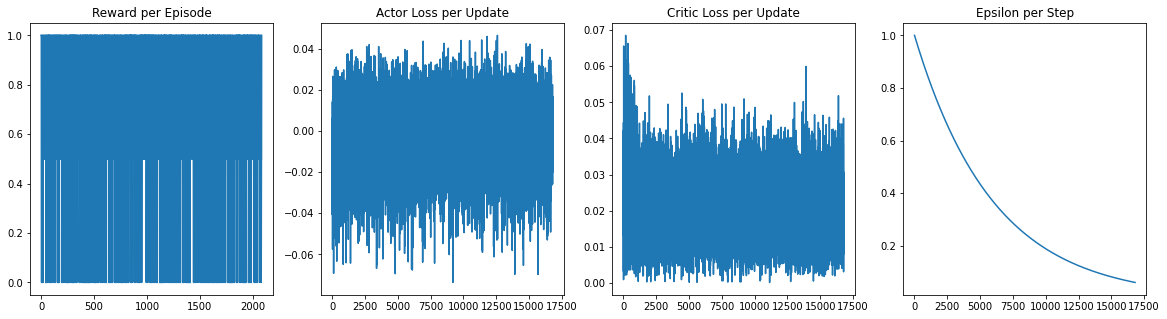

1
2
0
--S----Rx(1.794)----Rz(1.225)----Rx(1.784)----Rz(5.076)----Rx(1.559)----Rz(2.761)----Rx(5.508)----Rz(3.262)----S----Rx(5.365)----Rz(1.916)--
                                                                                                                                            
--S----Ry(5.355)----Rz(1.253)----Ry(4.873)----Rz(5.982)----Ry(0.563)----Rz(5.671)--------S--------------------------------------------------
                                                                                                                                            
1
0
1
2
1
1
0
2
2
0
--Rx(0.093)----Rz(0.489)--------S--------Rx(1.958)----Rz(3.945)--------S------------S--------Rx(4.332)----Rz(3.408)------------
                                                                                                                               
--Ry(3.731)----Rz(6.067)----Ry(0.926)----Rz(4.802)--------S--------Ry(5.665)----Rz(1.694)----Ry(1.398)----Rz(3.866)----S----S--
                          

0
1
0
0
0
2
1
[ 5.00000000e-01+5.00000000e-01j -1.66533454e-16-1.17756934e-16j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(4.167)----Rz(2.808)----Rx(5.872)----Rz(5.586)----Rx(4.158)----Rz(4.804)----Rx(2.456)----Rz(2.181)----Rx(3.309)----Rz(2.111)----S--
                                                                                                                                            
--S----Ry(3.583)----Rz(3.013)----Ry(6.117)----Rz(0.417)--------S--------Ry(3.460)----Rz(2.119)----------------------------------------------
                                                                                                                                            
1
1
2
2
0
1
1
1
2
1
------S------------S--------Rx(0.348)----Rz(1.342)----S--------------------------------------------------------------------------------------------------------------------
                                                                                                                                   

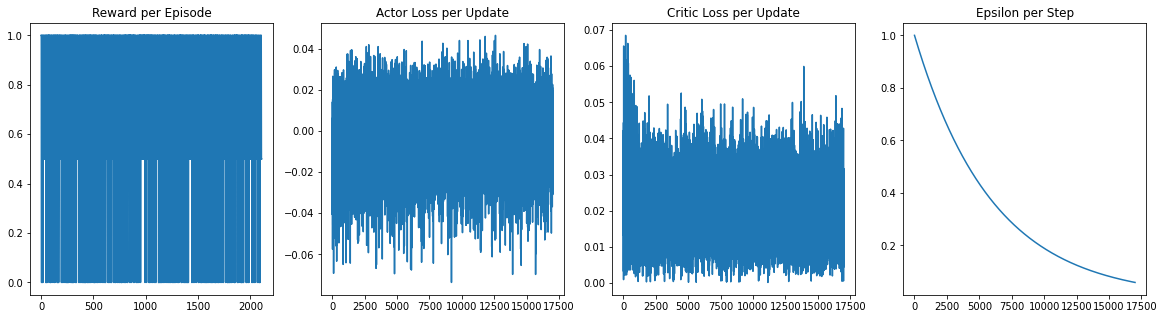

1
2
0
2
2
2
1
--S----Rx(2.560)----Rz(5.613)--------S--------S----Rx(4.253)----Rz(0.574)----S--------S------------S------
                                                                                                          
--S--------S--------Ry(5.349)----Rz(4.178)----S--------S------------S--------S----Ry(0.392)----Rz(2.054)--
                                                                                                          
1
0
0
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.369)----Rz(4.808)----Rx(2.321)----Rz(5.994)--------S------
                                                                 
--Ry(5.173)----Rz(6.205)--------S--------Ry(1.224)----Rz(2.426)--
                                                                 
2
0
0
1
1
2
1
1
2
0
--S----Rx(2.435)----Rz(5.045)----Rx(2.374)----Rz(4.433)----S--------S--------Rx(2.811)----Rz(4.854)--------------------
                                             

--Rx(4.100)----Rz(6.014)----Rx(1.782)----Rz(5.997)----Rx(0.070)----Rz(3.723)----S----Rx(3.816)----Rz(1.462)--
                                                                                                             
--Ry(3.336)----Rz(0.813)--------S--------Ry(4.983)----Rz(6.226)----------------------------------------------
                                                                                                             
1
0
0
2
0
1
[ 5.00000000e-01-0.5j  7.85046229e-17+0.j  -5.00000000e-01-0.5j]
--Rx(2.415)----Rz(0.874)----Rx(2.222)----Rz(3.014)--------S--------Rx(4.937)----Rz(4.253)--
                                                                                           
--Ry(2.362)----Rz(0.556)--------S--------Ry(2.340)----Rz(3.471)----------------------------
                                                                                           
0
1
0
2
0
1
0
1
2
1
[-5.00000000e-01+5.00000000e-01j  2.77555756e-16+1.89526925e-16j
 -5.00000000e-01-5.00000000e-0

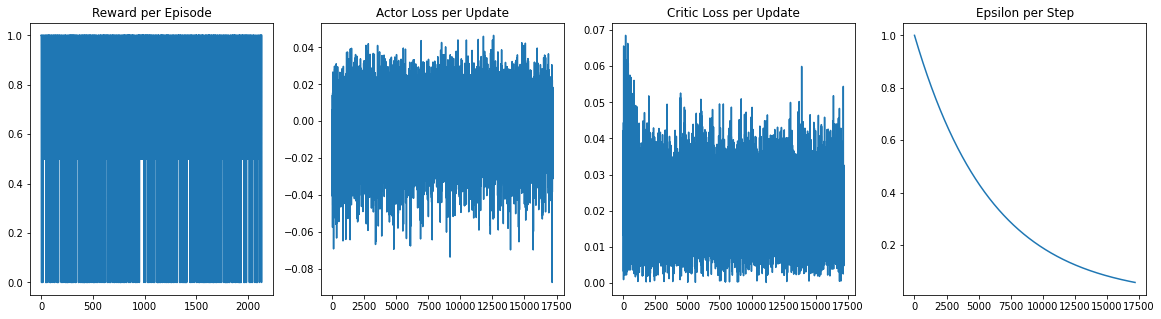

0
0
2
1
[ 5.00000000e-01+5.00000000e-01j  7.85046229e-17-1.11022302e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(2.801)----Rz(4.286)----Rx(3.677)----Rz(2.818)--------S------
                                                                 
--Ry(1.877)----Rz(3.330)--------S--------Ry(0.770)----Rz(5.598)--
                                                                 
0
1
1
0
0
2
1
0
[-5.00000000e-01-5.00000000e-01j -3.33066907e-16-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(3.293)----Rz(0.532)----Rx(0.994)----Rz(5.502)----Rx(1.918)----Rz(2.675)--------S--------Rx(1.092)----Rz(3.776)--
                                                                                                                     
--Ry(5.887)----Rz(5.009)----Ry(3.534)----Rz(0.823)--------S--------Ry(2.525)----Rz(3.953)----------------------------
                                                                                                                     
2
0
2
2
2
1
1
1
1
0
[ 5.00000000e-01+5.000

--Rx(3.273)----Rz(1.424)----Rx(5.635)----Rz(1.275)----Rx(5.097)----Rz(3.620)----S--
                                                                                   
--Ry(1.657)----Rz(0.027)--------S--------Ry(1.022)----Rz(1.204)--------------------
                                                                                   
2
0
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--S----Rx(1.185)----Rz(5.984)----S----Rx(1.329)----Rz(3.829)--
                                                              
--S--------S--------------------------------------------------
                                                              
1
2
0
2
1
2
2
2
1
0
------S--------Rx(5.473)----Rz(0.474)----S--------S------------S--------S----Rx(1.439)----Rz(1.419)----------------------------
                                                                                                                               
--Ry(5.685)----Rz(1.983)-----

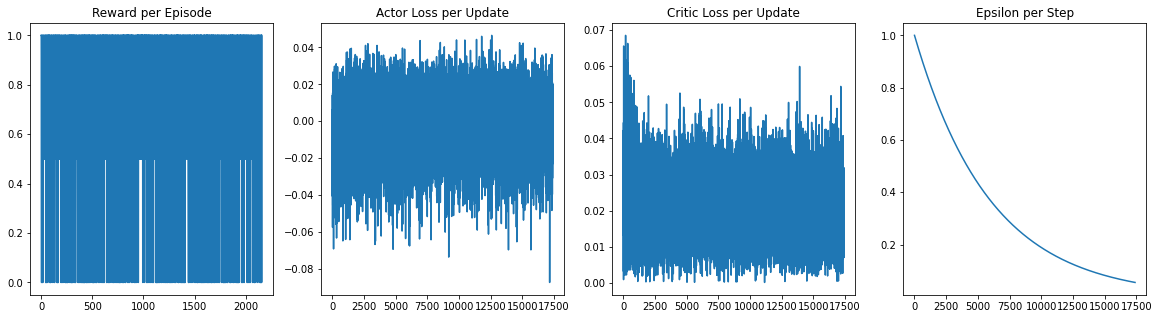

0
2
2
--Rx(0.386)----Rz(0.996)----Rx(3.010)----Rz(1.680)----Rx(5.426)----Rz(5.866)----Rx(0.366)----Rz(1.737)----S----Rx(3.010)----Rz(2.587)----S----S--
                                                                                                                                                 
--Ry(0.592)----Rz(3.271)----Ry(6.123)----Rz(3.297)--------S------------S------------S------------------------------------------------------------
                                                                                                                                                 
1
1
0
1
2
1
1
2
2
2
--Rx(2.117)----Rz(0.545)--------S------------S------------S------------S------------------------------------------------------------------------------
                                                                                                                                                      
--Ry(1.246)----Rz(1.425)----Ry(2.955)----Rz(5.927)----Ry(5.121)----Rz(5.848)----S----Ry(

1
0
1
0
2
1
1
0
[ 5.00000000e-01+5.00000000e-01j  3.25176795e-17-1.66533454e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(2.415)----Rz(3.253)----Rx(4.668)----Rz(3.285)----S----Rx(4.847)----Rz(6.213)----------------------------
                                                                                                             
--Ry(5.686)----Rz(0.785)----Ry(2.681)----Rz(1.464)----S----Ry(4.136)----Rz(5.639)----Ry(3.683)----Rz(0.691)--
                                                                                                             
1
2
0
2
2
1
[-5.00000000e-01-0.5j -7.85046229e-17+0.j   5.00000000e-01-0.5j]
------S--------Rx(1.408)----Rz(6.004)----S----S----------------------------
                                                                           
--Ry(3.045)----Rz(0.789)--------S--------S----S----Ry(2.059)----Rz(5.445)--
                                                                           
1
2
0
1
[-5.00000000e-01+0.5j -7.85046229e-17+0.j   5.00000000e-

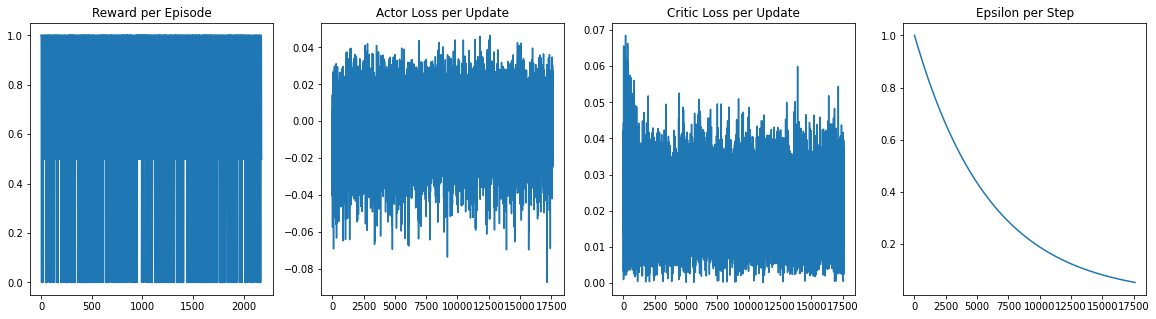

0
1
2
1
[ 5.00000000e-01-5.00000000e-01j -8.80288308e-17-5.55111512e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.029)----Rz(3.397)----Rx(5.019)----Rz(2.313)--------S--------------------------------------------------
                                                                                                             
--Ry(0.415)----Rz(6.154)----Ry(5.045)----Rz(3.544)----Ry(2.222)----Rz(1.940)----S----Ry(0.724)----Rz(0.668)--
                                                                                                             
0
1
1
0
2
2
1
0
2
2
--Rx(1.607)----Rz(3.435)----Rx(4.298)----Rz(3.266)----S----S----Rx(3.079)----Rz(5.096)----S----S--
                                                                                                  
--Ry(3.724)----Rz(4.906)----Ry(1.955)----Rz(1.802)----S----S----Ry(3.471)----Rz(1.157)----S----S--
                                                                                                  
0
1
0
2
1
1
1
0
2
0
--Rx(4.079)----Rz

0
1
0
1
0
--S----Rx(4.380)----Rz(2.055)----Rx(4.578)----Rz(5.397)----Rx(5.306)----Rz(5.132)----Rx(2.970)----Rz(4.313)----Rx(3.733)----Rz(2.829)----Rx(2.872)----Rz(3.829)--
                                                                                                                                                                 
--S----Ry(5.935)----Rz(1.939)----Ry(3.217)----Rz(3.158)----Ry(4.145)----Rz(3.606)--------------------------------------------------------------------------------
                                                                                                                                                                 
1
1
0
0
0
2
0
[5.00000000e-01+5.00000000e-01j 2.22044605e-16+1.89526925e-16j
 5.00000000e-01-5.00000000e-01j]
--Rx(0.088)----Rz(0.308)----Rx(6.131)----Rz(5.339)----Rx(3.940)----Rz(0.546)----S----Rx(4.564)----Rz(3.116)--
                                                                                                             
--Ry(5.876)-

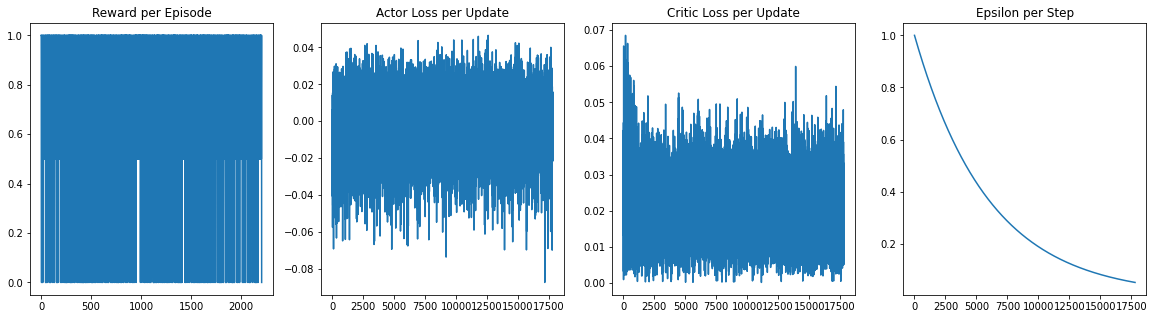

0
1
2
2
2
2
1
1
1
0
--Rx(1.926)----Rz(1.087)----S----S----S----S----Rx(1.246)----Rz(5.286)------------------------------------------------------
                                                                                                                            
--Ry(2.580)----Rz(5.989)----S----S----S----S----Ry(4.771)----Rz(3.690)----Ry(3.643)----Rz(1.703)----Ry(2.475)----Rz(6.166)--
                                                                                                                            
0
1
0
1
2
0
0
2
0
1
--Rx(4.719)----Rz(3.098)----Rx(2.663)----Rz(3.893)----S----Rx(5.473)----Rz(3.753)----Rx(4.957)----Rz(2.692)----S----Rx(2.738)----Rz(5.895)--
                                                                                                                                            
--Ry(1.445)----Rz(3.901)----Ry(2.824)----Rz(4.925)----S--------S--------Ry(3.261)----Rz(5.188)----------------------------------------------
                                     

2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(1.401)----Rz(5.149)----S----Rx(0.327)----Rz(3.562)--
                                                         
------S--------------------------------------------------
                                                         
1
2
2
1
1
0


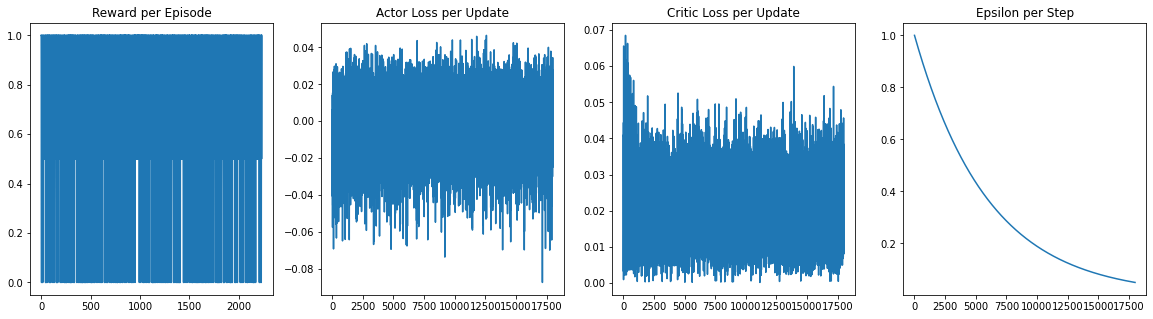

1
0
1
0
------S------------S--------Rx(0.135)----Rz(1.352)----Rx(5.296)----Rz(0.365)----Rx(0.789)----Rz(0.975)------------------------------------------------------
                                                                                                                                                            
--Ry(4.609)----Rz(4.678)--------S------------S--------Ry(1.557)----Rz(0.986)----Ry(5.481)----Rz(5.407)----Ry(2.684)----Rz(2.802)----Ry(5.488)----Rz(3.661)--
                                                                                                                                                            
2
0
1
1
0
0
1
0
2
1
--S----Rx(5.845)----Rz(3.038)----Rx(0.327)----Rz(1.407)----Rx(2.055)----Rz(1.637)----Rx(6.269)----Rz(1.025)--------S------
                                                                                                                          
--S----Ry(2.585)----Rz(0.484)----Ry(4.771)----Rz(1.146)----Ry(3.507)----Rz(0.485)--------S--------

1
1
0
0
2
0
0
0
0
--S----Rx(5.012)----Rz(2.249)----Rx(1.131)----Rz(2.645)----S----Rx(4.181)----Rz(2.232)----Rx(4.084)----Rz(0.589)----Rx(0.868)----Rz(0.308)----Rx(3.601)----Rz(1.117)--
                                                                                                                                                                      
--S----Ry(1.533)----Rz(0.375)----Ry(5.048)----Rz(5.489)----S----------------------------------------------------------------------------------------------------------
                                                                                                                                                                      
0
2
1
1
0
[0.5+5.00000000e-01j 0. +7.85046229e-17j 0.5-5.00000000e-01j]
--Rx(1.093)----Rz(6.034)--------S--------Rx(4.483)----Rz(4.237)--
                                                                 
------S--------Ry(6.022)----Rz(1.681)----Ry(1.229)----Rz(5.181)--
                                            

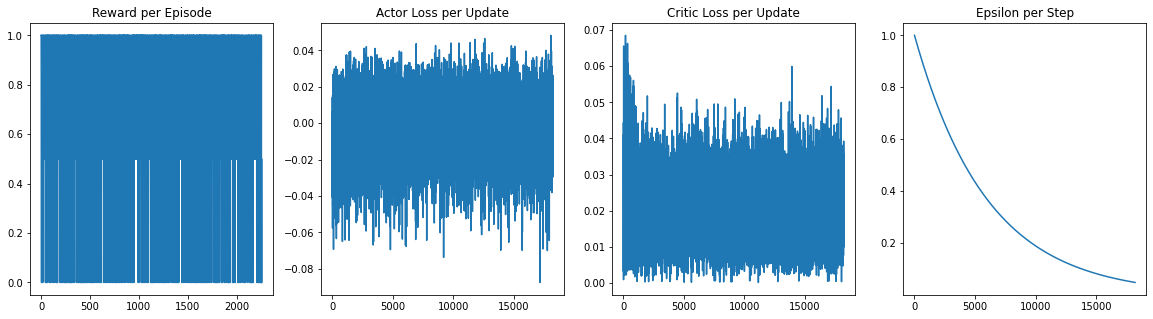

1
1
0
0
1
2
1
[0.5-5.00000000e-01j 0. -2.45038077e-16j 0.5+5.00000000e-01j]
--S----Rx(4.034)----Rz(0.346)----Rx(6.061)----Rz(3.691)--------S--------------------------------------------------
                                                                                                                  
--S----Ry(0.164)----Rz(5.263)----Ry(1.723)----Rz(5.993)----Ry(5.718)----Rz(0.510)----S----Ry(3.819)----Rz(2.810)--
                                                                                                                  
1
1
2
1
0
0
1
2
0
2
------S--------Rx(1.702)----Rz(3.099)----Rx(6.194)----Rz(2.232)--------S--------Rx(0.705)----Rz(4.052)--------S----------------
                                                                                                                               
--Ry(3.415)----Rz(1.980)----Ry(2.853)----Rz(0.664)--------S--------Ry(2.169)----Rz(4.464)----Ry(5.828)----Rz(2.683)----S----S--
                                                            

1
1
--S----S----S----Rx(2.192)----Rz(2.235)--------S------------------------------------------------------------------------------------------------------
                                                                                                                                                      
--S----S----S----Ry(1.285)----Rz(4.994)----Ry(3.273)----Rz(1.954)----Ry(5.540)----Rz(0.679)----S----Ry(1.695)----Rz(1.098)----Ry(1.829)----Rz(2.061)--
                                                                                                                                                      
1
0
0
1
1
0
1
1
1
0
--Rx(2.824)----Rz(3.969)----Rx(1.899)----Rz(0.676)----Rx(2.685)----Rz(0.171)----Rx(1.064)----Rz(3.359)------------------------------------------------------
                                                                                                                                                            
--Ry(1.273)----Rz(6.223)----Ry(0.022)----Rz(3.564)----Ry(4

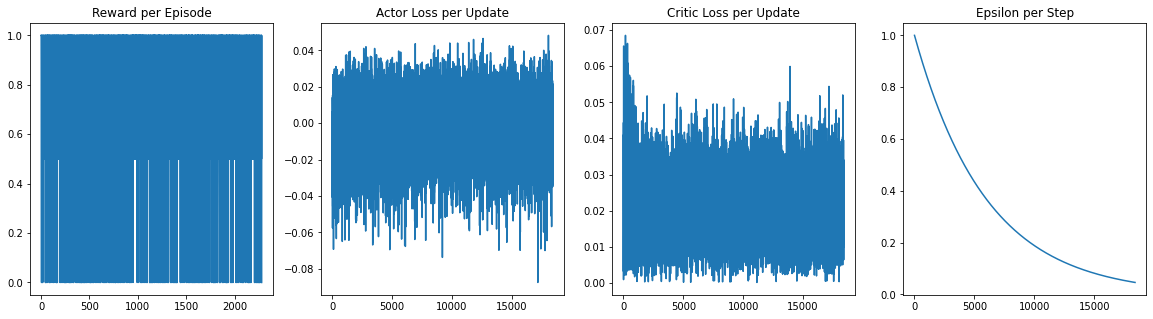

0
1
1
0
1
1
0
1
0
0
--Rx(0.254)----Rz(0.790)----Rx(1.906)----Rz(0.453)----Rx(5.694)----Rz(1.844)----Rx(2.284)----Rz(0.025)----Rx(5.533)----Rz(6.029)--
                                                                                                                                  
--Ry(6.256)----Rz(3.453)----Ry(0.750)----Rz(4.546)----Ry(6.098)----Rz(1.928)----Ry(5.359)----Rz(2.594)----Ry(0.403)----Rz(4.487)--
                                                                                                                                  
1
0
1
0
1
0
1
0
1
2
--Rx(4.315)----Rz(1.610)----Rx(3.631)----Rz(3.985)----Rx(1.442)----Rz(2.476)----Rx(2.890)----Rz(6.271)--------S------------------------
                                                                                                                                       
--Ry(5.490)----Rz(0.882)----Ry(5.185)----Rz(4.482)----Ry(4.601)----Rz(0.680)----Ry(5.334)----Rz(6.120)----Ry(4.863)----Rz(0.649)----S--
                            

--Rx(4.462)----Rz(2.901)----S----------------------------
                                                         
--Ry(1.473)----Rz(5.994)----S----Ry(1.073)----Rz(1.455)--
                                                         
0
0
1
2
1
[-5.00000000e-01+5.00000000e-01j  3.25176795e-17+1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(3.069)----Rz(3.294)----Rx(1.306)----Rz(0.336)--------S------
                                                                 
--Ry(0.275)----Rz(2.030)--------S--------Ry(6.199)----Rz(1.030)--
                                                                 
0
1
0
0
1
0
2
1
0
0
--Rx(1.855)----Rz(3.204)----Rx(1.228)----Rz(1.256)----Rx(5.252)----Rz(4.323)----Rx(3.046)----Rz(4.968)----S----Rx(6.109)----Rz(2.495)----Rx(1.731)----Rz(0.835)--
                                                                                                                                                                 
--Ry(2.349)----Rz(4.269)----Ry(0.945)----Rz(2.937)-

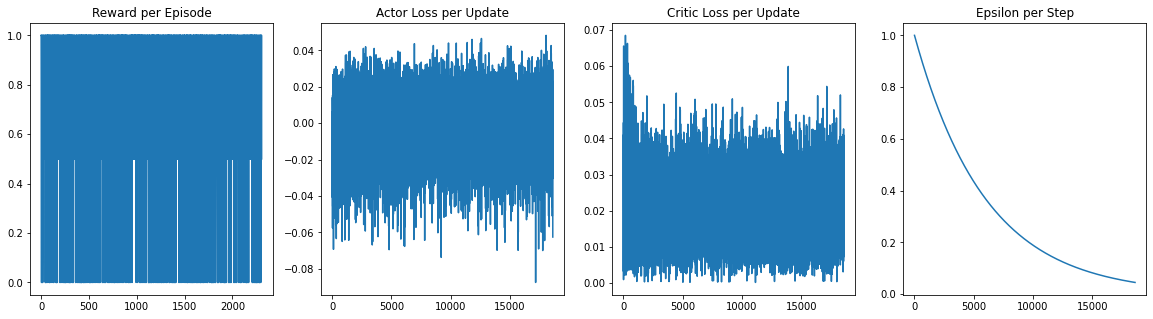

0
0
0
0
1
1
1
0
--S----Rx(1.065)----Rz(1.253)----Rx(6.225)----Rz(3.522)----Rx(0.109)----Rz(6.093)----Rx(5.003)----Rz(1.479)----Rx(5.108)----Rz(4.784)--
                                                                                                                                       
--S----Ry(4.184)----Rz(6.276)----Ry(3.156)----Rz(2.039)----Ry(2.328)----Rz(3.377)----Ry(6.196)----Rz(1.228)----------------------------
                                                                                                                                       
1
0
0
2
0
2
1
0
0
2
--Rx(1.606)----Rz(0.625)----Rx(2.810)----Rz(1.606)--------S--------Rx(3.164)----Rz(4.284)----S----Rx(2.727)----Rz(0.820)----Rx(3.248)----Rz(0.570)----S--
                                                                                                                                                         
--Ry(0.501)----Rz(2.337)--------S------------S--------Ry(5.146)----Rz(2.492)--------S---------------------------

2
1
0
0
0
2
1
[ 5.00000000e-01-5.00000000e-01j -1.11022302e-16-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--S----S----Rx(1.849)----Rz(4.208)----Rx(4.366)----Rz(2.231)----Rx(4.810)----Rz(6.182)----S--
                                                                                             
--S----S----Ry(3.991)----Rz(3.912)--------S--------Ry(3.295)----Rz(2.234)--------------------
                                                                                             
1
1
0
0
1
0
2
1
[-5.00000000e-01+5.00000000e-01j  3.88578059e-16+1.57009246e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(3.373)----Rz(4.756)----Rx(5.243)----Rz(1.820)----Rx(2.957)----Rz(3.096)----S----------------------------
                                                                                                             
--Ry(2.843)----Rz(3.563)----Ry(2.546)----Rz(0.025)----Ry(5.878)----Rz(0.988)----S----Ry(0.236)----Rz(5.545)--
                                                                  

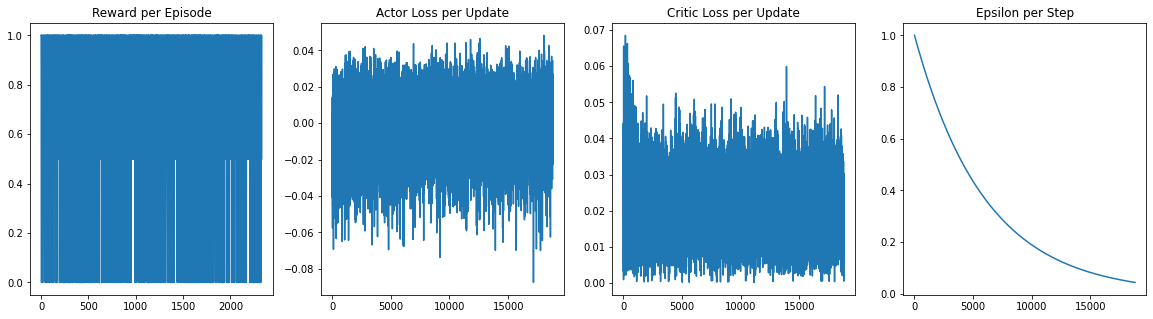

0
2
1
1
0
[ 5.00000000e-01-0.5j  7.85046229e-17+0.j  -5.00000000e-01-0.5j]
--S----Rx(0.790)----Rz(5.766)--------S--------Rx(1.781)----Rz(0.415)--
                                                                      
--S--------S--------Ry(2.454)----Rz(2.757)----Ry(5.073)----Rz(5.070)--
                                                                      
2
0
0
2
1
2
1
[ 5.00000000e-01-5.00000000e-01j  7.85046229e-17-1.66533454e-16j
 -5.00000000e-01-5.00000000e-01j]
--S----Rx(6.099)----Rz(4.718)----Rx(1.434)----Rz(1.228)--------S------------S------
                                                                                   
--S--------S--------Ry(3.946)----Rz(4.440)--------S--------Ry(3.975)----Rz(4.383)--
                                                                                   
0
0
2
1
2
1
[5.00000000e-01+5.00000000e-01j 1.66533454e-16+7.85046229e-17j
 5.00000000e-01-5.00000000e-01j]
--Rx(3.000)----Rz(4.286)----Rx(3.382)----Rz(0.124)--------S------------S------
     

1
0
1
2
1
1
1
1
0
0
--Rx(6.273)----Rz(5.724)--------S--------Rx(3.001)----Rz(3.002)----Rx(3.890)----Rz(1.675)--------------------------------------------------------------------------------
                                                                                                                                                                         
--Ry(4.151)----Rz(3.063)----Ry(2.298)----Rz(5.014)--------S--------Ry(2.347)----Rz(4.371)----Ry(0.247)----Rz(2.172)----Ry(4.882)----Rz(4.515)----Ry(6.095)----Rz(3.513)--
                                                                                                                                                                         
1
1
1
0
1
2
0
1
2
1
--Rx(4.610)----Rz(2.186)--------S--------Rx(2.670)----Rz(4.560)--------S----------------------------------------------------------------------------------------------
                                                                                                                 

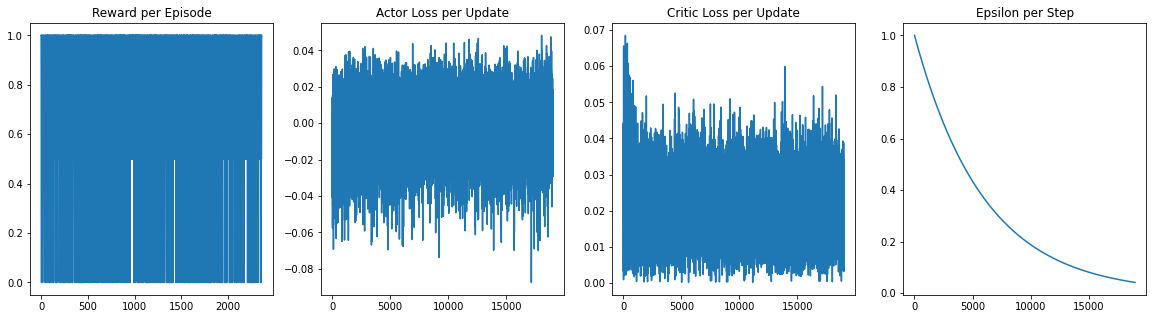

1
0
1
1
0
0
1
2
1
2
--Rx(5.429)----Rz(4.269)----Rx(2.626)----Rz(1.983)----Rx(3.344)----Rz(1.711)--------S------------S------------------------------------------
                                                                                                                                            
--Ry(5.100)----Rz(6.055)----Ry(0.869)----Rz(2.635)----Ry(2.282)----Rz(5.681)----Ry(5.808)----Rz(4.184)----S----Ry(5.716)----Rz(5.450)----S--
                                                                                                                                            
0
0
0
0
2
2
2
1
1
1
--Rx(2.479)----Rz(0.133)----Rx(0.503)----Rz(6.140)----Rx(4.808)----Rz(1.702)----Rx(6.218)----Rz(1.762)--------S--------S----S--
                                                                                                                               
------S------------S------------S--------Ry(1.519)----Rz(0.412)----Ry(3.345)----Rz(0.780)----Ry(4.499)----Rz(4.448)------------
            

------S------------S--------Rx(0.220)----Rz(5.432)----Rx(5.873)----Rz(3.804)----S--------------------------------------------------------------------------------
                                                                                                                                                                 
--Ry(5.140)----Rz(1.164)----Ry(3.656)----Rz(0.073)--------S------------S--------S----Ry(3.635)----Rz(3.177)----Ry(0.846)----Rz(2.238)----Ry(2.354)----Rz(4.003)--
                                                                                                                                                                 
0
0
0
0
1
2
1
[-5.00000000e-01-5.00000000e-01j -3.00549228e-16+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--Rx(0.608)----Rz(4.279)----Rx(1.531)----Rz(4.997)----Rx(1.016)----Rz(6.161)----Rx(0.441)----Rz(2.317)----S--
                                                                                                             
--Ry(0.754)----Rz(1

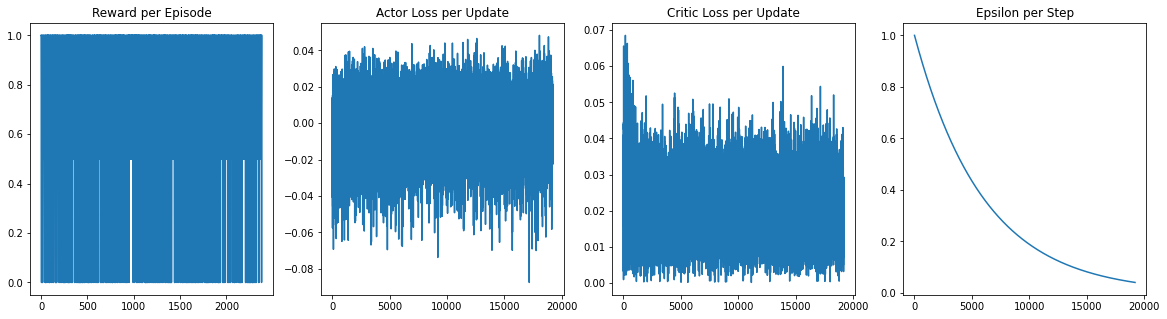

1
1
0
--Rx(4.335)----Rz(6.186)--------S------------S--------Rx(0.963)----Rz(4.510)----Rx(2.672)----Rz(4.987)------------------------------------------------------
                                                                                                                                                            
------S--------Ry(3.161)----Rz(0.114)----Ry(2.112)----Rz(3.403)--------S--------Ry(0.097)----Rz(2.702)----Ry(4.055)----Rz(3.823)----Ry(0.972)----Rz(2.619)--
                                                                                                                                                            
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.995)----Rz(4.246)----S----Rx(5.591)----Rz(1.261)--
                                                         
------S--------------------------------------------------
                                                         
2
1
2
0
2
2
2
2
2
2
--S------

0
1
1
2
2
1
2
--Rx(3.492)----Rz(4.083)----Rx(6.239)----Rz(4.767)--------S------------S------------S------------------------------------------------------------
                                                                                                                                                 
--Ry(3.549)----Rz(4.609)----Ry(2.580)----Rz(1.708)----Ry(0.034)----Rz(2.527)----Ry(5.370)----Rz(2.912)----S----S----Ry(3.414)----Rz(3.942)----S--
                                                                                                                                                 
0
0
1
1
0
2
1
0
[-0.5+5.00000000e-01j  0. -2.45038077e-16j -0.5-5.00000000e-01j]
--Rx(2.822)----Rz(3.169)----Rx(0.128)----Rz(3.607)----Rx(4.115)----Rz(0.726)--------S--------Rx(5.974)----Rz(6.241)--
                                                                                                                     
--Ry(0.874)----Rz(0.403)----Ry(1.124)----Rz(1.633)--------S--------Ry(4.721)----Rz(1.

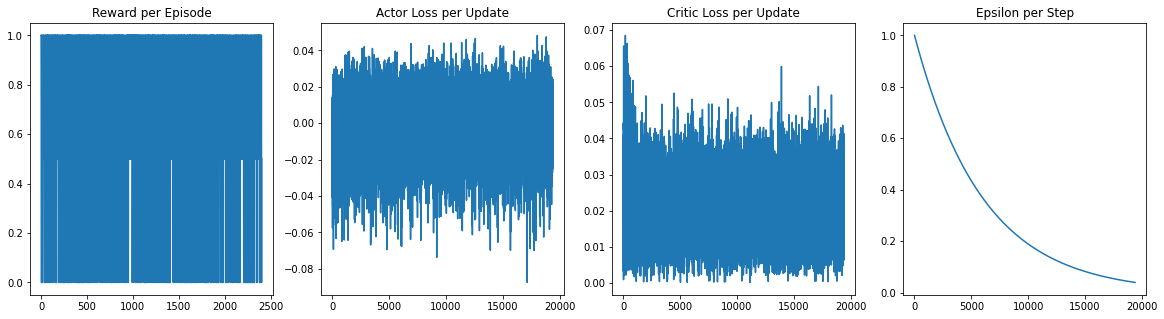

0
0
--S----S----Rx(2.525)----Rz(6.211)----Rx(5.773)----Rz(3.891)----Rx(4.580)----Rz(3.763)----Rx(0.199)----Rz(1.701)--
                                                                                                                  
--S----S----Ry(3.640)----Rz(4.649)----Ry(4.176)----Rz(0.192)----Ry(4.555)----Rz(5.759)----Ry(2.696)----Rz(1.731)--
                                                                                                                  
0
0
2
1
0
1
0
1
2
1
--Rx(3.176)----Rz(4.098)----Rx(3.799)----Rz(2.373)--------S--------Rx(0.181)----Rz(2.561)----Rx(2.218)----Rz(0.683)--------S------
                                                                                                                                  
------S--------Ry(4.508)----Rz(3.614)----Ry(4.311)----Rz(0.006)----Ry(6.048)----Rz(3.333)--------S--------Ry(5.816)----Rz(6.101)--
                                                                                                                           

2
2
1
1
1
--Rx(6.109)----Rz(3.695)----Rx(2.682)----Rz(3.618)--------S--------Rx(5.997)----Rz(0.626)--------S------------S------------S------
                                                                                                                                  
------S------------S------------S------------S--------Ry(1.740)----Rz(4.588)----Ry(5.016)----Rz(0.848)----Ry(1.130)----Rz(1.618)--
                                                                                                                                  
0
0
1
2
2
2
0
2
1
1
--Rx(5.622)----Rz(0.745)----Rx(5.169)----Rz(4.393)----S----S--------S--------Rx(5.481)----Rz(5.707)--------S------
                                                                                                                  
--Ry(4.292)----Rz(2.368)--------S------------S--------S----S----Ry(5.150)----Rz(4.266)----Ry(0.547)----Rz(5.335)--
                                                                                                     

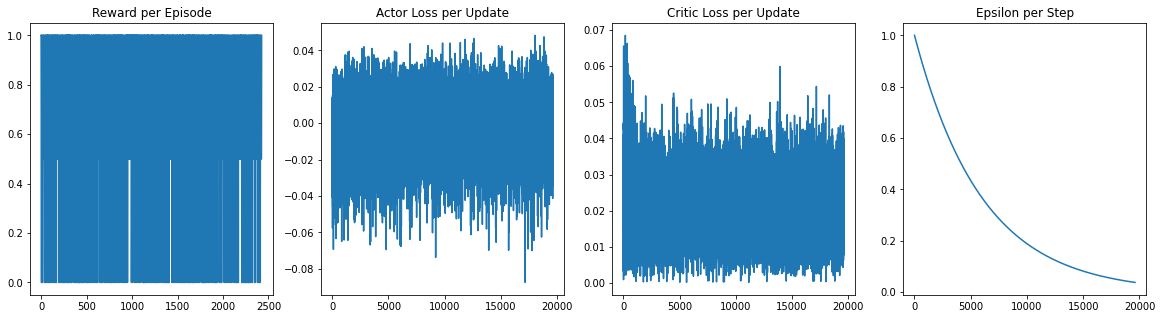

0
0
2
0
[ 5.00000000e-01+5.00000000e-01j -1.57009246e-16+1.66533454e-16j
 -5.00000000e-01+5.00000000e-01j]
--Rx(5.968)----Rz(3.750)--------S--------S----Rx(5.793)----Rz(5.580)----Rx(6.047)----Rz(5.589)----S----Rx(0.911)----Rz(3.385)--
                                                                                                                               
------S--------Ry(0.554)----Rz(3.711)----S----Ry(5.141)----Rz(6.016)--------S--------------------------------------------------
                                                                                                                               
0
2
0
[-5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(0.863)----Rz(0.858)----S----Rx(0.916)----Rz(5.385)--
                                                         
------S--------------------------------------------------
                                                         
2
1
0
2
1
[-5.00000000e-01-5.00000000e-01j -

0
1
2
1
0
[ 5.00000000e-01+5.00000000e-01j -7.85046229e-17-1.66533454e-16j
 -5.00000000e-01+5.00000000e-01j]
--S----S----Rx(5.395)----Rz(6.076)----S----Rx(0.595)----Rz(1.762)--
                                                                   
--S----S----Ry(0.689)----Rz(2.543)----S----Ry(3.740)----Rz(4.129)--
                                                                   
0
1
1
2
0
[5.00000000e-01+5.00000000e-01j 1.11022302e-16+7.85046229e-17j
 5.00000000e-01-5.00000000e-01j]
--Rx(6.160)----Rz(5.350)--------S--------Rx(1.396)----Rz(1.270)--
                                                                 
--Ry(6.203)----Rz(3.682)----Ry(5.840)----Rz(0.006)--------S------
                                                                 
1
2
0
1
[-5.00000000e-01+0.5j -7.85046229e-17+0.j   5.00000000e-01+0.5j]
------S--------Rx(4.322)----Rz(0.797)----------------------------
                                                                 
--Ry(1.589)----Rz(1.734)--------S--------Ry(

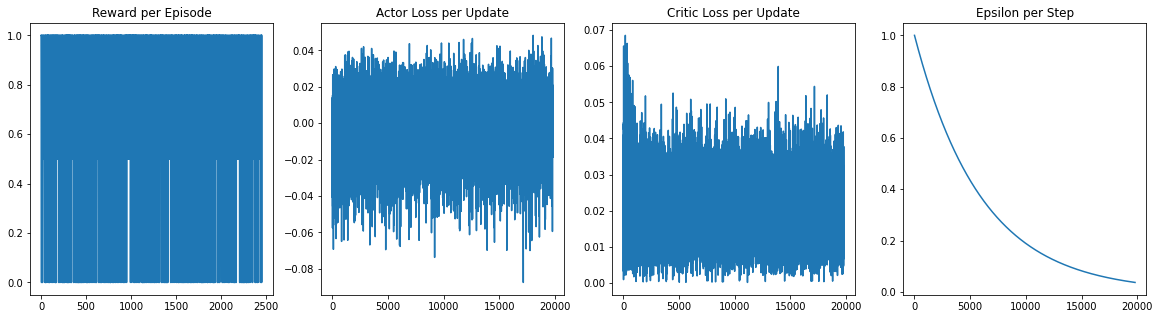

0
0
1
1
1
1
1
--S----Rx(3.923)----Rz(6.252)----Rx(6.210)----Rz(4.487)----Rx(4.351)----Rz(3.626)----Rx(1.559)----Rz(4.710)----------------------------
                                                                                                                                       
--S----Ry(5.328)----Rz(2.407)----Ry(1.229)----Rz(5.905)----Ry(6.019)----Rz(4.778)----Ry(1.135)----Rz(3.276)----Ry(2.146)----Rz(3.020)--
                                                                                                                                       
0
0
1
2
1
[-5.00000000e-01+5.00000000e-01j  3.25176795e-17+1.11022302e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(2.989)----Rz(0.876)----Rx(4.331)----Rz(0.372)--------S------
                                                                 
--Ry(6.120)----Rz(5.220)--------S--------Ry(4.860)----Rz(4.920)--
                                                                 
2
0
0
0
1
2
1
0
[5.00000000e-01+5.00000000e-01j 1.11022302e-16-1.9626

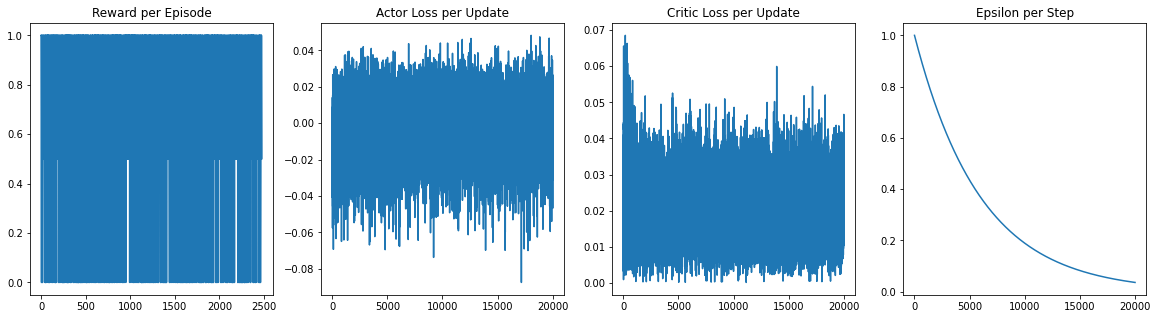

1
2
2
2
--Rx(0.423)----Rz(5.728)--------S------------S------------S----------------------------------------------------------------------------------------------------------------
                                                                                                                                                                           
--Ry(5.698)----Rz(6.019)----Ry(4.478)----Rz(2.721)----Ry(0.757)----Rz(0.934)----Ry(2.623)----Rz(3.842)----Ry(3.409)----Rz(1.146)----Ry(2.777)----Rz(5.932)----S----S----S--
                                                                                                                                                                           
1
0
1
0
2
1
2
0
1
1
--Rx(3.271)----Rz(0.377)----Rx(1.278)----Rz(2.604)----S--------S--------Rx(6.095)----Rz(3.515)------------------------------------------------------
                                                                                                                                       

0
1
1
1
0
1
1
0
1
1
--Rx(5.286)----Rz(2.035)----Rx(6.123)----Rz(0.966)----Rx(4.591)----Rz(6.020)----------------------------------------------------------------------------------------------------------
                                                                                                                                                                                      
--Ry(2.520)----Rz(6.264)----Ry(3.156)----Rz(0.370)----Ry(6.144)----Rz(2.064)----Ry(2.231)----Rz(0.667)----Ry(0.090)----Rz(2.966)----Ry(4.355)----Rz(2.322)----Ry(2.209)----Rz(2.612)--
                                                                                                                                                                                      
0
2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.331)----Rz(0.252)--------S--------Rx(2.040)----Rz(5.374)--
                                                                 
------S--

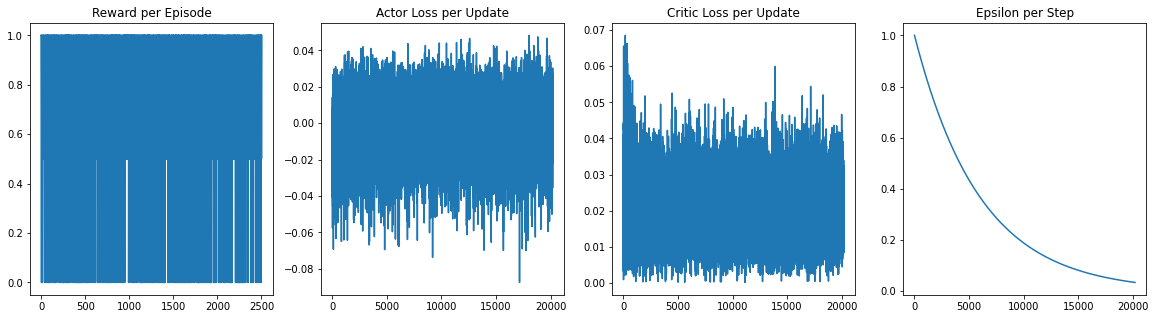

2
0
1
2
1
0
------S--------Rx(5.507)----Rz(4.876)----Rx(6.282)----Rz(5.466)--------S--------Rx(3.713)----Rz(1.414)--------S--------Rx(6.240)----Rz(1.419)--
                                                                                                                                               
--Ry(3.056)----Rz(1.316)--------S------------S--------Ry(1.892)----Rz(2.614)--------S--------Ry(1.371)----Rz(5.879)----------------------------
                                                                                                                                               
2
1
1
1
2
2
0
0
1
0
--S--------S------------S--------Rx(3.839)----Rz(2.885)----Rx(2.353)----Rz(5.349)----Rx(0.711)----Rz(2.862)----------------------------
                                                                                                                                       
--S----Ry(4.943)----Rz(1.673)----Ry(0.861)----Rz(3.884)----Ry(3.627)----Rz(2.959)--------S------------S--------Ry(4.574)

0
2
0
2
0
2
--Rx(5.306)----Rz(5.882)----S----Rx(2.196)----Rz(1.384)----Rx(1.611)----Rz(2.230)----S----Rx(0.076)----Rz(2.728)----S----Rx(4.577)----Rz(5.149)----S--
                                                                                                                                                      
--Ry(0.471)----Rz(5.621)----S--------S------------S------------S--------------------------------------------------------------------------------------
                                                                                                                                                      
0
2
1
2
0
0
1
0
0
1
--Rx(5.139)----Rz(4.958)--------S--------S----Rx(3.880)----Rz(1.672)----Rx(3.047)----Rz(3.221)----Rx(5.396)----Rz(1.998)----Rx(4.915)----Rz(1.100)--
                                                                                                                                                    
------S--------Ry(0.566)----Rz(2.858)----S----Ry(3.961)----Rz(3.20

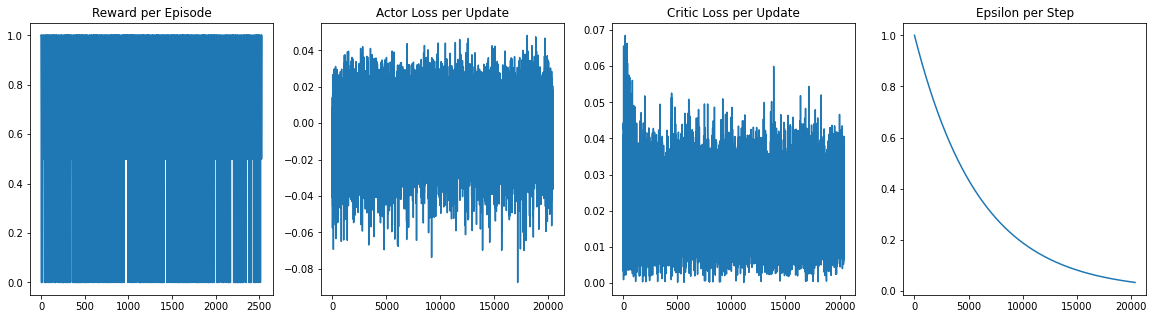

1
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(5.927)----Rz(4.427)----S----Ry(2.866)----Rz(4.551)--
                                                         
2
1
1
2
0
2
0
[0.5-5.00000000e-01j 0. +7.85046229e-17j 0.5+5.00000000e-01j]
--S--------S--------Rx(4.281)----Rz(1.401)--------S--------Rx(0.087)----Rz(0.550)--
                                                                                   
--S----Ry(4.621)----Rz(2.478)----Ry(5.142)----Rz(0.435)--------S------------S------
                                                                                   
1
1
2
0
1
2
1
0
[-0.5-5.00000000e-01j  0. +6.16297582e-33j -0.5+5.00000000e-01j]
------S--------Rx(6.036)----Rz(4.415)--------S--------Rx(4.986)----Rz(4.939)----------------------------------------------
                                               

1
2
--Rx(1.097)----Rz(6.001)----Rx(1.678)----Rz(1.725)----S--------S--------Rx(3.493)----Rz(1.376)--------S------------------------
                                                                                                                               
--Ry(5.636)----Rz(4.327)----Ry(3.072)----Rz(5.179)----S----Ry(1.312)----Rz(4.791)--------S--------Ry(4.341)----Rz(5.995)----S--
                                                                                                                               
1
0
2
0
1
[-5.00000000e-01-5.00000000e-01j  5.55111512e-17-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--Rx(0.105)----Rz(3.074)----S----Rx(5.268)----Rz(1.504)--
                                                         
--Ry(5.166)----Rz(6.167)----S----Ry(0.693)----Rz(5.377)--
                                                         
2
1
1
0
0
2
2
2
1
1
--S----Rx(5.322)----Rz(1.326)----Rx(2.214)----Rz(1.408)----S----S----S-----------------------------------------------------

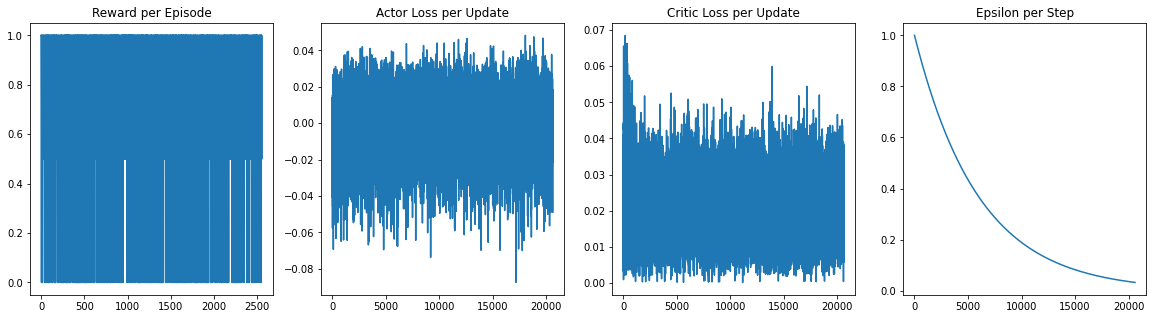

2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
------S--------------------------------------------------
                                                         
--Ry(4.459)----Rz(0.904)----S----Ry(3.432)----Rz(5.002)--
                                                         
0
1
2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.187)----Rz(3.582)----S----Rx(0.498)----Rz(2.824)--
                                                         
--Ry(0.124)----Rz(3.827)----S----------------------------
                                                         
2
0
2
2
0
2
0
2
0
[-5.00000000e-01-5.00000000e-01j -1.11022302e-16-7.85046229e-17j
 -5.00000000e-01+5.00000000e-01j]
--S----Rx(4.646)----Rz(4.386)----S----S----Rx(0.789)----Rz(1.559)----S----Rx(4.987)----Rz(3.429)----S----Rx(0.736)----Rz(5.663)--
                                                                               

2
1
1
0
2
2
0
1
1
--S----S----Rx(1.561)----Rz(3.381)--------S------------S--------Rx(3.763)----Rz(2.403)------------------------------------------------------
                                                                                                                                            
--S----S----Ry(0.307)----Rz(0.180)----Ry(5.021)----Rz(1.636)--------S------------S--------Ry(4.318)----Rz(0.378)----Ry(1.346)----Rz(3.767)--
                                                                                                                                            
1
1
2
0
0
1
0
1
1
0
------S--------Rx(5.509)----Rz(1.010)----Rx(2.001)----Rz(0.770)----Rx(3.395)----Rz(0.752)----Rx(3.546)----Rz(3.726)----------------------------
                                                                                                                                               
--Ry(4.157)----Rz(4.629)----Ry(2.419)----Rz(0.811)--------S--------Ry(1.134)----Rz(3.243)----Ry(3.208)----Rz(3

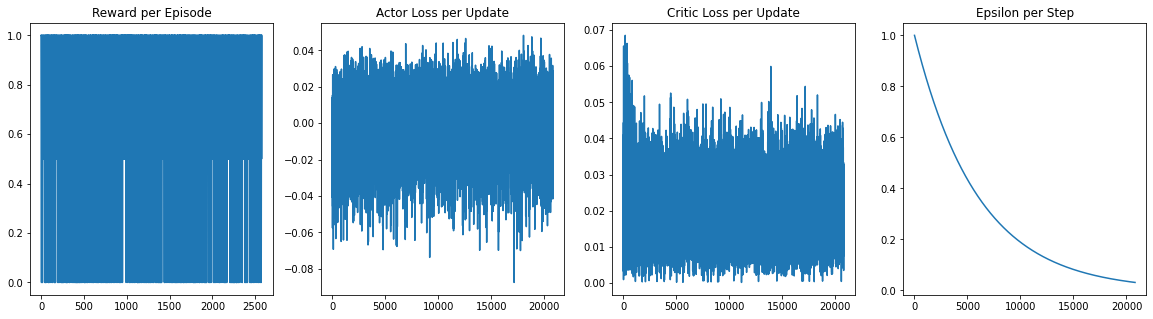

0
0
1
1
--Rx(1.561)----Rz(5.438)----Rx(4.771)----Rz(4.156)----Rx(2.700)----Rz(1.502)----Rx(3.690)----Rz(0.584)----Rx(5.710)----Rz(4.915)----Rx(2.117)----Rz(4.484)----Rx(4.807)----Rz(3.117)----Rx(3.114)----Rz(5.147)--
                                                                                                                                                                                                                
--Ry(0.362)----Rz(0.735)----Ry(3.603)----Rz(1.019)--------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                
1
0
0
0
1
0
2
1
0
[-5.00000000e-01+5.00000000e-01j -1.89526925e-16+3.33066907e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.389)----Rz(1.517)----Rx(0.253)--

2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.187)----Rz(4.205)--------S--------Rx(2.636)----Rz(5.654)--
                                                                 
------S--------Ry(5.036)----Rz(5.581)----------------------------
                                                                 
0
1
1
2
1
0
[-5.00000000e-01+5.00000000e-01j  1.66533454e-16-7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(5.241)----Rz(5.249)--------S--------Rx(2.903)----Rz(2.121)----------------------------
                                                                                           
--Ry(2.872)----Rz(1.626)----Ry(4.692)----Rz(5.688)--------S--------Ry(6.048)----Rz(3.135)--
                                                                                           
1
1
2
1
1
0
0
0
2
2
------S--------Rx(3.403)----Rz(2.372)----Rx(3.416)----Rz(2.149)----Rx(4.895)----Rz(4.813)--------S------------S----------------
    

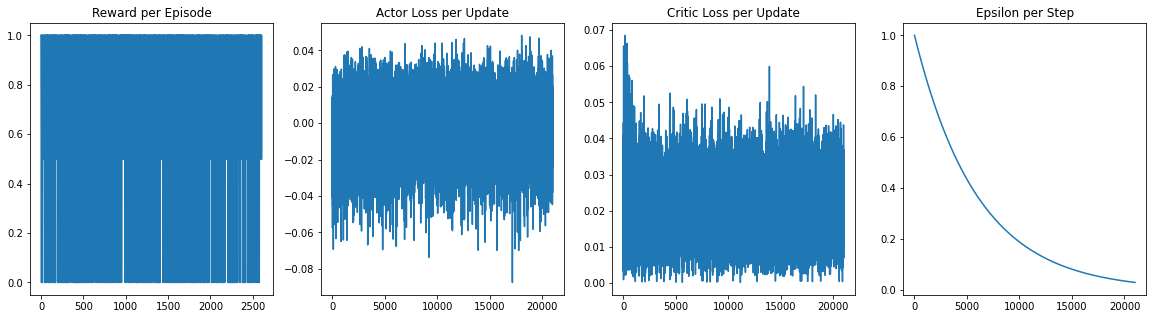

0
0
0
1
1
0
2
1
[-5.00000000e-01+5.00000000e-01j -3.33644647e-16+1.66533454e-16j
  5.00000000e-01+5.00000000e-01j]
--Rx(0.076)----Rz(0.994)----Rx(6.089)----Rz(0.535)----Rx(1.013)----Rz(2.470)----Rx(2.441)----Rz(4.681)--------S------
                                                                                                                     
--Ry(3.239)----Rz(0.229)----Ry(5.245)----Rz(2.818)----Ry(3.867)----Rz(5.564)--------S--------Ry(5.486)----Rz(4.703)--
                                                                                                                     
2
0
1
0
1
2
0
1
[-5.00000000e-01-5.00000000e-01j -1.89526925e-16-1.66533454e-16j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(2.884)----Rz(2.033)----Rx(4.760)----Rz(3.865)----S----Rx(4.413)----Rz(3.260)--
                                                                                        
--S----Ry(2.515)----Rz(1.730)----Ry(2.721)----Rz(0.246)----S----Ry(2.690)----Rz(5.951)--
                               

2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(1.850)----Rz(1.809)--------S--------Rx(4.891)----Rz(3.841)--
                                                                 
------S--------Ry(6.268)----Rz(2.144)----------------------------
                                                                 
0
0
0
2
1
2
1
0
2
2
--Rx(1.780)----Rz(2.657)----Rx(5.992)----Rz(4.404)----Rx(3.447)----Rz(5.818)----S----S----Rx(2.799)----Rz(1.237)----S----S--
                                                                                                                            
------S--------Ry(3.937)----Rz(5.418)--------S--------Ry(0.134)----Rz(0.572)----S----S--------------------------------------
                                                                                                                            
0
0
0
0
2
2
1
1
1
1
--Rx(1.159)----Rz(3.857)----Rx(6.159)----Rz(5.834)----Rx(3.334)----Rz(5.491)----Rx(0.901)--

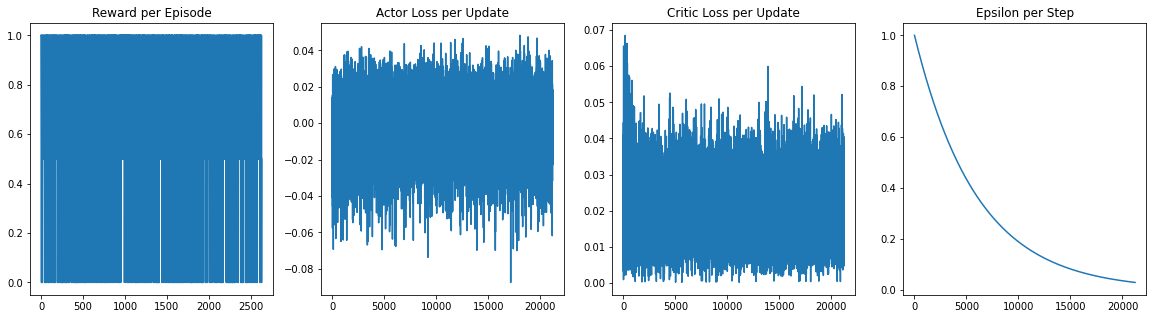

1
2
1
0
1
2
1
--Rx(1.304)----Rz(5.965)----Rx(4.278)----Rz(0.221)----S----Rx(2.229)----Rz(2.360)--------S--------------------------------------------------
                                                                                                                                            
--Ry(3.452)----Rz(5.759)----Ry(0.252)----Rz(2.742)----S----Ry(3.309)----Rz(5.342)----Ry(6.240)----Rz(2.655)----S----Ry(5.211)----Rz(3.911)--
                                                                                                                                            
1
2
2
0
0
2
0
1
[-5.0000000e-01-5.00000000e-01j -1.3738309e-16+1.66533454e-16j
  5.0000000e-01-5.00000000e-01j]
------S------------S--------Rx(4.599)----Rz(5.968)----Rx(3.111)----Rz(2.085)--------S--------Rx(4.932)----Rz(1.078)--
                                                                                                                     
--Ry(5.860)----Rz(1.547)--------S------------S------------S--------Ry(4.37

2
1
0
1
2
0
2
0
[0.5-5.00000000e-01j 0. +7.85046229e-17j 0.5+5.00000000e-01j]
--S----S----Rx(3.508)----Rz(0.758)--------S--------Rx(2.462)----Rz(1.833)----S----Rx(6.101)----Rz(1.194)--
                                                                                                          
--S----S----Ry(5.607)----Rz(0.041)----Ry(3.488)----Rz(0.820)--------S--------S----------------------------
                                                                                                          
1
0
0
2
2
0
2
2
1
1
--Rx(2.699)----Rz(2.569)----Rx(2.805)----Rz(4.923)----S----S----Rx(2.508)----Rz(6.132)--------S------------S------
                                                                                                                  
--Ry(0.241)----Rz(0.133)--------S------------S--------S----S----Ry(0.619)----Rz(5.746)----Ry(6.278)----Rz(4.888)--
                                                                                                                  
2
0
0
0
0
0
0


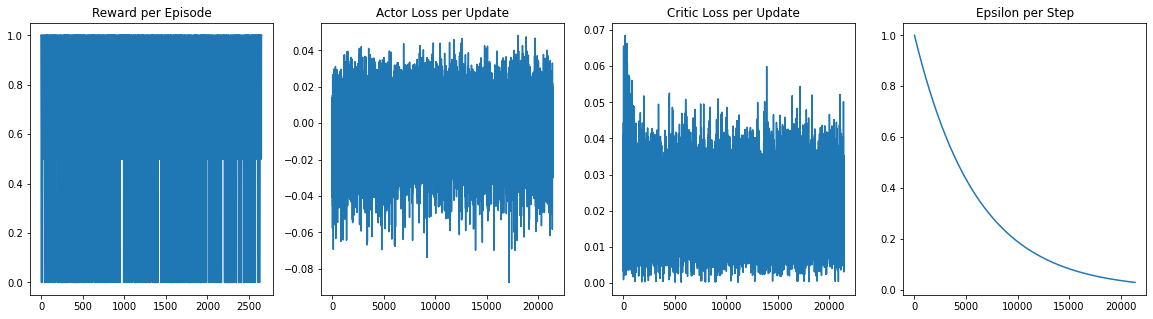

1
2
0
[-5.00000000e-01+5.00000000e-01j -1.96261557e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(5.850)----Rz(2.150)--------S--------Rx(5.213)----Rz(0.099)------------------------------------------------------------------------
                                                                                                                                       
--Ry(3.915)----Rz(3.674)----Ry(2.180)----Rz(2.781)----Ry(6.060)----Rz(5.120)----Ry(0.232)----Rz(0.199)----Ry(2.704)----Rz(1.676)----S--
                                                                                                                                       
1
1
1
2
0
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17-2.77555756e-16j
  5.00000000e-01-5.00000000e-01j]
------S--------Rx(4.752)----Rz(2.841)------------------------------------------------------------------------
                                                                                                             
--Ry(3.500)----Rz(0.

0
0
--Rx(2.111)----Rz(4.663)----Rx(4.022)----Rz(5.203)----S----Rx(5.213)----Rz(4.511)----S----S----Rx(5.702)----Rz(5.838)----Rx(3.526)----Rz(5.686)--
                                                                                                                                                 
--Ry(6.266)----Rz(3.988)----Ry(4.060)----Rz(4.688)----S--------S------------S--------------------------------------------------------------------
                                                                                                                                                 
2
1
1
0
0
0
2
2
0
2
--S----Rx(4.117)----Rz(3.187)----Rx(1.727)----Rz(6.016)----Rx(0.529)----Rz(2.300)----S----S----Rx(3.641)----Rz(3.758)----S--
                                                                                                                            
--S----Ry(0.313)----Rz(3.445)----Ry(2.751)----Rz(1.730)--------S------------S--------S--------------------------------------
                 

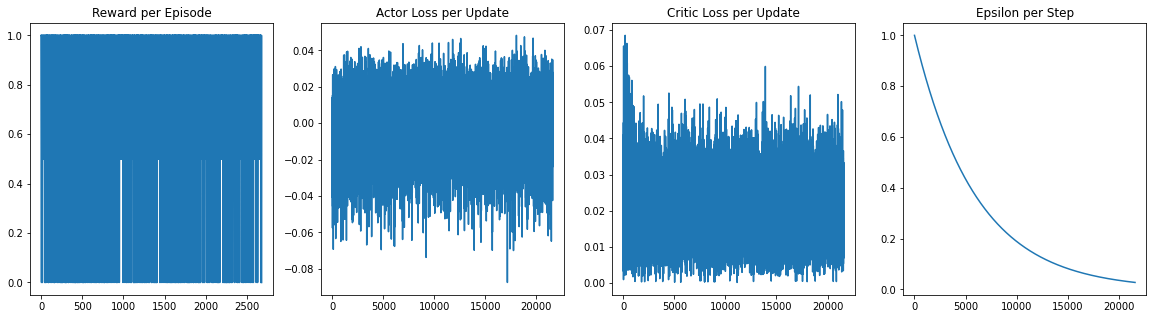

1
0
2
0
0
1
[-5.00000000e-01+5.00000000e-01j -1.11022302e-16+7.85046229e-17j
 -5.00000000e-01-5.00000000e-01j]
--Rx(1.103)----Rz(0.702)----S----Rx(0.241)----Rz(5.299)----Rx(2.819)----Rz(3.004)--
                                                                                   
--Ry(0.440)----Rz(0.229)----S----Ry(5.660)----Rz(0.003)----------------------------
                                                                                   
0
2
1
2
1
1
1
2
1
1
--Rx(0.946)----Rz(4.740)--------S--------S--------S--------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                   
------S--------Ry(4.535)----Rz(4.885)----S----Ry(2.704)----Rz(1.465)----Ry(0.206)----Rz(6.035)----Ry(4.781)----Rz(3.255)----S----Ry(2.084)----Rz(3.530)----Ry(5.343)----Rz(0.

1
[ 5.00000000e-01-5.00000000e-01j -5.55111512e-17-7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(5.558)----Rz(2.254)----S----------------------------
                                                         
--Ry(1.545)----Rz(0.890)----S----Ry(3.244)----Rz(5.332)--
                                                         
1
1
1
1
0
1
2
2
2
2
--Rx(2.633)----Rz(1.933)--------S------------S------------S------------S------------------------------------------------------------------------------
                                                                                                                                                      
--Ry(4.927)----Rz(1.816)----Ry(0.820)----Rz(1.861)----Ry(3.418)----Rz(1.277)----Ry(3.955)----Rz(0.154)----Ry(4.846)----Rz(5.458)----S----S----S----S--
                                                                                                                                                      
2
1
1
2
2
0
2
2
2
0
[ 5.00000000e-01-5.0000

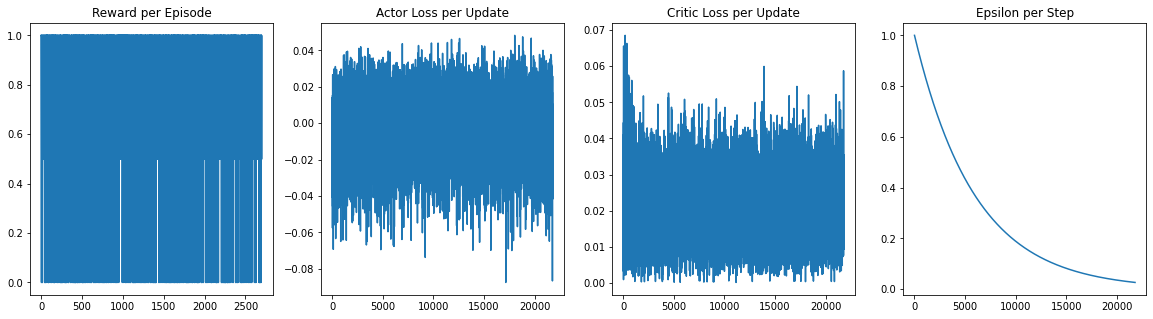

1
--Rx(0.918)----Rz(3.402)--------S--------Rx(1.898)----Rz(5.537)----Rx(5.629)----Rz(2.662)--------S--------Rx(1.370)----Rz(3.649)--
                                                                                                                                  
--Ry(1.796)----Rz(3.574)----Ry(2.781)----Rz(2.364)--------S------------S--------Ry(1.313)----Rz(6.065)----Ry(0.644)----Rz(0.657)--
                                                                                                                                  
0
2
2
0
0
0
1
1
1
1
--Rx(5.141)----Rz(5.041)--------S------------S--------Rx(0.648)----Rz(4.562)----Rx(4.390)----Rz(0.641)----Rx(1.955)----Rz(2.387)--
                                                                                                                                  
------S------------S--------Ry(3.242)----Rz(5.951)----Ry(5.028)----Rz(3.015)----Ry(6.099)----Rz(0.772)----Ry(2.727)----Rz(5.104)--
                                                             

1
1
1
1
2
2
1
1
------S------------S------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                                                          
--Ry(1.217)----Rz(5.742)----Ry(2.117)----Rz(0.158)----Ry(2.940)----Rz(1.192)----Ry(1.318)----Rz(2.712)----Ry(3.636)----Rz(4.332)----Ry(1.444)----Rz(3.124)----S----S----Ry(1.047)----Rz(4.974)----Ry(5.120)----Rz(0.717)--
                                                                                                                                                                                                                          
2
0
1
1
1
0
0
0
0
2
--S----Rx(3.288)----Rz(0.038)----Rx(0.655)----Rz(5.206)----Rx(3.839)----Rz(4.755)----Rx(

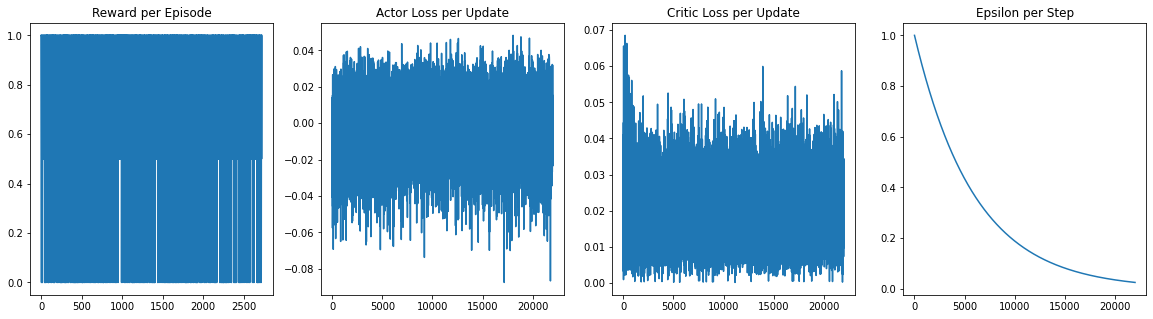

1
[ 5.00000000e-01+5.00000000e-01j  1.89526925e-16-5.55111512e-17j
 -5.00000000e-01+5.00000000e-01j]
------S------------S------------S------------------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                           
--Ry(2.485)----Rz(0.362)----Ry(5.572)----Rz(4.459)----S----Ry(5.293)----Rz(3.466)----Ry(2.946)----Rz(6.214)----S----Ry(3.329)----Rz(3.384)----S----Ry(3.604)----Rz(5.042)--
                                                                                                                                                                           
2
1
0
1
2
2
0
2
1
1
--S----Rx(4.502)----Rz(0.874)--------S------------S--------Rx(4.401)----Rz(0.078)----S------------------------------------------------------
                                                  

1
0
1
1
0
0
0
0
--Rx(5.955)----Rz(4.530)----Rx(0.857)----Rz(2.070)----Rx(3.769)----Rz(0.812)----Rx(2.001)----Rz(0.388)----Rx(2.673)----Rz(2.855)----Rx(0.761)----Rz(0.633)----Rx(2.705)----Rz(1.826)--
                                                                                                                                                                                      
--Ry(4.484)----Rz(1.128)----Ry(5.760)----Rz(5.469)----Ry(2.844)----Rz(4.101)----------------------------------------------------------------------------------------------------------
                                                                                                                                                                                      
1
2
0
1
[-5.00000000e-01+0.5j -7.85046229e-17+0.j   5.00000000e-01+0.5j]
------S--------Rx(1.931)----Rz(0.626)----------------------------
                                                                 
--Ry(2.419)----Rz(1.705)--------S--------Ry(1.8

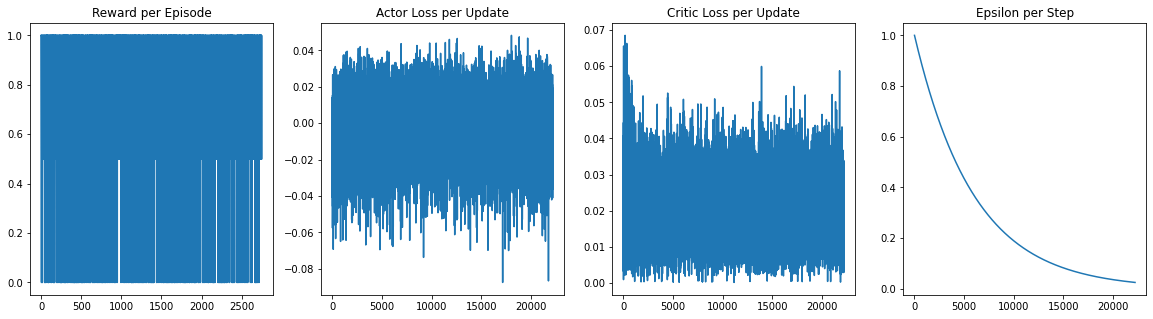

2
1
------S------------S--------Rx(0.904)----Rz(2.440)----Rx(4.894)----Rz(2.610)--------S----------------------------------------------------------------------------
                                                                                                                                                                 
--Ry(5.949)----Rz(3.843)----Ry(3.153)----Rz(1.288)--------S------------S--------Ry(5.576)----Rz(3.809)----Ry(4.837)----Rz(3.951)----S----Ry(3.487)----Rz(3.776)--
                                                                                                                                                                 
1
1
0
1
1
0
2
1
0
1
--Rx(4.120)----Rz(5.947)----Rx(0.655)----Rz(1.658)--------S--------Rx(3.215)----Rz(4.952)------------------------------------------------------------------------
                                                                                                                                                                 
--Ry

0
1
1
1
--Rx(2.386)----Rz(3.578)--------S------------S--------Rx(5.179)----Rz(0.189)----Rx(0.603)----Rz(1.422)------------------------------------------------------
                                                                                                                                                            
--Ry(3.061)----Rz(3.373)----Ry(2.998)----Rz(4.081)--------S------------S--------Ry(1.187)----Rz(3.276)----Ry(2.366)----Rz(2.693)----Ry(4.901)----Rz(2.609)--
                                                                                                                                                            
1
0
1
0
0
1
2
0
2
1
--Rx(4.508)----Rz(6.210)----Rx(6.216)----Rz(2.759)----Rx(0.730)----Rz(5.996)----S----Rx(3.506)----Rz(4.301)--------S------
                                                                                                                          
--Ry(1.415)----Rz(2.463)----Ry(0.260)----Rz(2.428)----Ry(3.930)----Rz(5.468)----S--------S--------

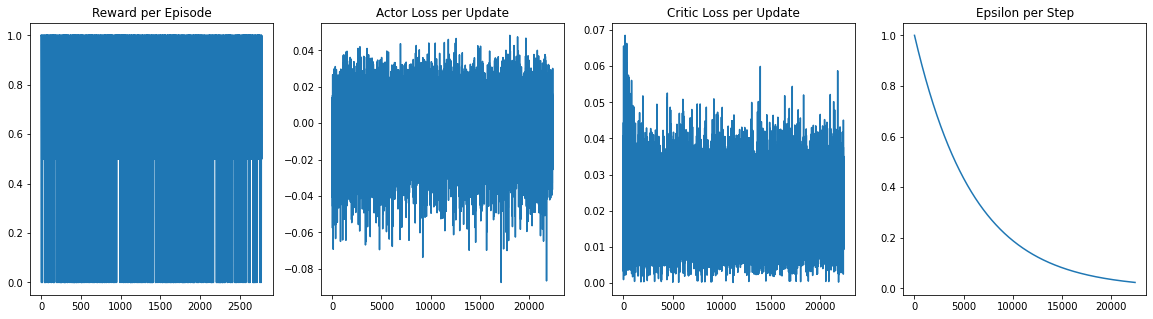

0
0
0
2
--Rx(2.076)----Rz(5.529)----Rx(0.770)----Rz(3.586)----Rx(4.786)----Rz(1.217)----Rx(2.780)----Rz(1.698)----Rx(4.921)----Rz(1.433)----Rx(0.184)----Rz(2.361)----Rx(5.811)----Rz(5.169)----S--
                                                                                                                                                                                           
--Ry(0.691)----Rz(5.536)----Ry(5.728)----Rz(1.867)--------S--------------------------------------------------------------------------------------------------------------------------------
                                                                                                                                                                                           
2
1
0
2
1
[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
--S----Rx(1.110)----Rz(1.766)----S----------------------------
                                                              
--S--

2
1
1
0
1
0
0
1
0
0
--S----Rx(2.208)----Rz(2.722)----Rx(2.132)----Rz(4.276)----Rx(2.114)----Rz(3.787)----Rx(0.517)----Rz(2.833)----Rx(1.779)----Rz(5.951)--
                                                                                                                                       
--S----Ry(3.981)----Rz(4.501)----Ry(3.416)----Rz(0.301)----Ry(2.743)----Rz(5.899)----Ry(2.695)----Rz(5.354)----------------------------
                                                                                                                                       
1
1
1
2
0
2
0
1
0
1
------S--------Rx(1.559)----Rz(3.731)--------S--------Rx(4.608)----Rz(4.404)----Rx(5.579)----Rz(0.135)------------------------------------------------------
                                                                                                                                                            
--Ry(3.273)----Rz(2.886)----Ry(4.757)----Rz(3.081)----Ry(4.310)----Rz(3.747)--------S------------S----

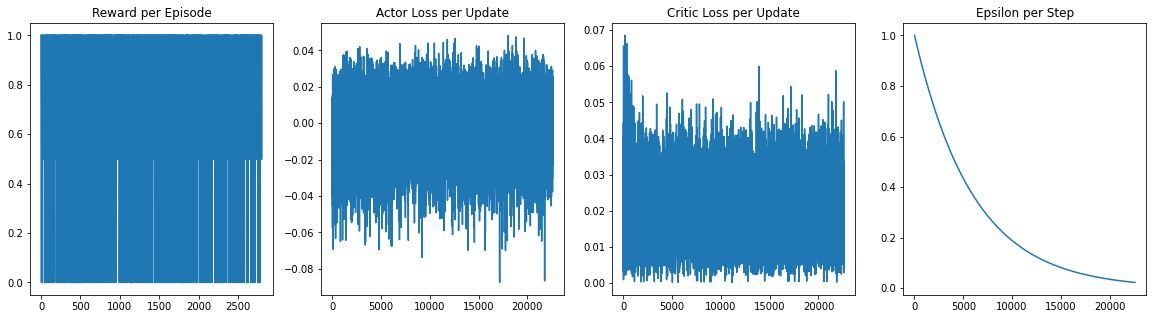

2
1
1
--Rx(4.638)----Rz(4.943)----Rx(0.806)----Rz(2.841)----Rx(4.158)----Rz(0.420)----Rx(0.794)----Rz(5.810)--------S------------S------
                                                                                                                                  
--Ry(3.986)----Rz(0.136)----Ry(1.195)----Rz(5.439)--------S------------S--------Ry(2.813)----Rz(0.501)----Ry(0.944)----Rz(5.136)--
                                                                                                                                  
1
2
0
0
2
1
1
1
0
2
------S--------Rx(5.317)----Rz(1.528)----Rx(5.085)----Rz(0.508)--------S--------Rx(4.482)----Rz(2.783)--------S------------------------
                                                                                                                                       
--Ry(2.857)----Rz(4.280)--------S------------S--------Ry(5.192)----Rz(1.583)----Ry(3.219)----Rz(2.321)----Ry(1.464)----Rz(1.367)----S--
                                          

0
1
1
0
0
0
2
1
1
2
--Rx(5.634)----Rz(3.184)----Rx(5.192)----Rz(1.682)----Rx(1.920)----Rz(0.283)----Rx(3.144)----Rz(0.330)--------S--------S--
                                                                                                                          
--Ry(0.303)----Rz(1.772)----Ry(3.656)----Rz(5.802)--------S--------Ry(5.410)----Rz(0.167)----Ry(1.009)----Rz(2.311)----S--
                                                                                                                          
0
0
0
0
1
0
0
0
2
2
--Rx(0.421)----Rz(5.702)----Rx(5.911)----Rz(0.570)----Rx(4.561)----Rz(5.228)----Rx(5.702)----Rz(1.877)----Rx(0.674)----Rz(1.662)----Rx(6.142)----Rz(1.444)----Rx(4.851)----Rz(0.905)----S----S--
                                                                                                                                                                                                
--Ry(1.404)----Rz(6.038)--------S------------S------------------------------------

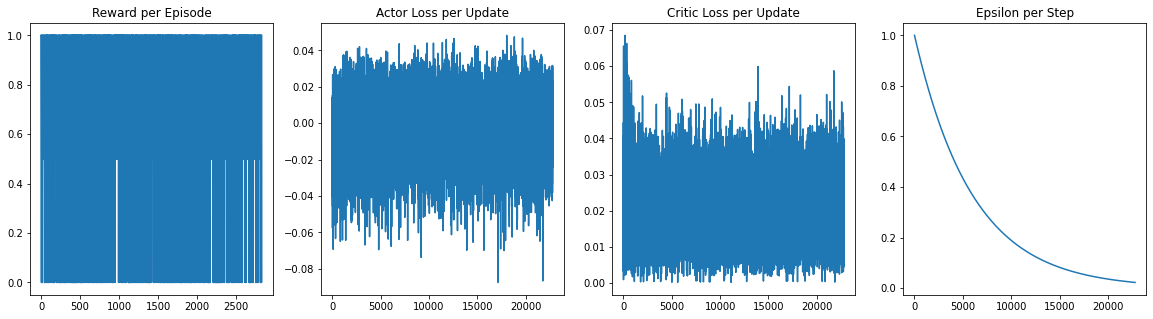

2
1
1
0
0
1
0
1
0
--S----S----Rx(5.063)----Rz(0.702)----Rx(5.100)----Rz(0.240)----Rx(5.469)----Rz(4.063)----Rx(5.087)----Rz(0.094)--
                                                                                                                  
--S----S----Ry(6.119)----Rz(2.411)----Ry(3.315)----Rz(4.171)----Ry(0.546)----Rz(4.170)----Ry(5.875)----Rz(3.964)--
                                                                                                                  
2
0
1
2
2
0
1
1
1
1
--S----Rx(6.201)----Rz(5.810)----S----S----Rx(5.621)----Rz(0.372)--------------------------------------------------------------------------------
                                                                                                                                                 
--S----Ry(2.484)----Rz(2.221)----S----S----Ry(0.552)----Rz(0.799)----Ry(4.628)----Rz(2.382)----Ry(6.011)----Rz(2.531)----Ry(4.927)----Rz(2.849)--
                                                                

0
2
0
1
[ 5.00000000e-01-5.00000000e-01j  7.85046229e-17+1.66533454e-16j
 -5.00000000e-01-5.00000000e-01j]
------S--------Rx(2.365)----Rz(3.706)----Rx(0.710)----Rz(0.924)----Rx(0.657)----Rz(0.968)----S----Rx(6.173)----Rz(6.179)--
                                                                                                                          
--Ry(2.931)----Rz(1.296)----Ry(0.414)----Rz(1.138)--------S--------Ry(0.433)----Rz(4.855)----S----Ry(4.316)----Rz(1.491)--
                                                                                                                          
0
1
0
2
0
0
1
1
1
2
--Rx(3.480)----Rz(3.079)----Rx(5.253)----Rz(4.046)--------S--------Rx(4.596)----Rz(3.622)----Rx(1.710)----Rz(5.190)----S--
                                                                                                                          
--Ry(4.948)----Rz(3.385)--------S--------Ry(4.996)----Rz(4.536)----Ry(1.303)----Rz(5.061)----Ry(0.965)----Rz(3.330)----S--
            

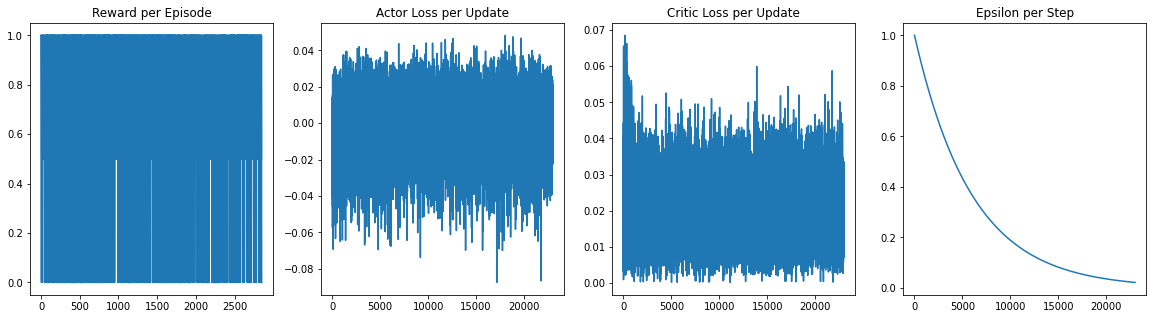

2
0
2
1
[-5.00000000e-01+5.00000000e-01j  2.22044605e-16+2.35513869e-16j
 -5.00000000e-01-5.00000000e-01j]
--S----Rx(6.006)----Rz(2.872)----Rx(1.126)----Rz(3.286)----S----S----Rx(3.942)----Rz(3.518)--------S------
                                                                                                          
--S----Ry(4.518)----Rz(5.097)----Ry(0.140)----Rz(2.953)----S----S--------S--------Ry(2.055)----Rz(0.279)--
                                                                                                          
2
1
2
2
1
0
1
2
1
2
--S--------S------------S--------Rx(4.768)----Rz(1.131)--------S------------S--------------------------------------------------------------------
                                                                                                                                                 
--S----Ry(3.153)----Rz(5.689)--------S------------S--------Ry(5.893)----Rz(3.386)----Ry(3.759)----Rz(4.662)----S----Ry(3.997)----Rz(4.898)----S--
       

2
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(6.103)----Rz(2.260)----S----Rx(4.041)----Rz(4.411)--
                                                         
--Ry(4.099)----Rz(2.488)----S----------------------------
                                                         
2
2
0
1
2
1
0
[ 5.00000000e-01+5.00000000e-01j -7.85046229e-17-1.66533454e-16j
 -5.00000000e-01+5.00000000e-01j]
--S----S----Rx(4.272)----Rz(1.665)----S----Rx(4.444)----Rz(2.321)--
                                                                   
--S----S----Ry(0.123)----Rz(3.035)----S----Ry(2.880)----Rz(5.125)--
                                                                   
0
1
1
0
1
0
1
0
1
1
--Rx(1.763)----Rz(2.260)----Rx(0.409)----Rz(0.644)----Rx(1.123)----Rz(3.015)----Rx(6.008)----Rz(1.174)------------------------------------------------------
                                                                                                       

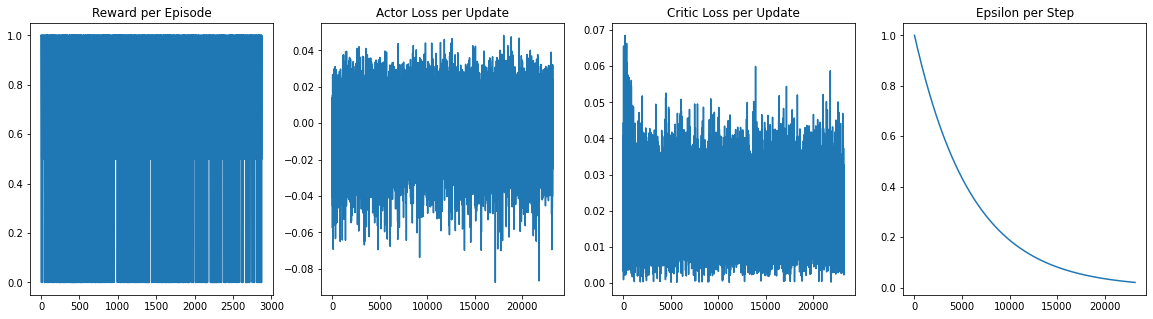

2
2
0
[ 5.00000000e-01+5.00000000e-01j -7.85046229e-17-5.55111512e-17j
 -5.00000000e-01+5.00000000e-01j]
--S----Rx(1.927)----Rz(5.956)----S----S----S----Rx(1.965)----Rz(1.989)--
                                                                        
--S--------S------------S--------S--------------------------------------
                                                                        
0
1
0
2
0
2
0
[-5.00000000e-01+5.00000000e-01j -5.55111512e-17-1.89526925e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(4.775)----Rz(5.558)----Rx(3.096)----Rz(3.206)----S----Rx(5.034)----Rz(2.466)----S----Rx(0.094)----Rz(1.794)--
                                                                                                                  
--Ry(0.737)----Rz(5.718)--------S------------S--------------------------------------------------------------------
                                                                                                                  
0
2
1
1
1
0
[-0.5+5.00000000e-

2
2
--Rx(2.867)----Rz(3.202)--------S------------S------------S------------S------------------------------------------------------------------------------
                                                                                                                                                      
--Ry(1.779)----Rz(1.231)----Ry(0.266)----Rz(5.826)----Ry(4.021)----Rz(0.373)----Ry(1.867)----Rz(5.378)----S----Ry(0.910)----Rz(4.664)----S----S----S--
                                                                                                                                                      
1
1
2
0
2
1
0
[-5.00000000e-01+5.00000000e-01j -7.85046229e-17+1.66533454e-16j
  5.00000000e-01+5.00000000e-01j]
------S--------Rx(0.970)----Rz(2.502)--------S--------Rx(2.005)----Rz(1.710)----------------------------
                                                                                                        
--Ry(1.929)----Rz(1.190)----Ry(5.416)----Rz(0.095)--------S----------

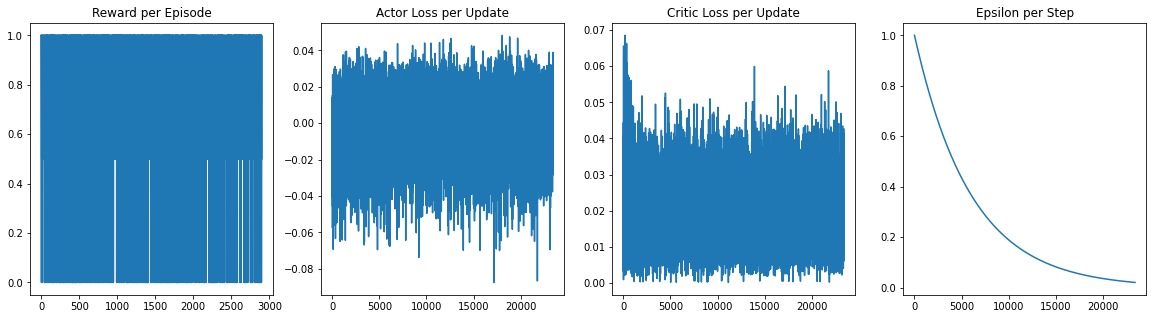

1
0
0
0
1
2
------S------------S--------Rx(0.122)----Rz(0.003)----Rx(5.629)----Rz(0.178)----Rx(5.768)----Rz(3.136)----Rx(5.998)----Rz(3.935)----S--
                                                                                                                                       
--Ry(1.933)----Rz(0.424)--------S------------S--------Ry(4.208)----Rz(6.203)----Ry(1.829)----Rz(2.344)--------S------------------------
                                                                                                                                       
1
1
0
1
0
2
1
1
0
2
--Rx(5.156)----Rz(3.178)----Rx(5.234)----Rz(2.185)--------S--------Rx(5.575)----Rz(5.001)--------S--------------------------------------------------
                                                                                                                                                    
--Ry(4.380)----Rz(4.763)----Ry(0.919)----Rz(0.664)----Ry(5.263)----Rz(0.498)--------S--------Ry(0.038)----Rz(5.543)----Ry(0.03

1
2
2
--Rx(2.697)----Rz(3.701)--------S------------S--------Rx(1.142)----Rz(4.123)----Rx(0.761)----Rz(1.182)----S----S--
                                                                                                                  
------S--------Ry(5.518)----Rz(3.224)----Ry(2.696)----Rz(3.446)--------S--------Ry(3.095)----Rz(2.973)----S----S--
                                                                                                                  
0
0
0
1
2
1
1
1
1
1
--Rx(2.647)----Rz(3.744)----Rx(0.445)----Rz(0.362)----Rx(2.859)----Rz(1.165)--------S------------------------------------------------------------------------------------
                                                                                                                                                                         
--Ry(5.801)----Rz(2.538)--------S--------Ry(0.964)----Rz(2.408)----Ry(3.961)----Rz(1.358)----Ry(5.026)----Rz(1.880)----Ry(0.006)----Rz(2.216)----Ry(1.421)----Rz(0.074)--
    

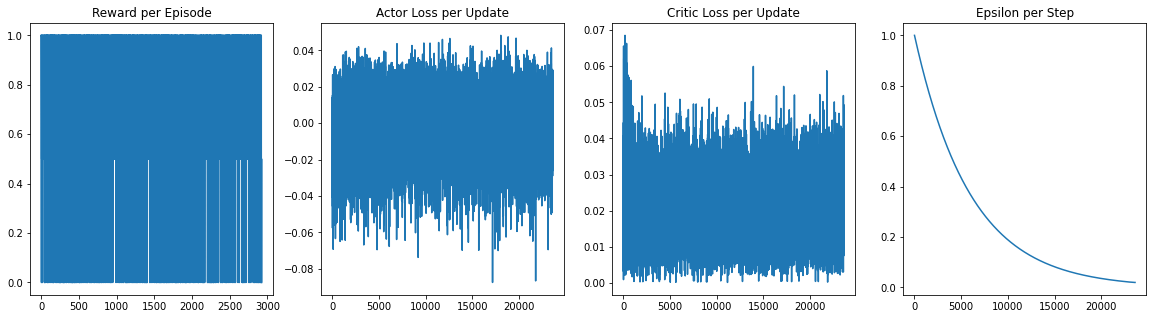

0
2
1
0
[ 5.00000000e-01-5.00000000e-01j -1.66533454e-16+7.85046229e-17j
  5.00000000e-01+5.00000000e-01j]
--Rx(3.287)----Rz(1.161)--------S--------Rx(4.160)----Rz(5.568)--
                                                                 
------S--------Ry(3.625)----Rz(6.023)----------------------------
                                                                 
2
0
0
1
1
2
0
1
0
0
--S----Rx(2.140)----Rz(4.023)----Rx(2.760)----Rz(5.075)----S----Rx(4.683)----Rz(5.744)----Rx(3.450)----Rz(3.536)----Rx(0.741)----Rz(4.174)--
                                                                                                                                            
--S----Ry(2.512)----Rz(0.300)----Ry(4.326)----Rz(3.667)----S----Ry(2.657)----Rz(0.714)------------------------------------------------------
                                                                                                                                            
0
1
1
1
0
0
2
0
[ 5.0000000e-01+5.00000000e-0

1
2
1
2
2
0
[ 5.00000000e-01-5.00000000e-01j  7.85046229e-17-1.66533454e-16j
 -5.00000000e-01-5.00000000e-01j]
--Rx(0.733)----Rz(1.222)----S--------S------------S--------Rx(1.815)----Rz(1.485)--
                                                                                   
--Ry(2.595)----Rz(5.879)----S----Ry(2.991)----Rz(1.812)--------S------------S------
                                                                                   
1
0
0
0
2
2
2
0
0
2
--Rx(3.495)----Rz(4.982)----Rx(2.009)----Rz(1.957)----Rx(0.663)----Rz(3.027)----S----S----S----Rx(2.137)----Rz(3.039)----Rx(0.833)----Rz(2.404)----S--
                                                                                                                                                      
--Ry(3.066)----Rz(1.964)--------S------------S------------S------------S------------------------------------------------------------------------------
                                                                                

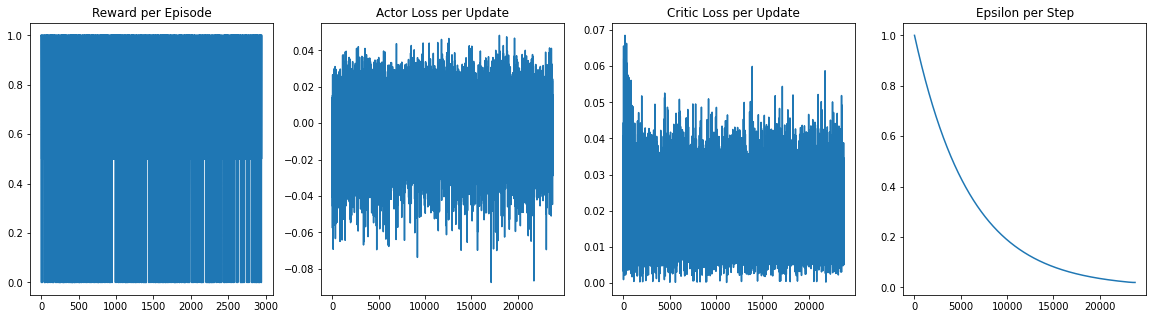

In [28]:
agent.train(num_frames)

[-5.00000000e-01-5.00000000e-01j -7.85046229e-17+5.55111512e-17j
  5.00000000e-01-5.00000000e-01j]
score:  1.0


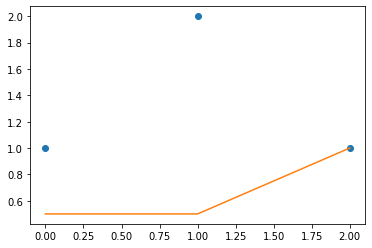

In [29]:
agent.epsilon = 0
frames = agent.test()
import matplotlib.pyplot as plt
act, QFI = zip(*frames)
plt.plot(act, 'o')
plt.plot(QFI)
plt.show()